In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 30
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_Contrast_glcm_Correlation_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortR

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 558)
(3944610, 8)
validation
(464344, 558)
(464344, 8)
test
(574820, 558)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 558)]             0         


 dense (Dense)               (None, 1024)              572416    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1262472 (4.82 MB)


Trainable params: 1262472 (4.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



  1/395 [..............................] - ETA: 8:51 - loss: 2.5614 - STD: 0.1442 - MAE: 0.2205


  5/395 [..............................] - ETA: 5s - loss: 2.2048 - STD: 0.0710 - MAE: 0.2178  


  9/395 [..............................] - ETA: 5s - loss: 2.1586 - STD: 0.0639 - MAE: 0.2169


 13/395 [..............................] - ETA: 5s - loss: 2.1394 - STD: 0.0576 - MAE: 0.2168


 17/395 [>.............................] - ETA: 5s - loss: 2.1225 - STD: 0.0543 - MAE: 0.2167


 21/395 [>.............................] - ETA: 5s - loss: 2.1094 - STD: 0.0514 - MAE: 0.2166


 25/395 [>.............................] - ETA: 5s - loss: 2.1012 - STD: 0.0481 - MAE: 0.2167


 29/395 [=>............................] - ETA: 5s - loss: 2.0954 - STD: 0.0453 - MAE: 0.2167


 33/395 [=>............................] - ETA: 5s - loss: 2.0901 - STD: 0.0437 - MAE: 0.2167


 37/395 [=>............................] - ETA: 5s - loss: 2.0857 - STD: 0.0429 - MAE: 0.2167


 41/395 [==>...........................] - ETA: 5s - loss: 2.0823 - STD: 0.0421 - MAE: 0.2167


 45/395 [==>...........................] - ETA: 4s - loss: 2.0793 - STD: 0.0414 - MAE: 0.2166


 49/395 [==>...........................] - ETA: 4s - loss: 2.0764 - STD: 0.0405 - MAE: 0.2166


 53/395 [===>..........................] - ETA: 4s - loss: 2.0736 - STD: 0.0398 - MAE: 0.2166


 57/395 [===>..........................] - ETA: 4s - loss: 2.0707 - STD: 0.0393 - MAE: 0.2166


 61/395 [===>..........................] - ETA: 4s - loss: 2.0673 - STD: 0.0389 - MAE: 0.2165


 65/395 [===>..........................] - ETA: 4s - loss: 2.0635 - STD: 0.0389 - MAE: 0.2164


 69/395 [====>.........................] - ETA: 4s - loss: 2.0592 - STD: 0.0391 - MAE: 0.2162


 73/395 [====>.........................] - ETA: 4s - loss: 2.0545 - STD: 0.0397 - MAE: 0.2160


 77/395 [====>.........................] - ETA: 4s - loss: 2.0492 - STD: 0.0404 - MAE: 0.2157


 81/395 [=====>........................] - ETA: 4s - loss: 2.0433 - STD: 0.0414 - MAE: 0.2154


 85/395 [=====>........................] - ETA: 4s - loss: 2.0369 - STD: 0.0425 - MAE: 0.2151


 89/395 [=====>........................] - ETA: 4s - loss: 2.0305 - STD: 0.0437 - MAE: 0.2148


 93/395 [======>.......................] - ETA: 4s - loss: 2.0235 - STD: 0.0449 - MAE: 0.2145


 97/395 [======>.......................] - ETA: 4s - loss: 2.0167 - STD: 0.0462 - MAE: 0.2141


101/395 [======>.......................] - ETA: 4s - loss: 2.0097 - STD: 0.0474 - MAE: 0.2138


105/395 [======>.......................] - ETA: 4s - loss: 2.0026 - STD: 0.0486 - MAE: 0.2134


109/395 [=======>......................] - ETA: 4s - loss: 1.9952 - STD: 0.0498 - MAE: 0.2131


113/395 [=======>......................] - ETA: 3s - loss: 1.9878 - STD: 0.0510 - MAE: 0.2127


117/395 [=======>......................] - ETA: 3s - loss: 1.9801 - STD: 0.0521 - MAE: 0.2123


121/395 [========>.....................] - ETA: 3s - loss: 1.9720 - STD: 0.0534 - MAE: 0.2119


125/395 [========>.....................] - ETA: 3s - loss: 1.9639 - STD: 0.0546 - MAE: 0.2115


129/395 [========>.....................] - ETA: 3s - loss: 1.9555 - STD: 0.0559 - MAE: 0.2110


133/395 [=========>....................] - ETA: 3s - loss: 1.9470 - STD: 0.0572 - MAE: 0.2106


137/395 [=========>....................] - ETA: 3s - loss: 1.9383 - STD: 0.0586 - MAE: 0.2101


141/395 [=========>....................] - ETA: 3s - loss: 1.9292 - STD: 0.0599 - MAE: 0.2096


145/395 [==========>...................] - ETA: 3s - loss: 1.9195 - STD: 0.0613 - MAE: 0.2090


149/395 [==========>...................] - ETA: 3s - loss: 1.9093 - STD: 0.0626 - MAE: 0.2085


153/395 [==========>...................] - ETA: 3s - loss: 1.8988 - STD: 0.0641 - MAE: 0.2079


157/395 [==========>...................] - ETA: 3s - loss: 1.8882 - STD: 0.0656 - MAE: 0.2072


161/395 [===========>..................] - ETA: 3s - loss: 1.8778 - STD: 0.0672 - MAE: 0.2065


165/395 [===========>..................] - ETA: 3s - loss: 1.8674 - STD: 0.0689 - MAE: 0.2059


169/395 [===========>..................] - ETA: 3s - loss: 1.8571 - STD: 0.0705 - MAE: 0.2052


173/395 [============>.................] - ETA: 3s - loss: 1.8472 - STD: 0.0721 - MAE: 0.2045


177/395 [============>.................] - ETA: 3s - loss: 1.8375 - STD: 0.0737 - MAE: 0.2038


181/395 [============>.................] - ETA: 3s - loss: 1.8281 - STD: 0.0753 - MAE: 0.2032


185/395 [=============>................] - ETA: 2s - loss: 1.8191 - STD: 0.0768 - MAE: 0.2026


189/395 [=============>................] - ETA: 2s - loss: 1.8101 - STD: 0.0782 - MAE: 0.2019


193/395 [=============>................] - ETA: 2s - loss: 1.8015 - STD: 0.0797 - MAE: 0.2013


197/395 [=============>................] - ETA: 2s - loss: 1.7932 - STD: 0.0811 - MAE: 0.2007


201/395 [==============>...............] - ETA: 2s - loss: 1.7850 - STD: 0.0824 - MAE: 0.2002


205/395 [==============>...............] - ETA: 2s - loss: 1.7771 - STD: 0.0838 - MAE: 0.1996


209/395 [==============>...............] - ETA: 2s - loss: 1.7694 - STD: 0.0851 - MAE: 0.1990


210/395 [==============>...............] - ETA: 3s - loss: 1.7686 - STD: 0.0854 - MAE: 0.1989


214/395 [===============>..............] - ETA: 3s - loss: 1.7609 - STD: 0.0866 - MAE: 0.1984


218/395 [===============>..............] - ETA: 3s - loss: 1.7535 - STD: 0.0879 - MAE: 0.1978


222/395 [===============>..............] - ETA: 2s - loss: 1.7464 - STD: 0.0890 - MAE: 0.1973


226/395 [================>.............] - ETA: 2s - loss: 1.7394 - STD: 0.0902 - MAE: 0.1968


230/395 [================>.............] - ETA: 2s - loss: 1.7326 - STD: 0.0913 - MAE: 0.1963


234/395 [================>.............] - ETA: 2s - loss: 1.7261 - STD: 0.0924 - MAE: 0.1959


238/395 [=================>............] - ETA: 2s - loss: 1.7196 - STD: 0.0935 - MAE: 0.1954


242/395 [=================>............] - ETA: 2s - loss: 1.7132 - STD: 0.0945 - MAE: 0.1949


246/395 [=================>............] - ETA: 2s - loss: 1.7071 - STD: 0.0955 - MAE: 0.1945


250/395 [=================>............] - ETA: 2s - loss: 1.7012 - STD: 0.0965 - MAE: 0.1940


254/395 [==================>...........] - ETA: 2s - loss: 1.6955 - STD: 0.0975 - MAE: 0.1936


258/395 [==================>...........] - ETA: 2s - loss: 1.6897 - STD: 0.0985 - MAE: 0.1932


262/395 [==================>...........] - ETA: 2s - loss: 1.6841 - STD: 0.0994 - MAE: 0.1928


266/395 [===================>..........] - ETA: 2s - loss: 1.6788 - STD: 0.1003 - MAE: 0.1924


270/395 [===================>..........] - ETA: 2s - loss: 1.6735 - STD: 0.1012 - MAE: 0.1920


274/395 [===================>..........] - ETA: 1s - loss: 1.6683 - STD: 0.1020 - MAE: 0.1916


278/395 [====================>.........] - ETA: 1s - loss: 1.6632 - STD: 0.1029 - MAE: 0.1912


282/395 [====================>.........] - ETA: 1s - loss: 1.6580 - STD: 0.1037 - MAE: 0.1908


286/395 [====================>.........] - ETA: 1s - loss: 1.6533 - STD: 0.1045 - MAE: 0.1905


290/395 [=====================>........] - ETA: 1s - loss: 1.6486 - STD: 0.1053 - MAE: 0.1901


294/395 [=====================>........] - ETA: 1s - loss: 1.6439 - STD: 0.1061 - MAE: 0.1898


298/395 [=====================>........] - ETA: 1s - loss: 1.6394 - STD: 0.1069 - MAE: 0.1894


302/395 [=====================>........] - ETA: 1s - loss: 1.6349 - STD: 0.1076 - MAE: 0.1891


306/395 [======================>.......] - ETA: 1s - loss: 1.6305 - STD: 0.1084 - MAE: 0.1888


310/395 [======================>.......] - ETA: 1s - loss: 1.6263 - STD: 0.1091 - MAE: 0.1884


314/395 [======================>.......] - ETA: 1s - loss: 1.6219 - STD: 0.1098 - MAE: 0.1881


318/395 [=======================>......] - ETA: 1s - loss: 1.6178 - STD: 0.1105 - MAE: 0.1878


322/395 [=======================>......] - ETA: 1s - loss: 1.6138 - STD: 0.1112 - MAE: 0.1875


326/395 [=======================>......] - ETA: 1s - loss: 1.6098 - STD: 0.1118 - MAE: 0.1872


330/395 [========================>.....] - ETA: 1s - loss: 1.6059 - STD: 0.1125 - MAE: 0.1869


334/395 [========================>.....] - ETA: 0s - loss: 1.6019 - STD: 0.1131 - MAE: 0.1866


338/395 [========================>.....] - ETA: 0s - loss: 1.5981 - STD: 0.1137 - MAE: 0.1863


342/395 [========================>.....] - ETA: 0s - loss: 1.5944 - STD: 0.1144 - MAE: 0.1860


346/395 [=========================>....] - ETA: 0s - loss: 1.5907 - STD: 0.1150 - MAE: 0.1857


350/395 [=========================>....] - ETA: 0s - loss: 1.5872 - STD: 0.1156 - MAE: 0.1854


354/395 [=========================>....] - ETA: 0s - loss: 1.5836 - STD: 0.1162 - MAE: 0.1851


358/395 [==========================>...] - ETA: 0s - loss: 1.5800 - STD: 0.1168 - MAE: 0.1849


362/395 [==========================>...] - ETA: 0s - loss: 1.5766 - STD: 0.1173 - MAE: 0.1846


366/395 [==========================>...] - ETA: 0s - loss: 1.5732 - STD: 0.1179 - MAE: 0.1843


370/395 [===========================>..] - ETA: 0s - loss: 1.5700 - STD: 0.1185 - MAE: 0.1841


374/395 [===========================>..] - ETA: 0s - loss: 1.5667 - STD: 0.1190 - MAE: 0.1838


378/395 [===========================>..] - ETA: 0s - loss: 1.5633 - STD: 0.1195 - MAE: 0.1835


382/395 [============================>.] - ETA: 0s - loss: 1.5602 - STD: 0.1201 - MAE: 0.1833


386/395 [============================>.] - ETA: 0s - loss: 1.5570 - STD: 0.1206 - MAE: 0.1830


390/395 [============================>.] - ETA: 0s - loss: 1.5540 - STD: 0.1211 - MAE: 0.1828


394/395 [============================>.] - ETA: 0s - loss: 1.5511 - STD: 0.1216 - MAE: 0.1826


395/395 [==============================] - 9s 18ms/step - loss: 1.5504 - STD: 0.1218 - MAE: 0.1825 - val_loss: 1.3220 - val_STD: 0.1721 - val_MAE: 0.1603


Epoch 2/10000



  1/395 [..............................] - ETA: 17s - loss: 1.2471 - STD: 0.1686 - MAE: 0.1595


  5/395 [..............................] - ETA: 5s - loss: 1.2602 - STD: 0.1703 - MAE: 0.1594 


  9/395 [..............................] - ETA: 5s - loss: 1.2605 - STD: 0.1709 - MAE: 0.1593


 13/395 [..............................] - ETA: 5s - loss: 1.2569 - STD: 0.1710 - MAE: 0.1591


 17/395 [>.............................] - ETA: 5s - loss: 1.2524 - STD: 0.1712 - MAE: 0.1588


 21/395 [>.............................] - ETA: 4s - loss: 1.2491 - STD: 0.1716 - MAE: 0.1585


 25/395 [>.............................] - ETA: 4s - loss: 1.2475 - STD: 0.1717 - MAE: 0.1584


 29/395 [=>............................] - ETA: 4s - loss: 1.2459 - STD: 0.1718 - MAE: 0.1583


 33/395 [=>............................] - ETA: 4s - loss: 1.2443 - STD: 0.1721 - MAE: 0.1581


 37/395 [=>............................] - ETA: 4s - loss: 1.2432 - STD: 0.1722 - MAE: 0.1580


 41/395 [==>...........................] - ETA: 4s - loss: 1.2424 - STD: 0.1723 - MAE: 0.1579


 45/395 [==>...........................] - ETA: 4s - loss: 1.2424 - STD: 0.1725 - MAE: 0.1578


 49/395 [==>...........................] - ETA: 4s - loss: 1.2421 - STD: 0.1726 - MAE: 0.1578


 53/395 [===>..........................] - ETA: 4s - loss: 1.2418 - STD: 0.1728 - MAE: 0.1577


 57/395 [===>..........................] - ETA: 4s - loss: 1.2413 - STD: 0.1729 - MAE: 0.1576


 61/395 [===>..........................] - ETA: 4s - loss: 1.2413 - STD: 0.1730 - MAE: 0.1576


 66/395 [====>.........................] - ETA: 4s - loss: 1.2406 - STD: 0.1731 - MAE: 0.1575


 70/395 [====>.........................] - ETA: 4s - loss: 1.2397 - STD: 0.1732 - MAE: 0.1574


 74/395 [====>.........................] - ETA: 4s - loss: 1.2387 - STD: 0.1733 - MAE: 0.1574


 77/395 [====>.........................] - ETA: 4s - loss: 1.2383 - STD: 0.1734 - MAE: 0.1573


 81/395 [=====>........................] - ETA: 4s - loss: 1.2372 - STD: 0.1735 - MAE: 0.1572


 84/395 [=====>........................] - ETA: 4s - loss: 1.2366 - STD: 0.1737 - MAE: 0.1571


 88/395 [=====>........................] - ETA: 4s - loss: 1.2361 - STD: 0.1738 - MAE: 0.1571


 91/395 [=====>........................] - ETA: 4s - loss: 1.2358 - STD: 0.1738 - MAE: 0.1570


 94/395 [======>.......................] - ETA: 4s - loss: 1.2350 - STD: 0.1739 - MAE: 0.1570


 98/395 [======>.......................] - ETA: 4s - loss: 1.2346 - STD: 0.1740 - MAE: 0.1569


102/395 [======>.......................] - ETA: 4s - loss: 1.2344 - STD: 0.1741 - MAE: 0.1568


106/395 [=======>......................] - ETA: 3s - loss: 1.2334 - STD: 0.1742 - MAE: 0.1568


110/395 [=======>......................] - ETA: 3s - loss: 1.2323 - STD: 0.1743 - MAE: 0.1567


114/395 [=======>......................] - ETA: 3s - loss: 1.2312 - STD: 0.1744 - MAE: 0.1566


118/395 [=======>......................] - ETA: 3s - loss: 1.2303 - STD: 0.1745 - MAE: 0.1565


122/395 [========>.....................] - ETA: 3s - loss: 1.2292 - STD: 0.1747 - MAE: 0.1564


126/395 [========>.....................] - ETA: 3s - loss: 1.2285 - STD: 0.1748 - MAE: 0.1563


130/395 [========>.....................] - ETA: 3s - loss: 1.2275 - STD: 0.1749 - MAE: 0.1562


134/395 [=========>....................] - ETA: 3s - loss: 1.2267 - STD: 0.1750 - MAE: 0.1562


138/395 [=========>....................] - ETA: 3s - loss: 1.2258 - STD: 0.1751 - MAE: 0.1561


141/395 [=========>....................] - ETA: 3s - loss: 1.2254 - STD: 0.1752 - MAE: 0.1560


144/395 [=========>....................] - ETA: 3s - loss: 1.2250 - STD: 0.1753 - MAE: 0.1560


147/395 [==========>...................] - ETA: 3s - loss: 1.2247 - STD: 0.1754 - MAE: 0.1559


150/395 [==========>...................] - ETA: 3s - loss: 1.2242 - STD: 0.1754 - MAE: 0.1559


153/395 [==========>...................] - ETA: 3s - loss: 1.2237 - STD: 0.1755 - MAE: 0.1558


156/395 [==========>...................] - ETA: 3s - loss: 1.2233 - STD: 0.1756 - MAE: 0.1558


158/395 [===========>..................] - ETA: 3s - loss: 1.2227 - STD: 0.1756 - MAE: 0.1557


161/395 [===========>..................] - ETA: 3s - loss: 1.2225 - STD: 0.1757 - MAE: 0.1557


164/395 [===========>..................] - ETA: 3s - loss: 1.2218 - STD: 0.1758 - MAE: 0.1556


167/395 [===========>..................] - ETA: 3s - loss: 1.2211 - STD: 0.1759 - MAE: 0.1555


170/395 [===========>..................] - ETA: 3s - loss: 1.2207 - STD: 0.1760 - MAE: 0.1555


173/395 [============>.................] - ETA: 3s - loss: 1.2202 - STD: 0.1760 - MAE: 0.1554


176/395 [============>.................] - ETA: 3s - loss: 1.2198 - STD: 0.1761 - MAE: 0.1554


179/395 [============>.................] - ETA: 3s - loss: 1.2191 - STD: 0.1762 - MAE: 0.1553


182/395 [============>.................] - ETA: 3s - loss: 1.2184 - STD: 0.1763 - MAE: 0.1553


185/395 [=============>................] - ETA: 3s - loss: 1.2178 - STD: 0.1763 - MAE: 0.1552


189/395 [=============>................] - ETA: 3s - loss: 1.2171 - STD: 0.1764 - MAE: 0.1551


192/395 [=============>................] - ETA: 3s - loss: 1.2163 - STD: 0.1765 - MAE: 0.1551


196/395 [=============>................] - ETA: 3s - loss: 1.2154 - STD: 0.1766 - MAE: 0.1550


200/395 [==============>...............] - ETA: 2s - loss: 1.2147 - STD: 0.1767 - MAE: 0.1549


204/395 [==============>...............] - ETA: 2s - loss: 1.2141 - STD: 0.1768 - MAE: 0.1548


208/395 [==============>...............] - ETA: 2s - loss: 1.2135 - STD: 0.1769 - MAE: 0.1548


212/395 [===============>..............] - ETA: 2s - loss: 1.2131 - STD: 0.1770 - MAE: 0.1547


216/395 [===============>..............] - ETA: 2s - loss: 1.2125 - STD: 0.1771 - MAE: 0.1546


220/395 [===============>..............] - ETA: 2s - loss: 1.2121 - STD: 0.1772 - MAE: 0.1546


224/395 [================>.............] - ETA: 2s - loss: 1.2117 - STD: 0.1773 - MAE: 0.1545


228/395 [================>.............] - ETA: 2s - loss: 1.2113 - STD: 0.1774 - MAE: 0.1545


232/395 [================>.............] - ETA: 2s - loss: 1.2108 - STD: 0.1775 - MAE: 0.1544


236/395 [================>.............] - ETA: 2s - loss: 1.2103 - STD: 0.1776 - MAE: 0.1544


240/395 [=================>............] - ETA: 2s - loss: 1.2097 - STD: 0.1776 - MAE: 0.1543


244/395 [=================>............] - ETA: 2s - loss: 1.2090 - STD: 0.1777 - MAE: 0.1542


248/395 [=================>............] - ETA: 2s - loss: 1.2084 - STD: 0.1778 - MAE: 0.1542


252/395 [==================>...........] - ETA: 2s - loss: 1.2077 - STD: 0.1778 - MAE: 0.1541


256/395 [==================>...........] - ETA: 2s - loss: 1.2070 - STD: 0.1779 - MAE: 0.1541


259/395 [==================>...........] - ETA: 2s - loss: 1.2064 - STD: 0.1780 - MAE: 0.1540


262/395 [==================>...........] - ETA: 2s - loss: 1.2060 - STD: 0.1781 - MAE: 0.1539


266/395 [===================>..........] - ETA: 1s - loss: 1.2052 - STD: 0.1782 - MAE: 0.1539


269/395 [===================>..........] - ETA: 1s - loss: 1.2046 - STD: 0.1783 - MAE: 0.1538


272/395 [===================>..........] - ETA: 1s - loss: 1.2041 - STD: 0.1783 - MAE: 0.1538


274/395 [===================>..........] - ETA: 1s - loss: 1.2038 - STD: 0.1784 - MAE: 0.1537


276/395 [===================>..........] - ETA: 1s - loss: 1.2034 - STD: 0.1784 - MAE: 0.1537


278/395 [====================>.........] - ETA: 1s - loss: 1.2030 - STD: 0.1785 - MAE: 0.1537


280/395 [====================>.........] - ETA: 1s - loss: 1.2028 - STD: 0.1785 - MAE: 0.1536


283/395 [====================>.........] - ETA: 1s - loss: 1.2025 - STD: 0.1786 - MAE: 0.1536


286/395 [====================>.........] - ETA: 1s - loss: 1.2019 - STD: 0.1786 - MAE: 0.1536


289/395 [====================>.........] - ETA: 1s - loss: 1.2014 - STD: 0.1787 - MAE: 0.1535


292/395 [=====================>........] - ETA: 1s - loss: 1.2009 - STD: 0.1788 - MAE: 0.1534


295/395 [=====================>........] - ETA: 1s - loss: 1.2004 - STD: 0.1788 - MAE: 0.1534


299/395 [=====================>........] - ETA: 1s - loss: 1.1997 - STD: 0.1789 - MAE: 0.1533


302/395 [=====================>........] - ETA: 1s - loss: 1.1992 - STD: 0.1790 - MAE: 0.1533


305/395 [======================>.......] - ETA: 1s - loss: 1.1987 - STD: 0.1790 - MAE: 0.1532


308/395 [======================>.......] - ETA: 1s - loss: 1.1983 - STD: 0.1791 - MAE: 0.1532


312/395 [======================>.......] - ETA: 1s - loss: 1.1975 - STD: 0.1792 - MAE: 0.1531


315/395 [======================>.......] - ETA: 1s - loss: 1.1970 - STD: 0.1792 - MAE: 0.1531


318/395 [=======================>......] - ETA: 1s - loss: 1.1965 - STD: 0.1793 - MAE: 0.1530


321/395 [=======================>......] - ETA: 1s - loss: 1.1959 - STD: 0.1794 - MAE: 0.1530


324/395 [=======================>......] - ETA: 1s - loss: 1.1955 - STD: 0.1794 - MAE: 0.1529


328/395 [=======================>......] - ETA: 1s - loss: 1.1948 - STD: 0.1795 - MAE: 0.1529


331/395 [========================>.....] - ETA: 1s - loss: 1.1944 - STD: 0.1796 - MAE: 0.1528


334/395 [========================>.....] - ETA: 0s - loss: 1.1938 - STD: 0.1796 - MAE: 0.1527


337/395 [========================>.....] - ETA: 0s - loss: 1.1933 - STD: 0.1797 - MAE: 0.1527


340/395 [========================>.....] - ETA: 0s - loss: 1.1928 - STD: 0.1798 - MAE: 0.1526


343/395 [=========================>....] - ETA: 0s - loss: 1.1922 - STD: 0.1798 - MAE: 0.1526


346/395 [=========================>....] - ETA: 0s - loss: 1.1918 - STD: 0.1799 - MAE: 0.1525


349/395 [=========================>....] - ETA: 0s - loss: 1.1913 - STD: 0.1800 - MAE: 0.1525


352/395 [=========================>....] - ETA: 0s - loss: 1.1908 - STD: 0.1800 - MAE: 0.1524


355/395 [=========================>....] - ETA: 0s - loss: 1.1907 - STD: 0.1801 - MAE: 0.1524


358/395 [==========================>...] - ETA: 0s - loss: 1.1907 - STD: 0.1801 - MAE: 0.1524


361/395 [==========================>...] - ETA: 0s - loss: 1.1906 - STD: 0.1802 - MAE: 0.1524


365/395 [==========================>...] - ETA: 0s - loss: 1.1901 - STD: 0.1803 - MAE: 0.1523


368/395 [==========================>...] - ETA: 0s - loss: 1.1898 - STD: 0.1803 - MAE: 0.1523


371/395 [===========================>..] - ETA: 0s - loss: 1.1894 - STD: 0.1804 - MAE: 0.1522


374/395 [===========================>..] - ETA: 0s - loss: 1.1891 - STD: 0.1804 - MAE: 0.1522


378/395 [===========================>..] - ETA: 0s - loss: 1.1885 - STD: 0.1805 - MAE: 0.1521


381/395 [===========================>..] - ETA: 0s - loss: 1.1881 - STD: 0.1806 - MAE: 0.1521


384/395 [============================>.] - ETA: 0s - loss: 1.1877 - STD: 0.1806 - MAE: 0.1521


387/395 [============================>.] - ETA: 0s - loss: 1.1873 - STD: 0.1807 - MAE: 0.1520


390/395 [============================>.] - ETA: 0s - loss: 1.1868 - STD: 0.1807 - MAE: 0.1520


394/395 [============================>.] - ETA: 0s - loss: 1.1863 - STD: 0.1808 - MAE: 0.1519


395/395 [==============================] - 7s 18ms/step - loss: 1.1861 - STD: 0.1808 - MAE: 0.1519 - val_loss: 1.2493 - val_STD: 0.1895 - val_MAE: 0.1490


Epoch 3/10000



  1/395 [..............................] - ETA: 16s - loss: 1.1242 - STD: 0.1884 - MAE: 0.1458


  4/395 [..............................] - ETA: 6s - loss: 1.1235 - STD: 0.1885 - MAE: 0.1458 


  6/395 [..............................] - ETA: 8s - loss: 1.1234 - STD: 0.1884 - MAE: 0.1458


  8/395 [..............................] - ETA: 8s - loss: 1.1219 - STD: 0.1882 - MAE: 0.1457


 12/395 [..............................] - ETA: 7s - loss: 1.1207 - STD: 0.1884 - MAE: 0.1456


 15/395 [>.............................] - ETA: 7s - loss: 1.1184 - STD: 0.1887 - MAE: 0.1453


 19/395 [>.............................] - ETA: 7s - loss: 1.1169 - STD: 0.1888 - MAE: 0.1452


 22/395 [>.............................] - ETA: 7s - loss: 1.1159 - STD: 0.1888 - MAE: 0.1451


 25/395 [>.............................] - ETA: 7s - loss: 1.1156 - STD: 0.1889 - MAE: 0.1451


 28/395 [=>............................] - ETA: 7s - loss: 1.1145 - STD: 0.1891 - MAE: 0.1450


 31/395 [=>............................] - ETA: 7s - loss: 1.1143 - STD: 0.1893 - MAE: 0.1449


 34/395 [=>............................] - ETA: 7s - loss: 1.1142 - STD: 0.1893 - MAE: 0.1449


 37/395 [=>............................] - ETA: 7s - loss: 1.1133 - STD: 0.1895 - MAE: 0.1447


 40/395 [==>...........................] - ETA: 6s - loss: 1.1130 - STD: 0.1895 - MAE: 0.1447


 43/395 [==>...........................] - ETA: 6s - loss: 1.1126 - STD: 0.1897 - MAE: 0.1446


 46/395 [==>...........................] - ETA: 6s - loss: 1.1128 - STD: 0.1898 - MAE: 0.1446


 49/395 [==>...........................] - ETA: 6s - loss: 1.1122 - STD: 0.1900 - MAE: 0.1445


 52/395 [==>...........................] - ETA: 6s - loss: 1.1119 - STD: 0.1900 - MAE: 0.1445


 55/395 [===>..........................] - ETA: 6s - loss: 1.1113 - STD: 0.1901 - MAE: 0.1444


 58/395 [===>..........................] - ETA: 6s - loss: 1.1108 - STD: 0.1902 - MAE: 0.1443


 61/395 [===>..........................] - ETA: 6s - loss: 1.1105 - STD: 0.1902 - MAE: 0.1443


 64/395 [===>..........................] - ETA: 6s - loss: 1.1103 - STD: 0.1903 - MAE: 0.1443


 67/395 [====>.........................] - ETA: 6s - loss: 1.1097 - STD: 0.1904 - MAE: 0.1442


 70/395 [====>.........................] - ETA: 6s - loss: 1.1093 - STD: 0.1905 - MAE: 0.1441


 73/395 [====>.........................] - ETA: 6s - loss: 1.1091 - STD: 0.1906 - MAE: 0.1441


 76/395 [====>.........................] - ETA: 6s - loss: 1.1087 - STD: 0.1906 - MAE: 0.1441


 79/395 [=====>........................] - ETA: 6s - loss: 1.1085 - STD: 0.1907 - MAE: 0.1440


 82/395 [=====>........................] - ETA: 6s - loss: 1.1081 - STD: 0.1907 - MAE: 0.1440


 85/395 [=====>........................] - ETA: 6s - loss: 1.1080 - STD: 0.1908 - MAE: 0.1440


 88/395 [=====>........................] - ETA: 6s - loss: 1.1079 - STD: 0.1908 - MAE: 0.1439


 91/395 [=====>........................] - ETA: 6s - loss: 1.1072 - STD: 0.1909 - MAE: 0.1439


 94/395 [======>.......................] - ETA: 5s - loss: 1.1065 - STD: 0.1910 - MAE: 0.1438


 97/395 [======>.......................] - ETA: 5s - loss: 1.1059 - STD: 0.1911 - MAE: 0.1437


100/395 [======>.......................] - ETA: 5s - loss: 1.1056 - STD: 0.1912 - MAE: 0.1437


104/395 [======>.......................] - ETA: 5s - loss: 1.1055 - STD: 0.1912 - MAE: 0.1437


107/395 [=======>......................] - ETA: 5s - loss: 1.1052 - STD: 0.1913 - MAE: 0.1436


110/395 [=======>......................] - ETA: 5s - loss: 1.1048 - STD: 0.1914 - MAE: 0.1436


113/395 [=======>......................] - ETA: 5s - loss: 1.1047 - STD: 0.1914 - MAE: 0.1435


115/395 [=======>......................] - ETA: 5s - loss: 1.1047 - STD: 0.1915 - MAE: 0.1435


118/395 [=======>......................] - ETA: 5s - loss: 1.1044 - STD: 0.1915 - MAE: 0.1435


122/395 [========>.....................] - ETA: 5s - loss: 1.1037 - STD: 0.1916 - MAE: 0.1434


125/395 [========>.....................] - ETA: 5s - loss: 1.1036 - STD: 0.1917 - MAE: 0.1434


129/395 [========>.....................] - ETA: 5s - loss: 1.1031 - STD: 0.1918 - MAE: 0.1433


132/395 [=========>....................] - ETA: 5s - loss: 1.1027 - STD: 0.1918 - MAE: 0.1433


135/395 [=========>....................] - ETA: 5s - loss: 1.1024 - STD: 0.1919 - MAE: 0.1433


138/395 [=========>....................] - ETA: 5s - loss: 1.1023 - STD: 0.1920 - MAE: 0.1432


141/395 [=========>....................] - ETA: 4s - loss: 1.1019 - STD: 0.1920 - MAE: 0.1432


144/395 [=========>....................] - ETA: 4s - loss: 1.1016 - STD: 0.1921 - MAE: 0.1431


147/395 [==========>...................] - ETA: 4s - loss: 1.1013 - STD: 0.1921 - MAE: 0.1431


150/395 [==========>...................] - ETA: 4s - loss: 1.1009 - STD: 0.1922 - MAE: 0.1430


153/395 [==========>...................] - ETA: 4s - loss: 1.1007 - STD: 0.1922 - MAE: 0.1430


156/395 [==========>...................] - ETA: 4s - loss: 1.1003 - STD: 0.1923 - MAE: 0.1430


159/395 [===========>..................] - ETA: 4s - loss: 1.1003 - STD: 0.1924 - MAE: 0.1429


161/395 [===========>..................] - ETA: 4s - loss: 1.1000 - STD: 0.1924 - MAE: 0.1429


164/395 [===========>..................] - ETA: 4s - loss: 1.0999 - STD: 0.1925 - MAE: 0.1429


167/395 [===========>..................] - ETA: 4s - loss: 1.0995 - STD: 0.1925 - MAE: 0.1428


170/395 [===========>..................] - ETA: 4s - loss: 1.0990 - STD: 0.1926 - MAE: 0.1428


173/395 [============>.................] - ETA: 4s - loss: 1.0986 - STD: 0.1926 - MAE: 0.1428


176/395 [============>.................] - ETA: 4s - loss: 1.0983 - STD: 0.1927 - MAE: 0.1427


179/395 [============>.................] - ETA: 4s - loss: 1.0984 - STD: 0.1927 - MAE: 0.1427


181/395 [============>.................] - ETA: 4s - loss: 1.0982 - STD: 0.1928 - MAE: 0.1427


184/395 [============>.................] - ETA: 4s - loss: 1.0982 - STD: 0.1928 - MAE: 0.1426


188/395 [=============>................] - ETA: 4s - loss: 1.0980 - STD: 0.1929 - MAE: 0.1426


191/395 [=============>................] - ETA: 4s - loss: 1.0979 - STD: 0.1929 - MAE: 0.1426


195/395 [=============>................] - ETA: 3s - loss: 1.0977 - STD: 0.1930 - MAE: 0.1425


199/395 [==============>...............] - ETA: 3s - loss: 1.0976 - STD: 0.1931 - MAE: 0.1425


203/395 [==============>...............] - ETA: 3s - loss: 1.0974 - STD: 0.1932 - MAE: 0.1425


207/395 [==============>...............] - ETA: 3s - loss: 1.0971 - STD: 0.1932 - MAE: 0.1424


211/395 [===============>..............] - ETA: 3s - loss: 1.0967 - STD: 0.1933 - MAE: 0.1424


215/395 [===============>..............] - ETA: 3s - loss: 1.0964 - STD: 0.1934 - MAE: 0.1423


219/395 [===============>..............] - ETA: 3s - loss: 1.0959 - STD: 0.1934 - MAE: 0.1423


223/395 [===============>..............] - ETA: 3s - loss: 1.0954 - STD: 0.1935 - MAE: 0.1422


226/395 [================>.............] - ETA: 3s - loss: 1.0950 - STD: 0.1935 - MAE: 0.1422


229/395 [================>.............] - ETA: 3s - loss: 1.0948 - STD: 0.1936 - MAE: 0.1422


233/395 [================>.............] - ETA: 3s - loss: 1.0944 - STD: 0.1936 - MAE: 0.1421


237/395 [=================>............] - ETA: 3s - loss: 1.0941 - STD: 0.1937 - MAE: 0.1421


240/395 [=================>............] - ETA: 2s - loss: 1.0937 - STD: 0.1937 - MAE: 0.1420


243/395 [=================>............] - ETA: 2s - loss: 1.0934 - STD: 0.1938 - MAE: 0.1420


247/395 [=================>............] - ETA: 2s - loss: 1.0930 - STD: 0.1939 - MAE: 0.1420


251/395 [==================>...........] - ETA: 2s - loss: 1.0924 - STD: 0.1939 - MAE: 0.1419


255/395 [==================>...........] - ETA: 2s - loss: 1.0920 - STD: 0.1940 - MAE: 0.1418


259/395 [==================>...........] - ETA: 2s - loss: 1.0915 - STD: 0.1941 - MAE: 0.1418


263/395 [==================>...........] - ETA: 2s - loss: 1.0910 - STD: 0.1941 - MAE: 0.1417


267/395 [===================>..........] - ETA: 2s - loss: 1.0907 - STD: 0.1942 - MAE: 0.1417


271/395 [===================>..........] - ETA: 2s - loss: 1.0905 - STD: 0.1943 - MAE: 0.1417


275/395 [===================>..........] - ETA: 2s - loss: 1.0902 - STD: 0.1943 - MAE: 0.1416


279/395 [====================>.........] - ETA: 2s - loss: 1.0898 - STD: 0.1944 - MAE: 0.1416


283/395 [====================>.........] - ETA: 2s - loss: 1.0894 - STD: 0.1944 - MAE: 0.1415


287/395 [====================>.........] - ETA: 1s - loss: 1.0890 - STD: 0.1945 - MAE: 0.1415


292/395 [=====================>........] - ETA: 1s - loss: 1.0885 - STD: 0.1946 - MAE: 0.1414


296/395 [=====================>........] - ETA: 1s - loss: 1.0882 - STD: 0.1947 - MAE: 0.1414


299/395 [=====================>........] - ETA: 1s - loss: 1.0879 - STD: 0.1947 - MAE: 0.1413


302/395 [=====================>........] - ETA: 1s - loss: 1.0876 - STD: 0.1947 - MAE: 0.1413


305/395 [======================>.......] - ETA: 1s - loss: 1.0873 - STD: 0.1948 - MAE: 0.1413


308/395 [======================>.......] - ETA: 1s - loss: 1.0870 - STD: 0.1948 - MAE: 0.1413


311/395 [======================>.......] - ETA: 1s - loss: 1.0867 - STD: 0.1949 - MAE: 0.1412


314/395 [======================>.......] - ETA: 1s - loss: 1.0864 - STD: 0.1949 - MAE: 0.1412


317/395 [=======================>......] - ETA: 1s - loss: 1.0862 - STD: 0.1950 - MAE: 0.1411


320/395 [=======================>......] - ETA: 1s - loss: 1.0859 - STD: 0.1950 - MAE: 0.1411


323/395 [=======================>......] - ETA: 1s - loss: 1.0857 - STD: 0.1951 - MAE: 0.1411


326/395 [=======================>......] - ETA: 1s - loss: 1.0855 - STD: 0.1951 - MAE: 0.1410


329/395 [=======================>......] - ETA: 1s - loss: 1.0852 - STD: 0.1952 - MAE: 0.1410


332/395 [========================>.....] - ETA: 1s - loss: 1.0849 - STD: 0.1952 - MAE: 0.1410


336/395 [========================>.....] - ETA: 1s - loss: 1.0847 - STD: 0.1953 - MAE: 0.1410


339/395 [========================>.....] - ETA: 1s - loss: 1.0844 - STD: 0.1953 - MAE: 0.1409


342/395 [========================>.....] - ETA: 0s - loss: 1.0842 - STD: 0.1953 - MAE: 0.1409


344/395 [=========================>....] - ETA: 0s - loss: 1.0839 - STD: 0.1954 - MAE: 0.1409


347/395 [=========================>....] - ETA: 0s - loss: 1.0837 - STD: 0.1954 - MAE: 0.1408


350/395 [=========================>....] - ETA: 0s - loss: 1.0833 - STD: 0.1955 - MAE: 0.1408


353/395 [=========================>....] - ETA: 0s - loss: 1.0831 - STD: 0.1955 - MAE: 0.1408


356/395 [==========================>...] - ETA: 0s - loss: 1.0830 - STD: 0.1956 - MAE: 0.1407


359/395 [==========================>...] - ETA: 0s - loss: 1.0828 - STD: 0.1956 - MAE: 0.1407


362/395 [==========================>...] - ETA: 0s - loss: 1.0826 - STD: 0.1956 - MAE: 0.1407


365/395 [==========================>...] - ETA: 0s - loss: 1.0824 - STD: 0.1957 - MAE: 0.1407


368/395 [==========================>...] - ETA: 0s - loss: 1.0823 - STD: 0.1957 - MAE: 0.1406


371/395 [===========================>..] - ETA: 0s - loss: 1.0820 - STD: 0.1958 - MAE: 0.1406


374/395 [===========================>..] - ETA: 0s - loss: 1.0820 - STD: 0.1958 - MAE: 0.1406


377/395 [===========================>..] - ETA: 0s - loss: 1.0818 - STD: 0.1958 - MAE: 0.1406


379/395 [===========================>..] - ETA: 0s - loss: 1.0816 - STD: 0.1959 - MAE: 0.1406


382/395 [============================>.] - ETA: 0s - loss: 1.0813 - STD: 0.1959 - MAE: 0.1405


385/395 [============================>.] - ETA: 0s - loss: 1.0811 - STD: 0.1959 - MAE: 0.1405


388/395 [============================>.] - ETA: 0s - loss: 1.0808 - STD: 0.1960 - MAE: 0.1405


391/395 [============================>.] - ETA: 0s - loss: 1.0806 - STD: 0.1960 - MAE: 0.1404


394/395 [============================>.] - ETA: 0s - loss: 1.0803 - STD: 0.1961 - MAE: 0.1404


395/395 [==============================] - 8s 20ms/step - loss: 1.0802 - STD: 0.1961 - MAE: 0.1404 - val_loss: 1.2032 - val_STD: 0.1999 - val_MAE: 0.1433


Epoch 4/10000



  1/395 [..............................] - ETA: 17s - loss: 1.0498 - STD: 0.2002 - MAE: 0.1369


  5/395 [..............................] - ETA: 7s - loss: 1.0514 - STD: 0.2011 - MAE: 0.1367 


  8/395 [..............................] - ETA: 7s - loss: 1.0584 - STD: 0.2014 - MAE: 0.1370


 11/395 [..............................] - ETA: 7s - loss: 1.0569 - STD: 0.2013 - MAE: 0.1370


 14/395 [>.............................] - ETA: 7s - loss: 1.0533 - STD: 0.2012 - MAE: 0.1368


 17/395 [>.............................] - ETA: 6s - loss: 1.0518 - STD: 0.2013 - MAE: 0.1367


 20/395 [>.............................] - ETA: 7s - loss: 1.0500 - STD: 0.2015 - MAE: 0.1366


 24/395 [>.............................] - ETA: 6s - loss: 1.0479 - STD: 0.2015 - MAE: 0.1364


 27/395 [=>............................] - ETA: 6s - loss: 1.0468 - STD: 0.2015 - MAE: 0.1364


 30/395 [=>............................] - ETA: 7s - loss: 1.0455 - STD: 0.2015 - MAE: 0.1363


 33/395 [=>............................] - ETA: 6s - loss: 1.0450 - STD: 0.2015 - MAE: 0.1363


 36/395 [=>............................] - ETA: 6s - loss: 1.0443 - STD: 0.2016 - MAE: 0.1362


 39/395 [=>............................] - ETA: 6s - loss: 1.0448 - STD: 0.2017 - MAE: 0.1362


 42/395 [==>...........................] - ETA: 6s - loss: 1.0450 - STD: 0.2017 - MAE: 0.1362


 45/395 [==>...........................] - ETA: 6s - loss: 1.0455 - STD: 0.2016 - MAE: 0.1363


 48/395 [==>...........................] - ETA: 6s - loss: 1.0452 - STD: 0.2017 - MAE: 0.1362


 51/395 [==>...........................] - ETA: 6s - loss: 1.0442 - STD: 0.2018 - MAE: 0.1361


 53/395 [===>..........................] - ETA: 6s - loss: 1.0439 - STD: 0.2018 - MAE: 0.1361


 56/395 [===>..........................] - ETA: 6s - loss: 1.0434 - STD: 0.2019 - MAE: 0.1361


 59/395 [===>..........................] - ETA: 6s - loss: 1.0436 - STD: 0.2019 - MAE: 0.1361


 62/395 [===>..........................] - ETA: 6s - loss: 1.0432 - STD: 0.2019 - MAE: 0.1360


 65/395 [===>..........................] - ETA: 6s - loss: 1.0429 - STD: 0.2019 - MAE: 0.1360


 68/395 [====>.........................] - ETA: 6s - loss: 1.0429 - STD: 0.2020 - MAE: 0.1360


 70/395 [====>.........................] - ETA: 6s - loss: 1.0437 - STD: 0.2020 - MAE: 0.1360


 73/395 [====>.........................] - ETA: 6s - loss: 1.0435 - STD: 0.2021 - MAE: 0.1360


 76/395 [====>.........................] - ETA: 6s - loss: 1.0437 - STD: 0.2021 - MAE: 0.1360


 79/395 [=====>........................] - ETA: 6s - loss: 1.0438 - STD: 0.2021 - MAE: 0.1360


 82/395 [=====>........................] - ETA: 6s - loss: 1.0437 - STD: 0.2021 - MAE: 0.1360


 85/395 [=====>........................] - ETA: 6s - loss: 1.0438 - STD: 0.2021 - MAE: 0.1360


 88/395 [=====>........................] - ETA: 5s - loss: 1.0444 - STD: 0.2021 - MAE: 0.1361


 90/395 [=====>........................] - ETA: 5s - loss: 1.0447 - STD: 0.2021 - MAE: 0.1361


 93/395 [======>.......................] - ETA: 5s - loss: 1.0446 - STD: 0.2022 - MAE: 0.1361


 97/395 [======>.......................] - ETA: 5s - loss: 1.0443 - STD: 0.2022 - MAE: 0.1360


 99/395 [======>.......................] - ETA: 5s - loss: 1.0440 - STD: 0.2022 - MAE: 0.1360


102/395 [======>.......................] - ETA: 5s - loss: 1.0437 - STD: 0.2022 - MAE: 0.1360


105/395 [======>.......................] - ETA: 5s - loss: 1.0431 - STD: 0.2022 - MAE: 0.1360


108/395 [=======>......................] - ETA: 5s - loss: 1.0427 - STD: 0.2023 - MAE: 0.1359


111/395 [=======>......................] - ETA: 5s - loss: 1.0423 - STD: 0.2023 - MAE: 0.1359


114/395 [=======>......................] - ETA: 5s - loss: 1.0420 - STD: 0.2023 - MAE: 0.1359


118/395 [=======>......................] - ETA: 5s - loss: 1.0415 - STD: 0.2024 - MAE: 0.1358


121/395 [========>.....................] - ETA: 5s - loss: 1.0414 - STD: 0.2024 - MAE: 0.1358


124/395 [========>.....................] - ETA: 5s - loss: 1.0415 - STD: 0.2024 - MAE: 0.1358


127/395 [========>.....................] - ETA: 5s - loss: 1.0413 - STD: 0.2024 - MAE: 0.1358


130/395 [========>.....................] - ETA: 5s - loss: 1.0410 - STD: 0.2024 - MAE: 0.1358


133/395 [=========>....................] - ETA: 5s - loss: 1.0409 - STD: 0.2025 - MAE: 0.1357


136/395 [=========>....................] - ETA: 5s - loss: 1.0407 - STD: 0.2025 - MAE: 0.1357


138/395 [=========>....................] - ETA: 5s - loss: 1.0405 - STD: 0.2025 - MAE: 0.1357


141/395 [=========>....................] - ETA: 5s - loss: 1.0403 - STD: 0.2025 - MAE: 0.1357


144/395 [=========>....................] - ETA: 4s - loss: 1.0399 - STD: 0.2026 - MAE: 0.1357


147/395 [==========>...................] - ETA: 4s - loss: 1.0397 - STD: 0.2026 - MAE: 0.1357


150/395 [==========>...................] - ETA: 4s - loss: 1.0393 - STD: 0.2026 - MAE: 0.1356


153/395 [==========>...................] - ETA: 4s - loss: 1.0389 - STD: 0.2026 - MAE: 0.1356


157/395 [==========>...................] - ETA: 4s - loss: 1.0385 - STD: 0.2027 - MAE: 0.1355


160/395 [===========>..................] - ETA: 4s - loss: 1.0382 - STD: 0.2027 - MAE: 0.1355


163/395 [===========>..................] - ETA: 4s - loss: 1.0379 - STD: 0.2027 - MAE: 0.1355


166/395 [===========>..................] - ETA: 4s - loss: 1.0377 - STD: 0.2027 - MAE: 0.1355


170/395 [===========>..................] - ETA: 4s - loss: 1.0374 - STD: 0.2028 - MAE: 0.1354


173/395 [============>.................] - ETA: 4s - loss: 1.0372 - STD: 0.2028 - MAE: 0.1354


177/395 [============>.................] - ETA: 4s - loss: 1.0370 - STD: 0.2029 - MAE: 0.1354


180/395 [============>.................] - ETA: 4s - loss: 1.0367 - STD: 0.2029 - MAE: 0.1353


184/395 [============>.................] - ETA: 4s - loss: 1.0365 - STD: 0.2029 - MAE: 0.1353


187/395 [=============>................] - ETA: 4s - loss: 1.0362 - STD: 0.2030 - MAE: 0.1353


191/395 [=============>................] - ETA: 3s - loss: 1.0360 - STD: 0.2030 - MAE: 0.1353


194/395 [=============>................] - ETA: 3s - loss: 1.0359 - STD: 0.2030 - MAE: 0.1352


197/395 [=============>................] - ETA: 3s - loss: 1.0357 - STD: 0.2031 - MAE: 0.1352


200/395 [==============>...............] - ETA: 3s - loss: 1.0353 - STD: 0.2031 - MAE: 0.1352


203/395 [==============>...............] - ETA: 3s - loss: 1.0353 - STD: 0.2031 - MAE: 0.1352


205/395 [==============>...............] - ETA: 3s - loss: 1.0352 - STD: 0.2032 - MAE: 0.1352


208/395 [==============>...............] - ETA: 3s - loss: 1.0352 - STD: 0.2032 - MAE: 0.1352


212/395 [===============>..............] - ETA: 3s - loss: 1.0351 - STD: 0.2032 - MAE: 0.1351


215/395 [===============>..............] - ETA: 3s - loss: 1.0351 - STD: 0.2032 - MAE: 0.1351


218/395 [===============>..............] - ETA: 3s - loss: 1.0351 - STD: 0.2032 - MAE: 0.1351


222/395 [===============>..............] - ETA: 3s - loss: 1.0350 - STD: 0.2033 - MAE: 0.1351


225/395 [================>.............] - ETA: 3s - loss: 1.0350 - STD: 0.2033 - MAE: 0.1351


228/395 [================>.............] - ETA: 3s - loss: 1.0348 - STD: 0.2033 - MAE: 0.1351


231/395 [================>.............] - ETA: 3s - loss: 1.0346 - STD: 0.2033 - MAE: 0.1351


234/395 [================>.............] - ETA: 3s - loss: 1.0344 - STD: 0.2033 - MAE: 0.1350


236/395 [================>.............] - ETA: 3s - loss: 1.0343 - STD: 0.2033 - MAE: 0.1350


239/395 [=================>............] - ETA: 3s - loss: 1.0340 - STD: 0.2034 - MAE: 0.1350


242/395 [=================>............] - ETA: 3s - loss: 1.0338 - STD: 0.2034 - MAE: 0.1350


245/395 [=================>............] - ETA: 2s - loss: 1.0337 - STD: 0.2034 - MAE: 0.1350


248/395 [=================>............] - ETA: 2s - loss: 1.0336 - STD: 0.2034 - MAE: 0.1350


251/395 [==================>...........] - ETA: 2s - loss: 1.0338 - STD: 0.2034 - MAE: 0.1350


254/395 [==================>...........] - ETA: 2s - loss: 1.0337 - STD: 0.2035 - MAE: 0.1349


257/395 [==================>...........] - ETA: 2s - loss: 1.0336 - STD: 0.2035 - MAE: 0.1349


260/395 [==================>...........] - ETA: 2s - loss: 1.0337 - STD: 0.2035 - MAE: 0.1349


263/395 [==================>...........] - ETA: 2s - loss: 1.0337 - STD: 0.2035 - MAE: 0.1349


267/395 [===================>..........] - ETA: 2s - loss: 1.0337 - STD: 0.2035 - MAE: 0.1349


271/395 [===================>..........] - ETA: 2s - loss: 1.0339 - STD: 0.2036 - MAE: 0.1349


274/395 [===================>..........] - ETA: 2s - loss: 1.0339 - STD: 0.2036 - MAE: 0.1349


277/395 [====================>.........] - ETA: 2s - loss: 1.0337 - STD: 0.2036 - MAE: 0.1349


280/395 [====================>.........] - ETA: 2s - loss: 1.0334 - STD: 0.2036 - MAE: 0.1349


284/395 [====================>.........] - ETA: 2s - loss: 1.0331 - STD: 0.2036 - MAE: 0.1348


287/395 [====================>.........] - ETA: 2s - loss: 1.0329 - STD: 0.2036 - MAE: 0.1348


290/395 [=====================>........] - ETA: 2s - loss: 1.0326 - STD: 0.2037 - MAE: 0.1348


293/395 [=====================>........] - ETA: 1s - loss: 1.0325 - STD: 0.2037 - MAE: 0.1348


297/395 [=====================>........] - ETA: 1s - loss: 1.0322 - STD: 0.2037 - MAE: 0.1348


301/395 [=====================>........] - ETA: 1s - loss: 1.0320 - STD: 0.2038 - MAE: 0.1347


305/395 [======================>.......] - ETA: 1s - loss: 1.0317 - STD: 0.2038 - MAE: 0.1347


309/395 [======================>.......] - ETA: 1s - loss: 1.0316 - STD: 0.2038 - MAE: 0.1347


313/395 [======================>.......] - ETA: 1s - loss: 1.0314 - STD: 0.2039 - MAE: 0.1346


317/395 [=======================>......] - ETA: 1s - loss: 1.0312 - STD: 0.2039 - MAE: 0.1346


321/395 [=======================>......] - ETA: 1s - loss: 1.0312 - STD: 0.2039 - MAE: 0.1346


325/395 [=======================>......] - ETA: 1s - loss: 1.0310 - STD: 0.2039 - MAE: 0.1346


328/395 [=======================>......] - ETA: 1s - loss: 1.0310 - STD: 0.2040 - MAE: 0.1346


332/395 [========================>.....] - ETA: 1s - loss: 1.0310 - STD: 0.2040 - MAE: 0.1346


336/395 [========================>.....] - ETA: 1s - loss: 1.0309 - STD: 0.2040 - MAE: 0.1346


340/395 [========================>.....] - ETA: 1s - loss: 1.0307 - STD: 0.2040 - MAE: 0.1345


344/395 [=========================>....] - ETA: 0s - loss: 1.0303 - STD: 0.2041 - MAE: 0.1345


348/395 [=========================>....] - ETA: 0s - loss: 1.0301 - STD: 0.2041 - MAE: 0.1345


352/395 [=========================>....] - ETA: 0s - loss: 1.0299 - STD: 0.2041 - MAE: 0.1345


356/395 [==========================>...] - ETA: 0s - loss: 1.0297 - STD: 0.2042 - MAE: 0.1344


359/395 [==========================>...] - ETA: 0s - loss: 1.0296 - STD: 0.2042 - MAE: 0.1344


363/395 [==========================>...] - ETA: 0s - loss: 1.0293 - STD: 0.2042 - MAE: 0.1344


366/395 [==========================>...] - ETA: 0s - loss: 1.0292 - STD: 0.2042 - MAE: 0.1344


368/395 [==========================>...] - ETA: 0s - loss: 1.0291 - STD: 0.2043 - MAE: 0.1344


371/395 [===========================>..] - ETA: 0s - loss: 1.0290 - STD: 0.2043 - MAE: 0.1343


374/395 [===========================>..] - ETA: 0s - loss: 1.0289 - STD: 0.2043 - MAE: 0.1343


377/395 [===========================>..] - ETA: 0s - loss: 1.0287 - STD: 0.2043 - MAE: 0.1343


380/395 [===========================>..] - ETA: 0s - loss: 1.0284 - STD: 0.2043 - MAE: 0.1343


383/395 [============================>.] - ETA: 0s - loss: 1.0283 - STD: 0.2044 - MAE: 0.1343


386/395 [============================>.] - ETA: 0s - loss: 1.0281 - STD: 0.2044 - MAE: 0.1342


389/395 [============================>.] - ETA: 0s - loss: 1.0279 - STD: 0.2044 - MAE: 0.1342


391/395 [============================>.] - ETA: 0s - loss: 1.0277 - STD: 0.2044 - MAE: 0.1342


395/395 [==============================] - ETA: 0s - loss: 1.0274 - STD: 0.2044 - MAE: 0.1342


395/395 [==============================] - 8s 20ms/step - loss: 1.0274 - STD: 0.2044 - MAE: 0.1342 - val_loss: 1.1450 - val_STD: 0.2061 - val_MAE: 0.1381


Epoch 5/10000



  1/395 [..............................] - ETA: 21s - loss: 1.0000 - STD: 0.2079 - MAE: 0.1311


  4/395 [..............................] - ETA: 6s - loss: 0.9953 - STD: 0.2074 - MAE: 0.1311 


  7/395 [..............................] - ETA: 7s - loss: 1.0000 - STD: 0.2077 - MAE: 0.1313


 10/395 [..............................] - ETA: 7s - loss: 1.0016 - STD: 0.2074 - MAE: 0.1315


 14/395 [>.............................] - ETA: 7s - loss: 1.0070 - STD: 0.2076 - MAE: 0.1317


 17/395 [>.............................] - ETA: 7s - loss: 1.0104 - STD: 0.2077 - MAE: 0.1319


 20/395 [>.............................] - ETA: 7s - loss: 1.0109 - STD: 0.2076 - MAE: 0.1320


 24/395 [>.............................] - ETA: 7s - loss: 1.0097 - STD: 0.2076 - MAE: 0.1319


 27/395 [=>............................] - ETA: 7s - loss: 1.0084 - STD: 0.2076 - MAE: 0.1318


 30/395 [=>............................] - ETA: 7s - loss: 1.0078 - STD: 0.2075 - MAE: 0.1318


 33/395 [=>............................] - ETA: 7s - loss: 1.0084 - STD: 0.2075 - MAE: 0.1319


 36/395 [=>............................] - ETA: 7s - loss: 1.0089 - STD: 0.2075 - MAE: 0.1319


 40/395 [==>...........................] - ETA: 6s - loss: 1.0097 - STD: 0.2075 - MAE: 0.1320


 43/395 [==>...........................] - ETA: 6s - loss: 1.0086 - STD: 0.2075 - MAE: 0.1319


 46/395 [==>...........................] - ETA: 6s - loss: 1.0080 - STD: 0.2075 - MAE: 0.1319


 50/395 [==>...........................] - ETA: 6s - loss: 1.0068 - STD: 0.2075 - MAE: 0.1318


 53/395 [===>..........................] - ETA: 6s - loss: 1.0061 - STD: 0.2075 - MAE: 0.1317


 56/395 [===>..........................] - ETA: 6s - loss: 1.0050 - STD: 0.2076 - MAE: 0.1316


 59/395 [===>..........................] - ETA: 6s - loss: 1.0043 - STD: 0.2076 - MAE: 0.1316


 62/395 [===>..........................] - ETA: 6s - loss: 1.0044 - STD: 0.2076 - MAE: 0.1316


 66/395 [====>.........................] - ETA: 6s - loss: 1.0041 - STD: 0.2077 - MAE: 0.1315


 69/395 [====>.........................] - ETA: 6s - loss: 1.0038 - STD: 0.2078 - MAE: 0.1315


 71/395 [====>.........................] - ETA: 6s - loss: 1.0037 - STD: 0.2078 - MAE: 0.1315


 74/395 [====>.........................] - ETA: 6s - loss: 1.0039 - STD: 0.2078 - MAE: 0.1315


 78/395 [====>.........................] - ETA: 6s - loss: 1.0040 - STD: 0.2079 - MAE: 0.1314


 81/395 [=====>........................] - ETA: 6s - loss: 1.0037 - STD: 0.2079 - MAE: 0.1314


 84/395 [=====>........................] - ETA: 6s - loss: 1.0031 - STD: 0.2079 - MAE: 0.1314


 87/395 [=====>........................] - ETA: 6s - loss: 1.0032 - STD: 0.2079 - MAE: 0.1314


 90/395 [=====>........................] - ETA: 6s - loss: 1.0031 - STD: 0.2079 - MAE: 0.1314


 94/395 [======>.......................] - ETA: 5s - loss: 1.0026 - STD: 0.2080 - MAE: 0.1313


 97/395 [======>.......................] - ETA: 5s - loss: 1.0024 - STD: 0.2080 - MAE: 0.1313


100/395 [======>.......................] - ETA: 5s - loss: 1.0022 - STD: 0.2080 - MAE: 0.1313


102/395 [======>.......................] - ETA: 5s - loss: 1.0020 - STD: 0.2080 - MAE: 0.1313


105/395 [======>.......................] - ETA: 5s - loss: 1.0018 - STD: 0.2080 - MAE: 0.1313


108/395 [=======>......................] - ETA: 5s - loss: 1.0021 - STD: 0.2080 - MAE: 0.1313


111/395 [=======>......................] - ETA: 5s - loss: 1.0018 - STD: 0.2080 - MAE: 0.1313


113/395 [=======>......................] - ETA: 5s - loss: 1.0020 - STD: 0.2081 - MAE: 0.1313


116/395 [=======>......................] - ETA: 5s - loss: 1.0018 - STD: 0.2081 - MAE: 0.1312


120/395 [========>.....................] - ETA: 5s - loss: 1.0013 - STD: 0.2081 - MAE: 0.1312


123/395 [========>.....................] - ETA: 5s - loss: 1.0012 - STD: 0.2082 - MAE: 0.1312


126/395 [========>.....................] - ETA: 5s - loss: 1.0012 - STD: 0.2082 - MAE: 0.1312


128/395 [========>.....................] - ETA: 5s - loss: 1.0011 - STD: 0.2082 - MAE: 0.1312


130/395 [========>.....................] - ETA: 5s - loss: 1.0010 - STD: 0.2082 - MAE: 0.1311


133/395 [=========>....................] - ETA: 5s - loss: 1.0010 - STD: 0.2082 - MAE: 0.1312


136/395 [=========>....................] - ETA: 5s - loss: 1.0009 - STD: 0.2082 - MAE: 0.1312


140/395 [=========>....................] - ETA: 5s - loss: 1.0006 - STD: 0.2082 - MAE: 0.1311


143/395 [=========>....................] - ETA: 5s - loss: 1.0005 - STD: 0.2082 - MAE: 0.1311


146/395 [==========>...................] - ETA: 4s - loss: 1.0003 - STD: 0.2082 - MAE: 0.1311


149/395 [==========>...................] - ETA: 4s - loss: 1.0001 - STD: 0.2082 - MAE: 0.1311


152/395 [==========>...................] - ETA: 4s - loss: 0.9997 - STD: 0.2082 - MAE: 0.1310


155/395 [==========>...................] - ETA: 4s - loss: 0.9993 - STD: 0.2083 - MAE: 0.1310


158/395 [===========>..................] - ETA: 4s - loss: 0.9991 - STD: 0.2083 - MAE: 0.1310


161/395 [===========>..................] - ETA: 4s - loss: 0.9987 - STD: 0.2083 - MAE: 0.1309


164/395 [===========>..................] - ETA: 4s - loss: 0.9985 - STD: 0.2084 - MAE: 0.1309


167/395 [===========>..................] - ETA: 4s - loss: 0.9982 - STD: 0.2084 - MAE: 0.1309


170/395 [===========>..................] - ETA: 4s - loss: 0.9982 - STD: 0.2084 - MAE: 0.1309


173/395 [============>.................] - ETA: 4s - loss: 0.9984 - STD: 0.2084 - MAE: 0.1309


175/395 [============>.................] - ETA: 4s - loss: 0.9984 - STD: 0.2084 - MAE: 0.1309


177/395 [============>.................] - ETA: 4s - loss: 0.9983 - STD: 0.2085 - MAE: 0.1309


181/395 [============>.................] - ETA: 4s - loss: 0.9982 - STD: 0.2085 - MAE: 0.1309


184/395 [============>.................] - ETA: 4s - loss: 0.9981 - STD: 0.2085 - MAE: 0.1308


187/395 [=============>................] - ETA: 4s - loss: 0.9980 - STD: 0.2085 - MAE: 0.1308


190/395 [=============>................] - ETA: 4s - loss: 0.9980 - STD: 0.2086 - MAE: 0.1308


192/395 [=============>................] - ETA: 4s - loss: 0.9980 - STD: 0.2086 - MAE: 0.1308


196/395 [=============>................] - ETA: 3s - loss: 0.9978 - STD: 0.2086 - MAE: 0.1308


198/395 [==============>...............] - ETA: 3s - loss: 0.9977 - STD: 0.2086 - MAE: 0.1308


202/395 [==============>...............] - ETA: 3s - loss: 0.9974 - STD: 0.2086 - MAE: 0.1308


205/395 [==============>...............] - ETA: 3s - loss: 0.9973 - STD: 0.2086 - MAE: 0.1307


208/395 [==============>...............] - ETA: 3s - loss: 0.9973 - STD: 0.2086 - MAE: 0.1307


211/395 [===============>..............] - ETA: 3s - loss: 0.9972 - STD: 0.2087 - MAE: 0.1307


213/395 [===============>..............] - ETA: 3s - loss: 0.9972 - STD: 0.2087 - MAE: 0.1307


217/395 [===============>..............] - ETA: 3s - loss: 0.9972 - STD: 0.2087 - MAE: 0.1307


220/395 [===============>..............] - ETA: 3s - loss: 0.9970 - STD: 0.2087 - MAE: 0.1307


223/395 [===============>..............] - ETA: 3s - loss: 0.9968 - STD: 0.2087 - MAE: 0.1307


226/395 [================>.............] - ETA: 3s - loss: 0.9965 - STD: 0.2088 - MAE: 0.1306


229/395 [================>.............] - ETA: 3s - loss: 0.9965 - STD: 0.2088 - MAE: 0.1306


232/395 [================>.............] - ETA: 3s - loss: 0.9964 - STD: 0.2088 - MAE: 0.1306


235/395 [================>.............] - ETA: 3s - loss: 0.9963 - STD: 0.2088 - MAE: 0.1306


238/395 [=================>............] - ETA: 3s - loss: 0.9963 - STD: 0.2088 - MAE: 0.1306


241/395 [=================>............] - ETA: 3s - loss: 0.9962 - STD: 0.2088 - MAE: 0.1306


244/395 [=================>............] - ETA: 3s - loss: 0.9960 - STD: 0.2088 - MAE: 0.1306


248/395 [=================>............] - ETA: 2s - loss: 0.9959 - STD: 0.2089 - MAE: 0.1306


251/395 [==================>...........] - ETA: 2s - loss: 0.9959 - STD: 0.2089 - MAE: 0.1305


253/395 [==================>...........] - ETA: 2s - loss: 0.9958 - STD: 0.2089 - MAE: 0.1305


255/395 [==================>...........] - ETA: 2s - loss: 0.9957 - STD: 0.2089 - MAE: 0.1305


258/395 [==================>...........] - ETA: 2s - loss: 0.9958 - STD: 0.2089 - MAE: 0.1305


261/395 [==================>...........] - ETA: 2s - loss: 0.9960 - STD: 0.2090 - MAE: 0.1305


264/395 [===================>..........] - ETA: 2s - loss: 0.9961 - STD: 0.2090 - MAE: 0.1305


267/395 [===================>..........] - ETA: 2s - loss: 0.9960 - STD: 0.2090 - MAE: 0.1305


271/395 [===================>..........] - ETA: 2s - loss: 0.9958 - STD: 0.2090 - MAE: 0.1305


274/395 [===================>..........] - ETA: 2s - loss: 0.9957 - STD: 0.2090 - MAE: 0.1305


277/395 [====================>.........] - ETA: 2s - loss: 0.9955 - STD: 0.2090 - MAE: 0.1305


280/395 [====================>.........] - ETA: 2s - loss: 0.9954 - STD: 0.2090 - MAE: 0.1305


282/395 [====================>.........] - ETA: 2s - loss: 0.9953 - STD: 0.2090 - MAE: 0.1305


286/395 [====================>.........] - ETA: 2s - loss: 0.9949 - STD: 0.2091 - MAE: 0.1304


289/395 [====================>.........] - ETA: 2s - loss: 0.9948 - STD: 0.2091 - MAE: 0.1304


292/395 [=====================>........] - ETA: 2s - loss: 0.9947 - STD: 0.2091 - MAE: 0.1304


296/395 [=====================>........] - ETA: 1s - loss: 0.9945 - STD: 0.2091 - MAE: 0.1304


299/395 [=====================>........] - ETA: 1s - loss: 0.9944 - STD: 0.2091 - MAE: 0.1304


303/395 [======================>.......] - ETA: 1s - loss: 0.9942 - STD: 0.2091 - MAE: 0.1304


306/395 [======================>.......] - ETA: 1s - loss: 0.9940 - STD: 0.2092 - MAE: 0.1303


309/395 [======================>.......] - ETA: 1s - loss: 0.9939 - STD: 0.2092 - MAE: 0.1303


312/395 [======================>.......] - ETA: 1s - loss: 0.9938 - STD: 0.2092 - MAE: 0.1303


315/395 [======================>.......] - ETA: 1s - loss: 0.9936 - STD: 0.2092 - MAE: 0.1303


318/395 [=======================>......] - ETA: 1s - loss: 0.9935 - STD: 0.2092 - MAE: 0.1303


321/395 [=======================>......] - ETA: 1s - loss: 0.9934 - STD: 0.2092 - MAE: 0.1303


324/395 [=======================>......] - ETA: 1s - loss: 0.9933 - STD: 0.2092 - MAE: 0.1303


327/395 [=======================>......] - ETA: 1s - loss: 0.9931 - STD: 0.2093 - MAE: 0.1302


331/395 [========================>.....] - ETA: 1s - loss: 0.9929 - STD: 0.2093 - MAE: 0.1302


334/395 [========================>.....] - ETA: 1s - loss: 0.9928 - STD: 0.2093 - MAE: 0.1302


337/395 [========================>.....] - ETA: 1s - loss: 0.9926 - STD: 0.2093 - MAE: 0.1302


340/395 [========================>.....] - ETA: 1s - loss: 0.9923 - STD: 0.2093 - MAE: 0.1302


343/395 [=========================>....] - ETA: 1s - loss: 0.9921 - STD: 0.2094 - MAE: 0.1301


346/395 [=========================>....] - ETA: 0s - loss: 0.9919 - STD: 0.2094 - MAE: 0.1301


349/395 [=========================>....] - ETA: 0s - loss: 0.9918 - STD: 0.2094 - MAE: 0.1301


353/395 [=========================>....] - ETA: 0s - loss: 0.9916 - STD: 0.2094 - MAE: 0.1301


356/395 [==========================>...] - ETA: 0s - loss: 0.9914 - STD: 0.2095 - MAE: 0.1301


360/395 [==========================>...] - ETA: 0s - loss: 0.9912 - STD: 0.2095 - MAE: 0.1300


364/395 [==========================>...] - ETA: 0s - loss: 0.9911 - STD: 0.2095 - MAE: 0.1300


367/395 [==========================>...] - ETA: 0s - loss: 0.9909 - STD: 0.2095 - MAE: 0.1300


370/395 [===========================>..] - ETA: 0s - loss: 0.9908 - STD: 0.2095 - MAE: 0.1300


373/395 [===========================>..] - ETA: 0s - loss: 0.9907 - STD: 0.2096 - MAE: 0.1300


376/395 [===========================>..] - ETA: 0s - loss: 0.9906 - STD: 0.2096 - MAE: 0.1300


379/395 [===========================>..] - ETA: 0s - loss: 0.9905 - STD: 0.2096 - MAE: 0.1299


382/395 [============================>.] - ETA: 0s - loss: 0.9904 - STD: 0.2096 - MAE: 0.1299


385/395 [============================>.] - ETA: 0s - loss: 0.9902 - STD: 0.2096 - MAE: 0.1299


388/395 [============================>.] - ETA: 0s - loss: 0.9901 - STD: 0.2097 - MAE: 0.1299


391/395 [============================>.] - ETA: 0s - loss: 0.9900 - STD: 0.2097 - MAE: 0.1299


395/395 [==============================] - ETA: 0s - loss: 0.9898 - STD: 0.2097 - MAE: 0.1299


395/395 [==============================] - 8s 21ms/step - loss: 0.9898 - STD: 0.2097 - MAE: 0.1299 - val_loss: 1.1263 - val_STD: 0.2106 - val_MAE: 0.1355


Epoch 6/10000



  1/395 [..............................] - ETA: 21s - loss: 0.9656 - STD: 0.2128 - MAE: 0.1268


  4/395 [..............................] - ETA: 8s - loss: 0.9728 - STD: 0.2117 - MAE: 0.1278 


  6/395 [..............................] - ETA: 9s - loss: 0.9796 - STD: 0.2121 - MAE: 0.1281


  9/395 [..............................] - ETA: 8s - loss: 0.9730 - STD: 0.2122 - MAE: 0.1277


 12/395 [..............................] - ETA: 8s - loss: 0.9719 - STD: 0.2121 - MAE: 0.1277


 14/395 [>.............................] - ETA: 8s - loss: 0.9720 - STD: 0.2122 - MAE: 0.1277


 17/395 [>.............................] - ETA: 8s - loss: 0.9741 - STD: 0.2121 - MAE: 0.1279


 20/395 [>.............................] - ETA: 8s - loss: 0.9751 - STD: 0.2120 - MAE: 0.1280


 23/395 [>.............................] - ETA: 7s - loss: 0.9762 - STD: 0.2119 - MAE: 0.1281


 26/395 [>.............................] - ETA: 8s - loss: 0.9770 - STD: 0.2118 - MAE: 0.1282


 30/395 [=>............................] - ETA: 7s - loss: 0.9788 - STD: 0.2118 - MAE: 0.1283


 33/395 [=>............................] - ETA: 7s - loss: 0.9792 - STD: 0.2119 - MAE: 0.1283


 36/395 [=>............................] - ETA: 7s - loss: 0.9785 - STD: 0.2118 - MAE: 0.1283


 39/395 [=>............................] - ETA: 7s - loss: 0.9780 - STD: 0.2119 - MAE: 0.1282


 42/395 [==>...........................] - ETA: 7s - loss: 0.9773 - STD: 0.2119 - MAE: 0.1282


 45/395 [==>...........................] - ETA: 7s - loss: 0.9766 - STD: 0.2119 - MAE: 0.1282


 48/395 [==>...........................] - ETA: 6s - loss: 0.9757 - STD: 0.2119 - MAE: 0.1281


 51/395 [==>...........................] - ETA: 6s - loss: 0.9753 - STD: 0.2119 - MAE: 0.1281


 54/395 [===>..........................] - ETA: 6s - loss: 0.9758 - STD: 0.2119 - MAE: 0.1281


 58/395 [===>..........................] - ETA: 6s - loss: 0.9753 - STD: 0.2119 - MAE: 0.1281


 61/395 [===>..........................] - ETA: 6s - loss: 0.9748 - STD: 0.2120 - MAE: 0.1280


 64/395 [===>..........................] - ETA: 6s - loss: 0.9750 - STD: 0.2119 - MAE: 0.1281


 67/395 [====>.........................] - ETA: 6s - loss: 0.9746 - STD: 0.2119 - MAE: 0.1280


 70/395 [====>.........................] - ETA: 6s - loss: 0.9745 - STD: 0.2120 - MAE: 0.1280


 73/395 [====>.........................] - ETA: 6s - loss: 0.9755 - STD: 0.2120 - MAE: 0.1281


 76/395 [====>.........................] - ETA: 6s - loss: 0.9755 - STD: 0.2119 - MAE: 0.1281


 79/395 [=====>........................] - ETA: 6s - loss: 0.9753 - STD: 0.2120 - MAE: 0.1281


 82/395 [=====>........................] - ETA: 6s - loss: 0.9752 - STD: 0.2120 - MAE: 0.1280


 84/395 [=====>........................] - ETA: 6s - loss: 0.9756 - STD: 0.2120 - MAE: 0.1281


 87/395 [=====>........................] - ETA: 6s - loss: 0.9758 - STD: 0.2120 - MAE: 0.1281


 91/395 [=====>........................] - ETA: 6s - loss: 0.9751 - STD: 0.2120 - MAE: 0.1280


 94/395 [======>.......................] - ETA: 5s - loss: 0.9746 - STD: 0.2120 - MAE: 0.1280


 97/395 [======>.......................] - ETA: 5s - loss: 0.9740 - STD: 0.2120 - MAE: 0.1279


100/395 [======>.......................] - ETA: 5s - loss: 0.9736 - STD: 0.2120 - MAE: 0.1279


103/395 [======>.......................] - ETA: 5s - loss: 0.9731 - STD: 0.2120 - MAE: 0.1279


106/395 [=======>......................] - ETA: 5s - loss: 0.9726 - STD: 0.2121 - MAE: 0.1279


109/395 [=======>......................] - ETA: 5s - loss: 0.9721 - STD: 0.2121 - MAE: 0.1278


112/395 [=======>......................] - ETA: 5s - loss: 0.9717 - STD: 0.2121 - MAE: 0.1278


115/395 [=======>......................] - ETA: 5s - loss: 0.9717 - STD: 0.2121 - MAE: 0.1278


118/395 [=======>......................] - ETA: 5s - loss: 0.9716 - STD: 0.2121 - MAE: 0.1278


121/395 [========>.....................] - ETA: 5s - loss: 0.9712 - STD: 0.2122 - MAE: 0.1277


125/395 [========>.....................] - ETA: 5s - loss: 0.9710 - STD: 0.2122 - MAE: 0.1277


128/395 [========>.....................] - ETA: 5s - loss: 0.9707 - STD: 0.2122 - MAE: 0.1277


131/395 [========>.....................] - ETA: 5s - loss: 0.9703 - STD: 0.2123 - MAE: 0.1276


134/395 [=========>....................] - ETA: 5s - loss: 0.9702 - STD: 0.2123 - MAE: 0.1276


137/395 [=========>....................] - ETA: 5s - loss: 0.9702 - STD: 0.2123 - MAE: 0.1276


140/395 [=========>....................] - ETA: 5s - loss: 0.9700 - STD: 0.2123 - MAE: 0.1276


144/395 [=========>....................] - ETA: 4s - loss: 0.9699 - STD: 0.2124 - MAE: 0.1276


147/395 [==========>...................] - ETA: 4s - loss: 0.9698 - STD: 0.2124 - MAE: 0.1276


151/395 [==========>...................] - ETA: 4s - loss: 0.9701 - STD: 0.2124 - MAE: 0.1276


154/395 [==========>...................] - ETA: 4s - loss: 0.9704 - STD: 0.2124 - MAE: 0.1276


157/395 [==========>...................] - ETA: 4s - loss: 0.9706 - STD: 0.2124 - MAE: 0.1276


161/395 [===========>..................] - ETA: 4s - loss: 0.9706 - STD: 0.2125 - MAE: 0.1276


164/395 [===========>..................] - ETA: 4s - loss: 0.9704 - STD: 0.2125 - MAE: 0.1275


167/395 [===========>..................] - ETA: 4s - loss: 0.9702 - STD: 0.2125 - MAE: 0.1275


170/395 [===========>..................] - ETA: 4s - loss: 0.9699 - STD: 0.2126 - MAE: 0.1275


173/395 [============>.................] - ETA: 4s - loss: 0.9700 - STD: 0.2126 - MAE: 0.1275


176/395 [============>.................] - ETA: 4s - loss: 0.9699 - STD: 0.2126 - MAE: 0.1275


179/395 [============>.................] - ETA: 4s - loss: 0.9699 - STD: 0.2126 - MAE: 0.1275


182/395 [============>.................] - ETA: 4s - loss: 0.9702 - STD: 0.2126 - MAE: 0.1275


185/395 [=============>................] - ETA: 4s - loss: 0.9705 - STD: 0.2126 - MAE: 0.1275


188/395 [=============>................] - ETA: 4s - loss: 0.9704 - STD: 0.2126 - MAE: 0.1275


191/395 [=============>................] - ETA: 3s - loss: 0.9704 - STD: 0.2126 - MAE: 0.1275


194/395 [=============>................] - ETA: 3s - loss: 0.9703 - STD: 0.2126 - MAE: 0.1275


197/395 [=============>................] - ETA: 3s - loss: 0.9700 - STD: 0.2126 - MAE: 0.1275


200/395 [==============>...............] - ETA: 3s - loss: 0.9701 - STD: 0.2126 - MAE: 0.1275


203/395 [==============>...............] - ETA: 3s - loss: 0.9700 - STD: 0.2126 - MAE: 0.1275


207/395 [==============>...............] - ETA: 3s - loss: 0.9698 - STD: 0.2127 - MAE: 0.1274


210/395 [==============>...............] - ETA: 3s - loss: 0.9698 - STD: 0.2127 - MAE: 0.1274


213/395 [===============>..............] - ETA: 3s - loss: 0.9697 - STD: 0.2127 - MAE: 0.1274


216/395 [===============>..............] - ETA: 3s - loss: 0.9695 - STD: 0.2127 - MAE: 0.1274


219/395 [===============>..............] - ETA: 3s - loss: 0.9692 - STD: 0.2127 - MAE: 0.1274


221/395 [===============>..............] - ETA: 3s - loss: 0.9690 - STD: 0.2127 - MAE: 0.1274


223/395 [===============>..............] - ETA: 3s - loss: 0.9688 - STD: 0.2127 - MAE: 0.1274


226/395 [================>.............] - ETA: 3s - loss: 0.9685 - STD: 0.2127 - MAE: 0.1273


229/395 [================>.............] - ETA: 3s - loss: 0.9681 - STD: 0.2127 - MAE: 0.1273


232/395 [================>.............] - ETA: 3s - loss: 0.9678 - STD: 0.2127 - MAE: 0.1273


235/395 [================>.............] - ETA: 3s - loss: 0.9676 - STD: 0.2128 - MAE: 0.1273


238/395 [=================>............] - ETA: 3s - loss: 0.9674 - STD: 0.2128 - MAE: 0.1272


241/395 [=================>............] - ETA: 3s - loss: 0.9673 - STD: 0.2128 - MAE: 0.1272


244/395 [=================>............] - ETA: 2s - loss: 0.9671 - STD: 0.2128 - MAE: 0.1272


247/395 [=================>............] - ETA: 2s - loss: 0.9668 - STD: 0.2129 - MAE: 0.1272


250/395 [=================>............] - ETA: 2s - loss: 0.9666 - STD: 0.2129 - MAE: 0.1272


253/395 [==================>...........] - ETA: 2s - loss: 0.9663 - STD: 0.2129 - MAE: 0.1271


256/395 [==================>...........] - ETA: 2s - loss: 0.9660 - STD: 0.2129 - MAE: 0.1271


259/395 [==================>...........] - ETA: 2s - loss: 0.9658 - STD: 0.2129 - MAE: 0.1271


262/395 [==================>...........] - ETA: 2s - loss: 0.9656 - STD: 0.2130 - MAE: 0.1271


265/395 [===================>..........] - ETA: 2s - loss: 0.9654 - STD: 0.2130 - MAE: 0.1270


268/395 [===================>..........] - ETA: 2s - loss: 0.9652 - STD: 0.2130 - MAE: 0.1270


271/395 [===================>..........] - ETA: 2s - loss: 0.9650 - STD: 0.2130 - MAE: 0.1270


274/395 [===================>..........] - ETA: 2s - loss: 0.9648 - STD: 0.2130 - MAE: 0.1270


277/395 [====================>.........] - ETA: 2s - loss: 0.9645 - STD: 0.2131 - MAE: 0.1270


280/395 [====================>.........] - ETA: 2s - loss: 0.9643 - STD: 0.2131 - MAE: 0.1269


283/395 [====================>.........] - ETA: 2s - loss: 0.9641 - STD: 0.2131 - MAE: 0.1269


286/395 [====================>.........] - ETA: 2s - loss: 0.9639 - STD: 0.2131 - MAE: 0.1269


289/395 [====================>.........] - ETA: 2s - loss: 0.9639 - STD: 0.2131 - MAE: 0.1269


292/395 [=====================>........] - ETA: 2s - loss: 0.9641 - STD: 0.2132 - MAE: 0.1269


295/395 [=====================>........] - ETA: 1s - loss: 0.9640 - STD: 0.2132 - MAE: 0.1269


298/395 [=====================>........] - ETA: 1s - loss: 0.9639 - STD: 0.2132 - MAE: 0.1269


301/395 [=====================>........] - ETA: 1s - loss: 0.9637 - STD: 0.2132 - MAE: 0.1268


304/395 [======================>.......] - ETA: 1s - loss: 0.9637 - STD: 0.2132 - MAE: 0.1268


307/395 [======================>.......] - ETA: 1s - loss: 0.9636 - STD: 0.2132 - MAE: 0.1268


310/395 [======================>.......] - ETA: 1s - loss: 0.9635 - STD: 0.2132 - MAE: 0.1268


313/395 [======================>.......] - ETA: 1s - loss: 0.9634 - STD: 0.2133 - MAE: 0.1268


316/395 [=======================>......] - ETA: 1s - loss: 0.9633 - STD: 0.2133 - MAE: 0.1268


319/395 [=======================>......] - ETA: 1s - loss: 0.9631 - STD: 0.2133 - MAE: 0.1268


322/395 [=======================>......] - ETA: 1s - loss: 0.9630 - STD: 0.2133 - MAE: 0.1268


324/395 [=======================>......] - ETA: 1s - loss: 0.9630 - STD: 0.2133 - MAE: 0.1268


327/395 [=======================>......] - ETA: 1s - loss: 0.9628 - STD: 0.2133 - MAE: 0.1267


330/395 [========================>.....] - ETA: 1s - loss: 0.9626 - STD: 0.2133 - MAE: 0.1267


333/395 [========================>.....] - ETA: 1s - loss: 0.9624 - STD: 0.2133 - MAE: 0.1267


336/395 [========================>.....] - ETA: 1s - loss: 0.9623 - STD: 0.2134 - MAE: 0.1267


340/395 [========================>.....] - ETA: 1s - loss: 0.9621 - STD: 0.2134 - MAE: 0.1267


343/395 [=========================>....] - ETA: 1s - loss: 0.9619 - STD: 0.2134 - MAE: 0.1267


346/395 [=========================>....] - ETA: 0s - loss: 0.9618 - STD: 0.2134 - MAE: 0.1266


350/395 [=========================>....] - ETA: 0s - loss: 0.9616 - STD: 0.2134 - MAE: 0.1266


353/395 [=========================>....] - ETA: 0s - loss: 0.9614 - STD: 0.2134 - MAE: 0.1266


356/395 [==========================>...] - ETA: 0s - loss: 0.9613 - STD: 0.2135 - MAE: 0.1266


360/395 [==========================>...] - ETA: 0s - loss: 0.9612 - STD: 0.2135 - MAE: 0.1266


363/395 [==========================>...] - ETA: 0s - loss: 0.9610 - STD: 0.2135 - MAE: 0.1266


366/395 [==========================>...] - ETA: 0s - loss: 0.9608 - STD: 0.2135 - MAE: 0.1265


369/395 [===========================>..] - ETA: 0s - loss: 0.9607 - STD: 0.2135 - MAE: 0.1265


372/395 [===========================>..] - ETA: 0s - loss: 0.9605 - STD: 0.2135 - MAE: 0.1265


375/395 [===========================>..] - ETA: 0s - loss: 0.9603 - STD: 0.2136 - MAE: 0.1265


379/395 [===========================>..] - ETA: 0s - loss: 0.9601 - STD: 0.2136 - MAE: 0.1265


382/395 [============================>.] - ETA: 0s - loss: 0.9598 - STD: 0.2136 - MAE: 0.1264


386/395 [============================>.] - ETA: 0s - loss: 0.9597 - STD: 0.2136 - MAE: 0.1264


389/395 [============================>.] - ETA: 0s - loss: 0.9595 - STD: 0.2136 - MAE: 0.1264


392/395 [============================>.] - ETA: 0s - loss: 0.9593 - STD: 0.2137 - MAE: 0.1264


395/395 [==============================] - 8s 21ms/step - loss: 0.9592 - STD: 0.2137 - MAE: 0.1264 - val_loss: 1.1173 - val_STD: 0.2146 - val_MAE: 0.1335


Epoch 7/10000



  1/395 [..............................] - ETA: 16s - loss: 0.9394 - STD: 0.2177 - MAE: 0.1236


  5/395 [..............................] - ETA: 5s - loss: 0.9425 - STD: 0.2160 - MAE: 0.1244 


  9/395 [..............................] - ETA: 6s - loss: 0.9440 - STD: 0.2157 - MAE: 0.1246


 12/395 [..............................] - ETA: 6s - loss: 0.9435 - STD: 0.2157 - MAE: 0.1246


 16/395 [>.............................] - ETA: 6s - loss: 0.9443 - STD: 0.2158 - MAE: 0.1246


 19/395 [>.............................] - ETA: 6s - loss: 0.9486 - STD: 0.2159 - MAE: 0.1248


 22/395 [>.............................] - ETA: 6s - loss: 0.9520 - STD: 0.2158 - MAE: 0.1250


 25/395 [>.............................] - ETA: 6s - loss: 0.9524 - STD: 0.2158 - MAE: 0.1250


 28/395 [=>............................] - ETA: 6s - loss: 0.9525 - STD: 0.2159 - MAE: 0.1250


 31/395 [=>............................] - ETA: 6s - loss: 0.9515 - STD: 0.2158 - MAE: 0.1250


 34/395 [=>............................] - ETA: 6s - loss: 0.9505 - STD: 0.2158 - MAE: 0.1249


 37/395 [=>............................] - ETA: 6s - loss: 0.9500 - STD: 0.2158 - MAE: 0.1249


 41/395 [==>...........................] - ETA: 6s - loss: 0.9474 - STD: 0.2158 - MAE: 0.1247


 44/395 [==>...........................] - ETA: 6s - loss: 0.9466 - STD: 0.2158 - MAE: 0.1247


 46/395 [==>...........................] - ETA: 6s - loss: 0.9464 - STD: 0.2157 - MAE: 0.1247


 49/395 [==>...........................] - ETA: 6s - loss: 0.9455 - STD: 0.2157 - MAE: 0.1246


 52/395 [==>...........................] - ETA: 6s - loss: 0.9461 - STD: 0.2158 - MAE: 0.1246


 55/395 [===>..........................] - ETA: 6s - loss: 0.9457 - STD: 0.2158 - MAE: 0.1246


 59/395 [===>..........................] - ETA: 6s - loss: 0.9452 - STD: 0.2158 - MAE: 0.1246


 62/395 [===>..........................] - ETA: 6s - loss: 0.9453 - STD: 0.2159 - MAE: 0.1246


 65/395 [===>..........................] - ETA: 6s - loss: 0.9453 - STD: 0.2159 - MAE: 0.1246


 68/395 [====>.........................] - ETA: 6s - loss: 0.9458 - STD: 0.2159 - MAE: 0.1246


 71/395 [====>.........................] - ETA: 6s - loss: 0.9463 - STD: 0.2159 - MAE: 0.1246


 74/395 [====>.........................] - ETA: 6s - loss: 0.9472 - STD: 0.2159 - MAE: 0.1247


 77/395 [====>.........................] - ETA: 5s - loss: 0.9472 - STD: 0.2159 - MAE: 0.1247


 81/395 [=====>........................] - ETA: 5s - loss: 0.9473 - STD: 0.2160 - MAE: 0.1246


 84/395 [=====>........................] - ETA: 5s - loss: 0.9469 - STD: 0.2160 - MAE: 0.1246


 88/395 [=====>........................] - ETA: 5s - loss: 0.9462 - STD: 0.2160 - MAE: 0.1246


 91/395 [=====>........................] - ETA: 5s - loss: 0.9463 - STD: 0.2160 - MAE: 0.1246


 94/395 [======>.......................] - ETA: 5s - loss: 0.9459 - STD: 0.2160 - MAE: 0.1245


 97/395 [======>.......................] - ETA: 5s - loss: 0.9457 - STD: 0.2160 - MAE: 0.1245


100/395 [======>.......................] - ETA: 5s - loss: 0.9457 - STD: 0.2160 - MAE: 0.1245


103/395 [======>.......................] - ETA: 5s - loss: 0.9454 - STD: 0.2160 - MAE: 0.1245


106/395 [=======>......................] - ETA: 5s - loss: 0.9455 - STD: 0.2160 - MAE: 0.1245


109/395 [=======>......................] - ETA: 5s - loss: 0.9455 - STD: 0.2160 - MAE: 0.1245


112/395 [=======>......................] - ETA: 5s - loss: 0.9455 - STD: 0.2161 - MAE: 0.1245


115/395 [=======>......................] - ETA: 5s - loss: 0.9452 - STD: 0.2161 - MAE: 0.1245


118/395 [=======>......................] - ETA: 5s - loss: 0.9449 - STD: 0.2161 - MAE: 0.1245


121/395 [========>.....................] - ETA: 5s - loss: 0.9445 - STD: 0.2161 - MAE: 0.1244


124/395 [========>.....................] - ETA: 5s - loss: 0.9444 - STD: 0.2161 - MAE: 0.1244


127/395 [========>.....................] - ETA: 5s - loss: 0.9441 - STD: 0.2161 - MAE: 0.1244


130/395 [========>.....................] - ETA: 4s - loss: 0.9439 - STD: 0.2161 - MAE: 0.1244


133/395 [=========>....................] - ETA: 4s - loss: 0.9436 - STD: 0.2160 - MAE: 0.1244


136/395 [=========>....................] - ETA: 4s - loss: 0.9434 - STD: 0.2161 - MAE: 0.1244


139/395 [=========>....................] - ETA: 4s - loss: 0.9431 - STD: 0.2161 - MAE: 0.1244


143/395 [=========>....................] - ETA: 4s - loss: 0.9424 - STD: 0.2161 - MAE: 0.1243


146/395 [==========>...................] - ETA: 4s - loss: 0.9423 - STD: 0.2161 - MAE: 0.1243


150/395 [==========>...................] - ETA: 4s - loss: 0.9419 - STD: 0.2161 - MAE: 0.1243


153/395 [==========>...................] - ETA: 4s - loss: 0.9416 - STD: 0.2162 - MAE: 0.1242


156/395 [==========>...................] - ETA: 4s - loss: 0.9418 - STD: 0.2162 - MAE: 0.1242


160/395 [===========>..................] - ETA: 4s - loss: 0.9417 - STD: 0.2162 - MAE: 0.1242


163/395 [===========>..................] - ETA: 4s - loss: 0.9413 - STD: 0.2162 - MAE: 0.1242


166/395 [===========>..................] - ETA: 4s - loss: 0.9410 - STD: 0.2162 - MAE: 0.1242


169/395 [===========>..................] - ETA: 4s - loss: 0.9407 - STD: 0.2162 - MAE: 0.1242


173/395 [============>.................] - ETA: 4s - loss: 0.9404 - STD: 0.2163 - MAE: 0.1241


176/395 [============>.................] - ETA: 4s - loss: 0.9402 - STD: 0.2163 - MAE: 0.1241


179/395 [============>.................] - ETA: 4s - loss: 0.9405 - STD: 0.2163 - MAE: 0.1241


182/395 [============>.................] - ETA: 4s - loss: 0.9408 - STD: 0.2163 - MAE: 0.1241


186/395 [=============>................] - ETA: 3s - loss: 0.9410 - STD: 0.2163 - MAE: 0.1241


189/395 [=============>................] - ETA: 3s - loss: 0.9410 - STD: 0.2163 - MAE: 0.1241


192/395 [=============>................] - ETA: 3s - loss: 0.9414 - STD: 0.2164 - MAE: 0.1241


196/395 [=============>................] - ETA: 3s - loss: 0.9416 - STD: 0.2164 - MAE: 0.1241


199/395 [==============>...............] - ETA: 3s - loss: 0.9415 - STD: 0.2164 - MAE: 0.1241


203/395 [==============>...............] - ETA: 3s - loss: 0.9413 - STD: 0.2164 - MAE: 0.1241


206/395 [==============>...............] - ETA: 3s - loss: 0.9413 - STD: 0.2164 - MAE: 0.1241


210/395 [==============>...............] - ETA: 3s - loss: 0.9411 - STD: 0.2164 - MAE: 0.1241


212/395 [===============>..............] - ETA: 3s - loss: 0.9411 - STD: 0.2164 - MAE: 0.1241


215/395 [===============>..............] - ETA: 3s - loss: 0.9410 - STD: 0.2164 - MAE: 0.1241


218/395 [===============>..............] - ETA: 3s - loss: 0.9409 - STD: 0.2164 - MAE: 0.1241


221/395 [===============>..............] - ETA: 3s - loss: 0.9407 - STD: 0.2164 - MAE: 0.1241


224/395 [================>.............] - ETA: 3s - loss: 0.9405 - STD: 0.2164 - MAE: 0.1240


227/395 [================>.............] - ETA: 3s - loss: 0.9403 - STD: 0.2164 - MAE: 0.1240


231/395 [================>.............] - ETA: 3s - loss: 0.9401 - STD: 0.2165 - MAE: 0.1240


234/395 [================>.............] - ETA: 3s - loss: 0.9402 - STD: 0.2165 - MAE: 0.1240


237/395 [=================>............] - ETA: 2s - loss: 0.9400 - STD: 0.2165 - MAE: 0.1240


240/395 [=================>............] - ETA: 2s - loss: 0.9399 - STD: 0.2165 - MAE: 0.1240


243/395 [=================>............] - ETA: 2s - loss: 0.9396 - STD: 0.2165 - MAE: 0.1240


246/395 [=================>............] - ETA: 2s - loss: 0.9394 - STD: 0.2165 - MAE: 0.1240


250/395 [=================>............] - ETA: 2s - loss: 0.9390 - STD: 0.2165 - MAE: 0.1239


253/395 [==================>...........] - ETA: 2s - loss: 0.9387 - STD: 0.2165 - MAE: 0.1239


256/395 [==================>...........] - ETA: 2s - loss: 0.9383 - STD: 0.2165 - MAE: 0.1239


259/395 [==================>...........] - ETA: 2s - loss: 0.9380 - STD: 0.2165 - MAE: 0.1239


262/395 [==================>...........] - ETA: 2s - loss: 0.9378 - STD: 0.2165 - MAE: 0.1238


265/395 [===================>..........] - ETA: 2s - loss: 0.9375 - STD: 0.2166 - MAE: 0.1238


268/395 [===================>..........] - ETA: 2s - loss: 0.9373 - STD: 0.2166 - MAE: 0.1238


271/395 [===================>..........] - ETA: 2s - loss: 0.9370 - STD: 0.2166 - MAE: 0.1238


274/395 [===================>..........] - ETA: 2s - loss: 0.9367 - STD: 0.2166 - MAE: 0.1237


276/395 [===================>..........] - ETA: 2s - loss: 0.9366 - STD: 0.2166 - MAE: 0.1237


278/395 [====================>.........] - ETA: 2s - loss: 0.9364 - STD: 0.2166 - MAE: 0.1237


281/395 [====================>.........] - ETA: 2s - loss: 0.9362 - STD: 0.2166 - MAE: 0.1237


285/395 [====================>.........] - ETA: 2s - loss: 0.9359 - STD: 0.2167 - MAE: 0.1237


288/395 [====================>.........] - ETA: 2s - loss: 0.9358 - STD: 0.2167 - MAE: 0.1236


291/395 [=====================>........] - ETA: 1s - loss: 0.9356 - STD: 0.2167 - MAE: 0.1236


295/395 [=====================>........] - ETA: 1s - loss: 0.9352 - STD: 0.2167 - MAE: 0.1236


298/395 [=====================>........] - ETA: 1s - loss: 0.9349 - STD: 0.2168 - MAE: 0.1236


301/395 [=====================>........] - ETA: 1s - loss: 0.9346 - STD: 0.2168 - MAE: 0.1235


304/395 [======================>.......] - ETA: 1s - loss: 0.9344 - STD: 0.2168 - MAE: 0.1235


307/395 [======================>.......] - ETA: 1s - loss: 0.9342 - STD: 0.2168 - MAE: 0.1235


310/395 [======================>.......] - ETA: 1s - loss: 0.9340 - STD: 0.2168 - MAE: 0.1235


313/395 [======================>.......] - ETA: 1s - loss: 0.9337 - STD: 0.2169 - MAE: 0.1234


317/395 [=======================>......] - ETA: 1s - loss: 0.9336 - STD: 0.2169 - MAE: 0.1234


320/395 [=======================>......] - ETA: 1s - loss: 0.9336 - STD: 0.2169 - MAE: 0.1234


323/395 [=======================>......] - ETA: 1s - loss: 0.9336 - STD: 0.2169 - MAE: 0.1234


326/395 [=======================>......] - ETA: 1s - loss: 0.9333 - STD: 0.2169 - MAE: 0.1234


329/395 [=======================>......] - ETA: 1s - loss: 0.9332 - STD: 0.2170 - MAE: 0.1234


332/395 [========================>.....] - ETA: 1s - loss: 0.9331 - STD: 0.2170 - MAE: 0.1233


335/395 [========================>.....] - ETA: 1s - loss: 0.9331 - STD: 0.2170 - MAE: 0.1233


338/395 [========================>.....] - ETA: 1s - loss: 0.9329 - STD: 0.2170 - MAE: 0.1233


342/395 [========================>.....] - ETA: 1s - loss: 0.9327 - STD: 0.2170 - MAE: 0.1233


345/395 [=========================>....] - ETA: 0s - loss: 0.9325 - STD: 0.2170 - MAE: 0.1233


349/395 [=========================>....] - ETA: 0s - loss: 0.9323 - STD: 0.2171 - MAE: 0.1233


352/395 [=========================>....] - ETA: 0s - loss: 0.9321 - STD: 0.2171 - MAE: 0.1233


355/395 [=========================>....] - ETA: 0s - loss: 0.9319 - STD: 0.2171 - MAE: 0.1232


358/395 [==========================>...] - ETA: 0s - loss: 0.9316 - STD: 0.2171 - MAE: 0.1232


361/395 [==========================>...] - ETA: 0s - loss: 0.9315 - STD: 0.2171 - MAE: 0.1232


364/395 [==========================>...] - ETA: 0s - loss: 0.9313 - STD: 0.2171 - MAE: 0.1232


368/395 [==========================>...] - ETA: 0s - loss: 0.9311 - STD: 0.2172 - MAE: 0.1231


371/395 [===========================>..] - ETA: 0s - loss: 0.9309 - STD: 0.2172 - MAE: 0.1231


373/395 [===========================>..] - ETA: 0s - loss: 0.9308 - STD: 0.2172 - MAE: 0.1231


376/395 [===========================>..] - ETA: 0s - loss: 0.9306 - STD: 0.2172 - MAE: 0.1231


379/395 [===========================>..] - ETA: 0s - loss: 0.9304 - STD: 0.2172 - MAE: 0.1231


382/395 [============================>.] - ETA: 0s - loss: 0.9303 - STD: 0.2173 - MAE: 0.1231


386/395 [============================>.] - ETA: 0s - loss: 0.9301 - STD: 0.2173 - MAE: 0.1230


389/395 [============================>.] - ETA: 0s - loss: 0.9299 - STD: 0.2173 - MAE: 0.1230


391/395 [============================>.] - ETA: 0s - loss: 0.9298 - STD: 0.2173 - MAE: 0.1230


394/395 [============================>.] - ETA: 0s - loss: 0.9298 - STD: 0.2173 - MAE: 0.1230


395/395 [==============================] - 8s 21ms/step - loss: 0.9298 - STD: 0.2173 - MAE: 0.1230 - val_loss: 1.1608 - val_STD: 0.2188 - val_MAE: 0.1333


Epoch 8/10000



  1/395 [..............................] - ETA: 17s - loss: 0.9185 - STD: 0.2221 - MAE: 0.1200


  3/395 [..............................] - ETA: 11s - loss: 0.9162 - STD: 0.2201 - MAE: 0.1210


  7/395 [..............................] - ETA: 8s - loss: 0.9141 - STD: 0.2195 - MAE: 0.1211 


 10/395 [..............................] - ETA: 8s - loss: 0.9133 - STD: 0.2194 - MAE: 0.1211


 13/395 [..............................] - ETA: 8s - loss: 0.9118 - STD: 0.2193 - MAE: 0.1210


 15/395 [>.............................] - ETA: 8s - loss: 0.9106 - STD: 0.2193 - MAE: 0.1210


 18/395 [>.............................] - ETA: 8s - loss: 0.9087 - STD: 0.2192 - MAE: 0.1209


 22/395 [>.............................] - ETA: 7s - loss: 0.9081 - STD: 0.2191 - MAE: 0.1209


 25/395 [>.............................] - ETA: 7s - loss: 0.9080 - STD: 0.2192 - MAE: 0.1209


 28/395 [=>............................] - ETA: 7s - loss: 0.9086 - STD: 0.2192 - MAE: 0.1209


 32/395 [=>............................] - ETA: 6s - loss: 0.9097 - STD: 0.2192 - MAE: 0.1209


 35/395 [=>............................] - ETA: 6s - loss: 0.9103 - STD: 0.2192 - MAE: 0.1210


 39/395 [=>............................] - ETA: 6s - loss: 0.9103 - STD: 0.2193 - MAE: 0.1209


 42/395 [==>...........................] - ETA: 6s - loss: 0.9114 - STD: 0.2194 - MAE: 0.1210


 45/395 [==>...........................] - ETA: 6s - loss: 0.9116 - STD: 0.2194 - MAE: 0.1210


 48/395 [==>...........................] - ETA: 6s - loss: 0.9131 - STD: 0.2195 - MAE: 0.1210


 51/395 [==>...........................] - ETA: 6s - loss: 0.9133 - STD: 0.2194 - MAE: 0.1211


 54/395 [===>..........................] - ETA: 6s - loss: 0.9145 - STD: 0.2194 - MAE: 0.1212


 57/395 [===>..........................] - ETA: 6s - loss: 0.9140 - STD: 0.2194 - MAE: 0.1211


 61/395 [===>..........................] - ETA: 6s - loss: 0.9132 - STD: 0.2193 - MAE: 0.1211


 65/395 [===>..........................] - ETA: 5s - loss: 0.9126 - STD: 0.2194 - MAE: 0.1210


 69/395 [====>.........................] - ETA: 5s - loss: 0.9124 - STD: 0.2194 - MAE: 0.1210


 72/395 [====>.........................] - ETA: 5s - loss: 0.9124 - STD: 0.2195 - MAE: 0.1210


 76/395 [====>.........................] - ETA: 5s - loss: 0.9116 - STD: 0.2195 - MAE: 0.1209


 79/395 [=====>........................] - ETA: 5s - loss: 0.9116 - STD: 0.2195 - MAE: 0.1209


 82/395 [=====>........................] - ETA: 5s - loss: 0.9112 - STD: 0.2195 - MAE: 0.1209


 85/395 [=====>........................] - ETA: 5s - loss: 0.9116 - STD: 0.2195 - MAE: 0.1209


 89/395 [=====>........................] - ETA: 5s - loss: 0.9117 - STD: 0.2195 - MAE: 0.1209


 92/395 [=====>........................] - ETA: 5s - loss: 0.9112 - STD: 0.2195 - MAE: 0.1209


 95/395 [======>.......................] - ETA: 5s - loss: 0.9109 - STD: 0.2196 - MAE: 0.1208


 98/395 [======>.......................] - ETA: 5s - loss: 0.9104 - STD: 0.2196 - MAE: 0.1208


100/395 [======>.......................] - ETA: 5s - loss: 0.9103 - STD: 0.2196 - MAE: 0.1208


103/395 [======>.......................] - ETA: 5s - loss: 0.9101 - STD: 0.2196 - MAE: 0.1208


106/395 [=======>......................] - ETA: 5s - loss: 0.9096 - STD: 0.2196 - MAE: 0.1208


108/395 [=======>......................] - ETA: 5s - loss: 0.9095 - STD: 0.2196 - MAE: 0.1208


110/395 [=======>......................] - ETA: 5s - loss: 0.9092 - STD: 0.2196 - MAE: 0.1207


113/395 [=======>......................] - ETA: 5s - loss: 0.9087 - STD: 0.2196 - MAE: 0.1207


115/395 [=======>......................] - ETA: 5s - loss: 0.9085 - STD: 0.2196 - MAE: 0.1207


117/395 [=======>......................] - ETA: 5s - loss: 0.9086 - STD: 0.2196 - MAE: 0.1207


119/395 [========>.....................] - ETA: 5s - loss: 0.9084 - STD: 0.2197 - MAE: 0.1207


122/395 [========>.....................] - ETA: 5s - loss: 0.9086 - STD: 0.2197 - MAE: 0.1206


125/395 [========>.....................] - ETA: 5s - loss: 0.9084 - STD: 0.2197 - MAE: 0.1206


128/395 [========>.....................] - ETA: 5s - loss: 0.9082 - STD: 0.2198 - MAE: 0.1206


131/395 [========>.....................] - ETA: 5s - loss: 0.9080 - STD: 0.2198 - MAE: 0.1206


135/395 [=========>....................] - ETA: 4s - loss: 0.9086 - STD: 0.2198 - MAE: 0.1206


138/395 [=========>....................] - ETA: 4s - loss: 0.9086 - STD: 0.2198 - MAE: 0.1206


141/395 [=========>....................] - ETA: 4s - loss: 0.9088 - STD: 0.2199 - MAE: 0.1206


144/395 [=========>....................] - ETA: 4s - loss: 0.9086 - STD: 0.2199 - MAE: 0.1206


148/395 [==========>...................] - ETA: 4s - loss: 0.9086 - STD: 0.2199 - MAE: 0.1206


151/395 [==========>...................] - ETA: 4s - loss: 0.9085 - STD: 0.2199 - MAE: 0.1206


154/395 [==========>...................] - ETA: 4s - loss: 0.9084 - STD: 0.2199 - MAE: 0.1206


157/395 [==========>...................] - ETA: 4s - loss: 0.9080 - STD: 0.2199 - MAE: 0.1205


160/395 [===========>..................] - ETA: 4s - loss: 0.9076 - STD: 0.2199 - MAE: 0.1205


164/395 [===========>..................] - ETA: 4s - loss: 0.9071 - STD: 0.2199 - MAE: 0.1205


167/395 [===========>..................] - ETA: 4s - loss: 0.9068 - STD: 0.2199 - MAE: 0.1204


170/395 [===========>..................] - ETA: 4s - loss: 0.9064 - STD: 0.2199 - MAE: 0.1204


173/395 [============>.................] - ETA: 4s - loss: 0.9062 - STD: 0.2200 - MAE: 0.1204


176/395 [============>.................] - ETA: 4s - loss: 0.9060 - STD: 0.2200 - MAE: 0.1204


179/395 [============>.................] - ETA: 4s - loss: 0.9058 - STD: 0.2200 - MAE: 0.1203


182/395 [============>.................] - ETA: 4s - loss: 0.9058 - STD: 0.2200 - MAE: 0.1203


185/395 [=============>................] - ETA: 4s - loss: 0.9056 - STD: 0.2201 - MAE: 0.1203


188/395 [=============>................] - ETA: 3s - loss: 0.9053 - STD: 0.2201 - MAE: 0.1203


191/395 [=============>................] - ETA: 3s - loss: 0.9053 - STD: 0.2201 - MAE: 0.1203


194/395 [=============>................] - ETA: 3s - loss: 0.9051 - STD: 0.2201 - MAE: 0.1202


197/395 [=============>................] - ETA: 3s - loss: 0.9050 - STD: 0.2201 - MAE: 0.1202


201/395 [==============>...............] - ETA: 3s - loss: 0.9053 - STD: 0.2202 - MAE: 0.1202


204/395 [==============>...............] - ETA: 3s - loss: 0.9054 - STD: 0.2202 - MAE: 0.1202


207/395 [==============>...............] - ETA: 3s - loss: 0.9054 - STD: 0.2202 - MAE: 0.1202


210/395 [==============>...............] - ETA: 3s - loss: 0.9056 - STD: 0.2202 - MAE: 0.1203


213/395 [===============>..............] - ETA: 3s - loss: 0.9055 - STD: 0.2202 - MAE: 0.1202


216/395 [===============>..............] - ETA: 3s - loss: 0.9054 - STD: 0.2202 - MAE: 0.1202


219/395 [===============>..............] - ETA: 3s - loss: 0.9052 - STD: 0.2202 - MAE: 0.1202


222/395 [===============>..............] - ETA: 3s - loss: 0.9050 - STD: 0.2202 - MAE: 0.1202


225/395 [================>.............] - ETA: 3s - loss: 0.9048 - STD: 0.2202 - MAE: 0.1202


228/395 [================>.............] - ETA: 3s - loss: 0.9045 - STD: 0.2202 - MAE: 0.1202


231/395 [================>.............] - ETA: 3s - loss: 0.9043 - STD: 0.2202 - MAE: 0.1201


235/395 [================>.............] - ETA: 3s - loss: 0.9040 - STD: 0.2203 - MAE: 0.1201


238/395 [=================>............] - ETA: 3s - loss: 0.9037 - STD: 0.2203 - MAE: 0.1201


241/395 [=================>............] - ETA: 2s - loss: 0.9036 - STD: 0.2203 - MAE: 0.1201


244/395 [=================>............] - ETA: 2s - loss: 0.9034 - STD: 0.2203 - MAE: 0.1201


247/395 [=================>............] - ETA: 2s - loss: 0.9035 - STD: 0.2203 - MAE: 0.1201


250/395 [=================>............] - ETA: 2s - loss: 0.9034 - STD: 0.2203 - MAE: 0.1200


254/395 [==================>...........] - ETA: 2s - loss: 0.9035 - STD: 0.2204 - MAE: 0.1200


257/395 [==================>...........] - ETA: 2s - loss: 0.9034 - STD: 0.2204 - MAE: 0.1200


260/395 [==================>...........] - ETA: 2s - loss: 0.9032 - STD: 0.2204 - MAE: 0.1200


263/395 [==================>...........] - ETA: 2s - loss: 0.9029 - STD: 0.2204 - MAE: 0.1200


265/395 [===================>..........] - ETA: 2s - loss: 0.9027 - STD: 0.2204 - MAE: 0.1200


268/395 [===================>..........] - ETA: 2s - loss: 0.9025 - STD: 0.2204 - MAE: 0.1199


271/395 [===================>..........] - ETA: 2s - loss: 0.9023 - STD: 0.2205 - MAE: 0.1199


274/395 [===================>..........] - ETA: 2s - loss: 0.9022 - STD: 0.2205 - MAE: 0.1199


277/395 [====================>.........] - ETA: 2s - loss: 0.9021 - STD: 0.2205 - MAE: 0.1199


280/395 [====================>.........] - ETA: 2s - loss: 0.9021 - STD: 0.2205 - MAE: 0.1199


283/395 [====================>.........] - ETA: 2s - loss: 0.9019 - STD: 0.2205 - MAE: 0.1199


286/395 [====================>.........] - ETA: 2s - loss: 0.9017 - STD: 0.2206 - MAE: 0.1198


289/395 [====================>.........] - ETA: 2s - loss: 0.9016 - STD: 0.2206 - MAE: 0.1198


292/395 [=====================>........] - ETA: 1s - loss: 0.9015 - STD: 0.2206 - MAE: 0.1198


295/395 [=====================>........] - ETA: 1s - loss: 0.9013 - STD: 0.2206 - MAE: 0.1198


299/395 [=====================>........] - ETA: 1s - loss: 0.9010 - STD: 0.2206 - MAE: 0.1198


302/395 [=====================>........] - ETA: 1s - loss: 0.9007 - STD: 0.2206 - MAE: 0.1197


306/395 [======================>.......] - ETA: 1s - loss: 0.9010 - STD: 0.2207 - MAE: 0.1197


309/395 [======================>.......] - ETA: 1s - loss: 0.9009 - STD: 0.2207 - MAE: 0.1197


312/395 [======================>.......] - ETA: 1s - loss: 0.9009 - STD: 0.2207 - MAE: 0.1197


314/395 [======================>.......] - ETA: 1s - loss: 0.9012 - STD: 0.2207 - MAE: 0.1197


318/395 [=======================>......] - ETA: 1s - loss: 0.9011 - STD: 0.2208 - MAE: 0.1197


321/395 [=======================>......] - ETA: 1s - loss: 0.9011 - STD: 0.2208 - MAE: 0.1197


324/395 [=======================>......] - ETA: 1s - loss: 0.9010 - STD: 0.2208 - MAE: 0.1197


327/395 [=======================>......] - ETA: 1s - loss: 0.9008 - STD: 0.2208 - MAE: 0.1197


330/395 [========================>.....] - ETA: 1s - loss: 0.9008 - STD: 0.2208 - MAE: 0.1197


333/395 [========================>.....] - ETA: 1s - loss: 0.9006 - STD: 0.2208 - MAE: 0.1196


336/395 [========================>.....] - ETA: 1s - loss: 0.9005 - STD: 0.2208 - MAE: 0.1196


338/395 [========================>.....] - ETA: 1s - loss: 0.9004 - STD: 0.2208 - MAE: 0.1196


341/395 [========================>.....] - ETA: 1s - loss: 0.9003 - STD: 0.2209 - MAE: 0.1196


345/395 [=========================>....] - ETA: 0s - loss: 0.9000 - STD: 0.2209 - MAE: 0.1196


348/395 [=========================>....] - ETA: 0s - loss: 0.8998 - STD: 0.2209 - MAE: 0.1196


351/395 [=========================>....] - ETA: 0s - loss: 0.8997 - STD: 0.2209 - MAE: 0.1196


354/395 [=========================>....] - ETA: 0s - loss: 0.8996 - STD: 0.2209 - MAE: 0.1196


357/395 [==========================>...] - ETA: 0s - loss: 0.8995 - STD: 0.2209 - MAE: 0.1195


361/395 [==========================>...] - ETA: 0s - loss: 0.8993 - STD: 0.2209 - MAE: 0.1195


364/395 [==========================>...] - ETA: 0s - loss: 0.8993 - STD: 0.2209 - MAE: 0.1195


368/395 [==========================>...] - ETA: 0s - loss: 0.8991 - STD: 0.2210 - MAE: 0.1195


371/395 [===========================>..] - ETA: 0s - loss: 0.8988 - STD: 0.2210 - MAE: 0.1195


374/395 [===========================>..] - ETA: 0s - loss: 0.8986 - STD: 0.2210 - MAE: 0.1194


377/395 [===========================>..] - ETA: 0s - loss: 0.8985 - STD: 0.2210 - MAE: 0.1194


380/395 [===========================>..] - ETA: 0s - loss: 0.8983 - STD: 0.2210 - MAE: 0.1194


383/395 [============================>.] - ETA: 0s - loss: 0.8981 - STD: 0.2210 - MAE: 0.1194


386/395 [============================>.] - ETA: 0s - loss: 0.8980 - STD: 0.2211 - MAE: 0.1194


389/395 [============================>.] - ETA: 0s - loss: 0.8978 - STD: 0.2211 - MAE: 0.1194


392/395 [============================>.] - ETA: 0s - loss: 0.8978 - STD: 0.2211 - MAE: 0.1194


395/395 [==============================] - ETA: 0s - loss: 0.8977 - STD: 0.2211 - MAE: 0.1193


395/395 [==============================] - 8s 21ms/step - loss: 0.8977 - STD: 0.2211 - MAE: 0.1193 - val_loss: 1.1289 - val_STD: 0.2200 - val_MAE: 0.1312


Epoch 9/10000



  1/395 [..............................] - ETA: 22s - loss: 0.8975 - STD: 0.2234 - MAE: 0.1184


  4/395 [..............................] - ETA: 7s - loss: 0.9003 - STD: 0.2228 - MAE: 0.1187 


  7/395 [..............................] - ETA: 7s - loss: 0.8933 - STD: 0.2226 - MAE: 0.1184


 10/395 [..............................] - ETA: 7s - loss: 0.8871 - STD: 0.2230 - MAE: 0.1179


 14/395 [>.............................] - ETA: 7s - loss: 0.8827 - STD: 0.2228 - MAE: 0.1177


 17/395 [>.............................] - ETA: 7s - loss: 0.8807 - STD: 0.2228 - MAE: 0.1175


 20/395 [>.............................] - ETA: 7s - loss: 0.8805 - STD: 0.2229 - MAE: 0.1175


 22/395 [>.............................] - ETA: 7s - loss: 0.8798 - STD: 0.2230 - MAE: 0.1174


 25/395 [>.............................] - ETA: 7s - loss: 0.8801 - STD: 0.2229 - MAE: 0.1174


 28/395 [=>............................] - ETA: 7s - loss: 0.8792 - STD: 0.2230 - MAE: 0.1173


 32/395 [=>............................] - ETA: 6s - loss: 0.8785 - STD: 0.2229 - MAE: 0.1174


 35/395 [=>............................] - ETA: 7s - loss: 0.8781 - STD: 0.2229 - MAE: 0.1173


 38/395 [=>............................] - ETA: 6s - loss: 0.8769 - STD: 0.2229 - MAE: 0.1172


 41/395 [==>...........................] - ETA: 6s - loss: 0.8756 - STD: 0.2230 - MAE: 0.1171


 44/395 [==>...........................] - ETA: 6s - loss: 0.8757 - STD: 0.2230 - MAE: 0.1171


 47/395 [==>...........................] - ETA: 6s - loss: 0.8747 - STD: 0.2231 - MAE: 0.1170


 50/395 [==>...........................] - ETA: 6s - loss: 0.8743 - STD: 0.2231 - MAE: 0.1170


 53/395 [===>..........................] - ETA: 6s - loss: 0.8739 - STD: 0.2231 - MAE: 0.1169


 56/395 [===>..........................] - ETA: 6s - loss: 0.8735 - STD: 0.2232 - MAE: 0.1169


 59/395 [===>..........................] - ETA: 6s - loss: 0.8739 - STD: 0.2233 - MAE: 0.1169


 62/395 [===>..........................] - ETA: 6s - loss: 0.8741 - STD: 0.2233 - MAE: 0.1169


 65/395 [===>..........................] - ETA: 6s - loss: 0.8758 - STD: 0.2233 - MAE: 0.1170


 68/395 [====>.........................] - ETA: 6s - loss: 0.8762 - STD: 0.2234 - MAE: 0.1169


 71/395 [====>.........................] - ETA: 6s - loss: 0.8789 - STD: 0.2235 - MAE: 0.1171


 75/395 [====>.........................] - ETA: 6s - loss: 0.8816 - STD: 0.2235 - MAE: 0.1172


 78/395 [====>.........................] - ETA: 6s - loss: 0.8824 - STD: 0.2235 - MAE: 0.1173


 82/395 [=====>........................] - ETA: 5s - loss: 0.8826 - STD: 0.2235 - MAE: 0.1173


 86/395 [=====>........................] - ETA: 5s - loss: 0.8827 - STD: 0.2235 - MAE: 0.1173


 90/395 [=====>........................] - ETA: 5s - loss: 0.8828 - STD: 0.2235 - MAE: 0.1173


 94/395 [======>.......................] - ETA: 5s - loss: 0.8831 - STD: 0.2235 - MAE: 0.1174


 98/395 [======>.......................] - ETA: 5s - loss: 0.8825 - STD: 0.2234 - MAE: 0.1173


102/395 [======>.......................] - ETA: 5s - loss: 0.8819 - STD: 0.2234 - MAE: 0.1173


106/395 [=======>......................] - ETA: 5s - loss: 0.8815 - STD: 0.2234 - MAE: 0.1173


110/395 [=======>......................] - ETA: 5s - loss: 0.8812 - STD: 0.2234 - MAE: 0.1173


114/395 [=======>......................] - ETA: 4s - loss: 0.8809 - STD: 0.2234 - MAE: 0.1172


117/395 [=======>......................] - ETA: 4s - loss: 0.8805 - STD: 0.2234 - MAE: 0.1172


120/395 [========>.....................] - ETA: 4s - loss: 0.8801 - STD: 0.2234 - MAE: 0.1172


124/395 [========>.....................] - ETA: 4s - loss: 0.8796 - STD: 0.2234 - MAE: 0.1172


128/395 [========>.....................] - ETA: 4s - loss: 0.8792 - STD: 0.2235 - MAE: 0.1171


131/395 [========>.....................] - ETA: 4s - loss: 0.8785 - STD: 0.2235 - MAE: 0.1171


134/395 [=========>....................] - ETA: 4s - loss: 0.8781 - STD: 0.2235 - MAE: 0.1170


137/395 [=========>....................] - ETA: 4s - loss: 0.8776 - STD: 0.2235 - MAE: 0.1170


140/395 [=========>....................] - ETA: 4s - loss: 0.8772 - STD: 0.2236 - MAE: 0.1169


143/395 [=========>....................] - ETA: 4s - loss: 0.8767 - STD: 0.2236 - MAE: 0.1169


146/395 [==========>...................] - ETA: 4s - loss: 0.8763 - STD: 0.2236 - MAE: 0.1168


149/395 [==========>...................] - ETA: 4s - loss: 0.8759 - STD: 0.2237 - MAE: 0.1168


152/395 [==========>...................] - ETA: 4s - loss: 0.8758 - STD: 0.2237 - MAE: 0.1168


155/395 [==========>...................] - ETA: 4s - loss: 0.8755 - STD: 0.2237 - MAE: 0.1167


158/395 [===========>..................] - ETA: 4s - loss: 0.8755 - STD: 0.2238 - MAE: 0.1167


161/395 [===========>..................] - ETA: 4s - loss: 0.8756 - STD: 0.2238 - MAE: 0.1167


165/395 [===========>..................] - ETA: 4s - loss: 0.8756 - STD: 0.2238 - MAE: 0.1167


168/395 [===========>..................] - ETA: 4s - loss: 0.8755 - STD: 0.2238 - MAE: 0.1167


171/395 [===========>..................] - ETA: 4s - loss: 0.8751 - STD: 0.2239 - MAE: 0.1167


174/395 [============>.................] - ETA: 3s - loss: 0.8752 - STD: 0.2239 - MAE: 0.1167


176/395 [============>.................] - ETA: 3s - loss: 0.8753 - STD: 0.2239 - MAE: 0.1167


179/395 [============>.................] - ETA: 3s - loss: 0.8752 - STD: 0.2239 - MAE: 0.1167


183/395 [============>.................] - ETA: 3s - loss: 0.8751 - STD: 0.2239 - MAE: 0.1167


185/395 [=============>................] - ETA: 3s - loss: 0.8751 - STD: 0.2239 - MAE: 0.1166


188/395 [=============>................] - ETA: 3s - loss: 0.8749 - STD: 0.2239 - MAE: 0.1166


191/395 [=============>................] - ETA: 3s - loss: 0.8747 - STD: 0.2239 - MAE: 0.1166


193/395 [=============>................] - ETA: 3s - loss: 0.8746 - STD: 0.2239 - MAE: 0.1166


196/395 [=============>................] - ETA: 3s - loss: 0.8745 - STD: 0.2240 - MAE: 0.1166


199/395 [==============>...............] - ETA: 3s - loss: 0.8743 - STD: 0.2240 - MAE: 0.1166


202/395 [==============>...............] - ETA: 3s - loss: 0.8740 - STD: 0.2240 - MAE: 0.1166


205/395 [==============>...............] - ETA: 3s - loss: 0.8737 - STD: 0.2240 - MAE: 0.1165


209/395 [==============>...............] - ETA: 3s - loss: 0.8735 - STD: 0.2240 - MAE: 0.1165


212/395 [===============>..............] - ETA: 3s - loss: 0.8733 - STD: 0.2240 - MAE: 0.1165


215/395 [===============>..............] - ETA: 3s - loss: 0.8731 - STD: 0.2240 - MAE: 0.1165


218/395 [===============>..............] - ETA: 3s - loss: 0.8729 - STD: 0.2240 - MAE: 0.1165


221/395 [===============>..............] - ETA: 3s - loss: 0.8728 - STD: 0.2241 - MAE: 0.1164


224/395 [================>.............] - ETA: 3s - loss: 0.8728 - STD: 0.2241 - MAE: 0.1164


227/395 [================>.............] - ETA: 3s - loss: 0.8726 - STD: 0.2241 - MAE: 0.1164


229/395 [================>.............] - ETA: 3s - loss: 0.8727 - STD: 0.2241 - MAE: 0.1164


232/395 [================>.............] - ETA: 2s - loss: 0.8730 - STD: 0.2241 - MAE: 0.1164


235/395 [================>.............] - ETA: 2s - loss: 0.8729 - STD: 0.2241 - MAE: 0.1164


237/395 [=================>............] - ETA: 2s - loss: 0.8728 - STD: 0.2241 - MAE: 0.1164


240/395 [=================>............] - ETA: 2s - loss: 0.8727 - STD: 0.2241 - MAE: 0.1164


243/395 [=================>............] - ETA: 2s - loss: 0.8727 - STD: 0.2242 - MAE: 0.1164


247/395 [=================>............] - ETA: 2s - loss: 0.8728 - STD: 0.2242 - MAE: 0.1164


250/395 [=================>............] - ETA: 2s - loss: 0.8730 - STD: 0.2242 - MAE: 0.1164


253/395 [==================>...........] - ETA: 2s - loss: 0.8732 - STD: 0.2242 - MAE: 0.1164


256/395 [==================>...........] - ETA: 2s - loss: 0.8732 - STD: 0.2242 - MAE: 0.1164


259/395 [==================>...........] - ETA: 2s - loss: 0.8731 - STD: 0.2242 - MAE: 0.1164


262/395 [==================>...........] - ETA: 2s - loss: 0.8731 - STD: 0.2242 - MAE: 0.1164


265/395 [===================>..........] - ETA: 2s - loss: 0.8731 - STD: 0.2242 - MAE: 0.1164


268/395 [===================>..........] - ETA: 2s - loss: 0.8731 - STD: 0.2242 - MAE: 0.1164


270/395 [===================>..........] - ETA: 2s - loss: 0.8730 - STD: 0.2242 - MAE: 0.1164


273/395 [===================>..........] - ETA: 2s - loss: 0.8729 - STD: 0.2243 - MAE: 0.1164


276/395 [===================>..........] - ETA: 2s - loss: 0.8728 - STD: 0.2242 - MAE: 0.1164


279/395 [====================>.........] - ETA: 2s - loss: 0.8728 - STD: 0.2243 - MAE: 0.1163


282/395 [====================>.........] - ETA: 2s - loss: 0.8726 - STD: 0.2243 - MAE: 0.1163


285/395 [====================>.........] - ETA: 2s - loss: 0.8727 - STD: 0.2243 - MAE: 0.1163


288/395 [====================>.........] - ETA: 2s - loss: 0.8727 - STD: 0.2243 - MAE: 0.1163


290/395 [=====================>........] - ETA: 1s - loss: 0.8727 - STD: 0.2243 - MAE: 0.1163


293/395 [=====================>........] - ETA: 1s - loss: 0.8727 - STD: 0.2243 - MAE: 0.1163


296/395 [=====================>........] - ETA: 1s - loss: 0.8726 - STD: 0.2243 - MAE: 0.1163


298/395 [=====================>........] - ETA: 1s - loss: 0.8724 - STD: 0.2243 - MAE: 0.1163


301/395 [=====================>........] - ETA: 1s - loss: 0.8724 - STD: 0.2243 - MAE: 0.1163


304/395 [======================>.......] - ETA: 1s - loss: 0.8723 - STD: 0.2244 - MAE: 0.1163


307/395 [======================>.......] - ETA: 1s - loss: 0.8723 - STD: 0.2244 - MAE: 0.1163


310/395 [======================>.......] - ETA: 1s - loss: 0.8720 - STD: 0.2244 - MAE: 0.1163


312/395 [======================>.......] - ETA: 1s - loss: 0.8720 - STD: 0.2244 - MAE: 0.1162


315/395 [======================>.......] - ETA: 1s - loss: 0.8717 - STD: 0.2244 - MAE: 0.1162


318/395 [=======================>......] - ETA: 1s - loss: 0.8716 - STD: 0.2244 - MAE: 0.1162


320/395 [=======================>......] - ETA: 1s - loss: 0.8718 - STD: 0.2244 - MAE: 0.1162


324/395 [=======================>......] - ETA: 1s - loss: 0.8715 - STD: 0.2244 - MAE: 0.1162


327/395 [=======================>......] - ETA: 1s - loss: 0.8714 - STD: 0.2244 - MAE: 0.1162


330/395 [========================>.....] - ETA: 1s - loss: 0.8712 - STD: 0.2244 - MAE: 0.1162


333/395 [========================>.....] - ETA: 1s - loss: 0.8710 - STD: 0.2244 - MAE: 0.1162


336/395 [========================>.....] - ETA: 1s - loss: 0.8708 - STD: 0.2244 - MAE: 0.1161


338/395 [========================>.....] - ETA: 1s - loss: 0.8708 - STD: 0.2245 - MAE: 0.1161


341/395 [========================>.....] - ETA: 1s - loss: 0.8707 - STD: 0.2245 - MAE: 0.1161


344/395 [=========================>....] - ETA: 0s - loss: 0.8705 - STD: 0.2245 - MAE: 0.1161


347/395 [=========================>....] - ETA: 0s - loss: 0.8704 - STD: 0.2245 - MAE: 0.1161


350/395 [=========================>....] - ETA: 0s - loss: 0.8703 - STD: 0.2245 - MAE: 0.1161


353/395 [=========================>....] - ETA: 0s - loss: 0.8702 - STD: 0.2245 - MAE: 0.1161


356/395 [==========================>...] - ETA: 0s - loss: 0.8699 - STD: 0.2246 - MAE: 0.1160


359/395 [==========================>...] - ETA: 0s - loss: 0.8698 - STD: 0.2246 - MAE: 0.1160


362/395 [==========================>...] - ETA: 0s - loss: 0.8696 - STD: 0.2246 - MAE: 0.1160


365/395 [==========================>...] - ETA: 0s - loss: 0.8695 - STD: 0.2246 - MAE: 0.1160


368/395 [==========================>...] - ETA: 0s - loss: 0.8693 - STD: 0.2246 - MAE: 0.1160


371/395 [===========================>..] - ETA: 0s - loss: 0.8693 - STD: 0.2246 - MAE: 0.1160


374/395 [===========================>..] - ETA: 0s - loss: 0.8692 - STD: 0.2246 - MAE: 0.1160


377/395 [===========================>..] - ETA: 0s - loss: 0.8692 - STD: 0.2247 - MAE: 0.1159


380/395 [===========================>..] - ETA: 0s - loss: 0.8692 - STD: 0.2247 - MAE: 0.1159


383/395 [============================>.] - ETA: 0s - loss: 0.8693 - STD: 0.2247 - MAE: 0.1159


386/395 [============================>.] - ETA: 0s - loss: 0.8691 - STD: 0.2247 - MAE: 0.1159


389/395 [============================>.] - ETA: 0s - loss: 0.8690 - STD: 0.2247 - MAE: 0.1159


392/395 [============================>.] - ETA: 0s - loss: 0.8688 - STD: 0.2247 - MAE: 0.1159


395/395 [==============================] - ETA: 0s - loss: 0.8688 - STD: 0.2247 - MAE: 0.1159


395/395 [==============================] - 8s 21ms/step - loss: 0.8688 - STD: 0.2247 - MAE: 0.1159 - val_loss: 1.1369 - val_STD: 0.2236 - val_MAE: 0.1298


Epoch 10/10000



  1/395 [..............................] - ETA: 21s - loss: 0.8449 - STD: 0.2277 - MAE: 0.1129


  5/395 [..............................] - ETA: 6s - loss: 0.8501 - STD: 0.2263 - MAE: 0.1140 


  8/395 [..............................] - ETA: 7s - loss: 0.8518 - STD: 0.2262 - MAE: 0.1142


 11/395 [..............................] - ETA: 7s - loss: 0.8524 - STD: 0.2263 - MAE: 0.1141


 14/395 [>.............................] - ETA: 7s - loss: 0.8506 - STD: 0.2264 - MAE: 0.1140


 17/395 [>.............................] - ETA: 7s - loss: 0.8491 - STD: 0.2265 - MAE: 0.1138


 20/395 [>.............................] - ETA: 7s - loss: 0.8489 - STD: 0.2267 - MAE: 0.1138


 23/395 [>.............................] - ETA: 7s - loss: 0.8485 - STD: 0.2267 - MAE: 0.1137


 26/395 [>.............................] - ETA: 7s - loss: 0.8470 - STD: 0.2268 - MAE: 0.1136


 29/395 [=>............................] - ETA: 7s - loss: 0.8475 - STD: 0.2267 - MAE: 0.1136


 32/395 [=>............................] - ETA: 7s - loss: 0.8470 - STD: 0.2268 - MAE: 0.1136


 34/395 [=>............................] - ETA: 7s - loss: 0.8462 - STD: 0.2268 - MAE: 0.1135


 38/395 [=>............................] - ETA: 7s - loss: 0.8461 - STD: 0.2268 - MAE: 0.1135


 40/395 [==>...........................] - ETA: 7s - loss: 0.8459 - STD: 0.2269 - MAE: 0.1135


 43/395 [==>...........................] - ETA: 7s - loss: 0.8455 - STD: 0.2268 - MAE: 0.1135


 46/395 [==>...........................] - ETA: 7s - loss: 0.8457 - STD: 0.2268 - MAE: 0.1135


 49/395 [==>...........................] - ETA: 7s - loss: 0.8461 - STD: 0.2269 - MAE: 0.1135


 52/395 [==>...........................] - ETA: 6s - loss: 0.8462 - STD: 0.2269 - MAE: 0.1135


 55/395 [===>..........................] - ETA: 6s - loss: 0.8462 - STD: 0.2270 - MAE: 0.1135


 58/395 [===>..........................] - ETA: 6s - loss: 0.8461 - STD: 0.2270 - MAE: 0.1135


 61/395 [===>..........................] - ETA: 6s - loss: 0.8462 - STD: 0.2269 - MAE: 0.1135


 65/395 [===>..........................] - ETA: 6s - loss: 0.8468 - STD: 0.2270 - MAE: 0.1135


 67/395 [====>.........................] - ETA: 6s - loss: 0.8482 - STD: 0.2270 - MAE: 0.1136


 70/395 [====>.........................] - ETA: 6s - loss: 0.8487 - STD: 0.2270 - MAE: 0.1136


 73/395 [====>.........................] - ETA: 6s - loss: 0.8489 - STD: 0.2270 - MAE: 0.1136


 77/395 [====>.........................] - ETA: 6s - loss: 0.8489 - STD: 0.2271 - MAE: 0.1136


 80/395 [=====>........................] - ETA: 6s - loss: 0.8487 - STD: 0.2271 - MAE: 0.1136


 83/395 [=====>........................] - ETA: 6s - loss: 0.8494 - STD: 0.2270 - MAE: 0.1136


 86/395 [=====>........................] - ETA: 6s - loss: 0.8492 - STD: 0.2270 - MAE: 0.1136


 90/395 [=====>........................] - ETA: 6s - loss: 0.8489 - STD: 0.2270 - MAE: 0.1136


 93/395 [======>.......................] - ETA: 5s - loss: 0.8484 - STD: 0.2271 - MAE: 0.1135


 96/395 [======>.......................] - ETA: 5s - loss: 0.8482 - STD: 0.2271 - MAE: 0.1135


 99/395 [======>.......................] - ETA: 5s - loss: 0.8482 - STD: 0.2271 - MAE: 0.1135


102/395 [======>.......................] - ETA: 5s - loss: 0.8476 - STD: 0.2271 - MAE: 0.1135


105/395 [======>.......................] - ETA: 5s - loss: 0.8474 - STD: 0.2271 - MAE: 0.1134


108/395 [=======>......................] - ETA: 5s - loss: 0.8470 - STD: 0.2271 - MAE: 0.1134


111/395 [=======>......................] - ETA: 5s - loss: 0.8469 - STD: 0.2272 - MAE: 0.1134


114/395 [=======>......................] - ETA: 5s - loss: 0.8474 - STD: 0.2272 - MAE: 0.1134


117/395 [=======>......................] - ETA: 5s - loss: 0.8474 - STD: 0.2272 - MAE: 0.1134


120/395 [========>.....................] - ETA: 5s - loss: 0.8473 - STD: 0.2272 - MAE: 0.1134


122/395 [========>.....................] - ETA: 5s - loss: 0.8474 - STD: 0.2272 - MAE: 0.1134


125/395 [========>.....................] - ETA: 5s - loss: 0.8472 - STD: 0.2272 - MAE: 0.1134


128/395 [========>.....................] - ETA: 5s - loss: 0.8470 - STD: 0.2272 - MAE: 0.1134


131/395 [========>.....................] - ETA: 5s - loss: 0.8470 - STD: 0.2272 - MAE: 0.1134


134/395 [=========>....................] - ETA: 5s - loss: 0.8471 - STD: 0.2272 - MAE: 0.1134


136/395 [=========>....................] - ETA: 5s - loss: 0.8472 - STD: 0.2272 - MAE: 0.1134


139/395 [=========>....................] - ETA: 5s - loss: 0.8472 - STD: 0.2273 - MAE: 0.1134


142/395 [=========>....................] - ETA: 5s - loss: 0.8468 - STD: 0.2273 - MAE: 0.1133


145/395 [==========>...................] - ETA: 4s - loss: 0.8466 - STD: 0.2273 - MAE: 0.1133


148/395 [==========>...................] - ETA: 4s - loss: 0.8464 - STD: 0.2273 - MAE: 0.1133


151/395 [==========>...................] - ETA: 4s - loss: 0.8464 - STD: 0.2273 - MAE: 0.1133


155/395 [==========>...................] - ETA: 4s - loss: 0.8467 - STD: 0.2273 - MAE: 0.1133


159/395 [===========>..................] - ETA: 4s - loss: 0.8466 - STD: 0.2273 - MAE: 0.1133


163/395 [===========>..................] - ETA: 4s - loss: 0.8464 - STD: 0.2273 - MAE: 0.1133


167/395 [===========>..................] - ETA: 4s - loss: 0.8468 - STD: 0.2274 - MAE: 0.1133


171/395 [===========>..................] - ETA: 4s - loss: 0.8467 - STD: 0.2274 - MAE: 0.1133


174/395 [============>.................] - ETA: 4s - loss: 0.8465 - STD: 0.2274 - MAE: 0.1133


178/395 [============>.................] - ETA: 4s - loss: 0.8463 - STD: 0.2274 - MAE: 0.1133


182/395 [============>.................] - ETA: 4s - loss: 0.8460 - STD: 0.2274 - MAE: 0.1132


186/395 [=============>................] - ETA: 3s - loss: 0.8460 - STD: 0.2274 - MAE: 0.1132


190/395 [=============>................] - ETA: 3s - loss: 0.8460 - STD: 0.2274 - MAE: 0.1132


194/395 [=============>................] - ETA: 3s - loss: 0.8460 - STD: 0.2274 - MAE: 0.1132


198/395 [==============>...............] - ETA: 3s - loss: 0.8460 - STD: 0.2274 - MAE: 0.1132


202/395 [==============>...............] - ETA: 3s - loss: 0.8461 - STD: 0.2274 - MAE: 0.1132


206/395 [==============>...............] - ETA: 3s - loss: 0.8462 - STD: 0.2275 - MAE: 0.1132


210/395 [==============>...............] - ETA: 3s - loss: 0.8462 - STD: 0.2275 - MAE: 0.1132


214/395 [===============>..............] - ETA: 3s - loss: 0.8462 - STD: 0.2275 - MAE: 0.1132


217/395 [===============>..............] - ETA: 3s - loss: 0.8462 - STD: 0.2275 - MAE: 0.1132


219/395 [===============>..............] - ETA: 3s - loss: 0.8462 - STD: 0.2275 - MAE: 0.1132


223/395 [===============>..............] - ETA: 3s - loss: 0.8460 - STD: 0.2275 - MAE: 0.1132


226/395 [================>.............] - ETA: 3s - loss: 0.8459 - STD: 0.2275 - MAE: 0.1132


230/395 [================>.............] - ETA: 3s - loss: 0.8456 - STD: 0.2275 - MAE: 0.1132


232/395 [================>.............] - ETA: 3s - loss: 0.8455 - STD: 0.2275 - MAE: 0.1131


235/395 [================>.............] - ETA: 2s - loss: 0.8454 - STD: 0.2276 - MAE: 0.1131


238/395 [=================>............] - ETA: 2s - loss: 0.8454 - STD: 0.2276 - MAE: 0.1131


241/395 [=================>............] - ETA: 2s - loss: 0.8453 - STD: 0.2276 - MAE: 0.1131


244/395 [=================>............] - ETA: 2s - loss: 0.8451 - STD: 0.2276 - MAE: 0.1131


246/395 [=================>............] - ETA: 2s - loss: 0.8450 - STD: 0.2276 - MAE: 0.1131


249/395 [=================>............] - ETA: 2s - loss: 0.8448 - STD: 0.2276 - MAE: 0.1131


252/395 [==================>...........] - ETA: 2s - loss: 0.8448 - STD: 0.2276 - MAE: 0.1131


255/395 [==================>...........] - ETA: 2s - loss: 0.8446 - STD: 0.2276 - MAE: 0.1131


258/395 [==================>...........] - ETA: 2s - loss: 0.8444 - STD: 0.2276 - MAE: 0.1130


262/395 [==================>...........] - ETA: 2s - loss: 0.8441 - STD: 0.2276 - MAE: 0.1130


265/395 [===================>..........] - ETA: 2s - loss: 0.8438 - STD: 0.2277 - MAE: 0.1130


268/395 [===================>..........] - ETA: 2s - loss: 0.8436 - STD: 0.2277 - MAE: 0.1130


271/395 [===================>..........] - ETA: 2s - loss: 0.8435 - STD: 0.2277 - MAE: 0.1130


274/395 [===================>..........] - ETA: 2s - loss: 0.8435 - STD: 0.2277 - MAE: 0.1129


277/395 [====================>.........] - ETA: 2s - loss: 0.8435 - STD: 0.2277 - MAE: 0.1129


279/395 [====================>.........] - ETA: 2s - loss: 0.8435 - STD: 0.2277 - MAE: 0.1129


283/395 [====================>.........] - ETA: 2s - loss: 0.8439 - STD: 0.2278 - MAE: 0.1129


286/395 [====================>.........] - ETA: 2s - loss: 0.8439 - STD: 0.2278 - MAE: 0.1129


289/395 [====================>.........] - ETA: 2s - loss: 0.8440 - STD: 0.2278 - MAE: 0.1129


291/395 [=====================>........] - ETA: 1s - loss: 0.8440 - STD: 0.2278 - MAE: 0.1129


293/395 [=====================>........] - ETA: 1s - loss: 0.8440 - STD: 0.2278 - MAE: 0.1129


296/395 [=====================>........] - ETA: 1s - loss: 0.8440 - STD: 0.2278 - MAE: 0.1129


299/395 [=====================>........] - ETA: 1s - loss: 0.8438 - STD: 0.2278 - MAE: 0.1129


302/395 [=====================>........] - ETA: 1s - loss: 0.8437 - STD: 0.2278 - MAE: 0.1129


305/395 [======================>.......] - ETA: 1s - loss: 0.8437 - STD: 0.2278 - MAE: 0.1129


308/395 [======================>.......] - ETA: 1s - loss: 0.8436 - STD: 0.2278 - MAE: 0.1129


311/395 [======================>.......] - ETA: 1s - loss: 0.8435 - STD: 0.2278 - MAE: 0.1129


314/395 [======================>.......] - ETA: 1s - loss: 0.8433 - STD: 0.2278 - MAE: 0.1129


317/395 [=======================>......] - ETA: 1s - loss: 0.8431 - STD: 0.2279 - MAE: 0.1129


320/395 [=======================>......] - ETA: 1s - loss: 0.8429 - STD: 0.2279 - MAE: 0.1128


323/395 [=======================>......] - ETA: 1s - loss: 0.8428 - STD: 0.2279 - MAE: 0.1128


326/395 [=======================>......] - ETA: 1s - loss: 0.8426 - STD: 0.2279 - MAE: 0.1128


329/395 [=======================>......] - ETA: 1s - loss: 0.8426 - STD: 0.2279 - MAE: 0.1128


332/395 [========================>.....] - ETA: 1s - loss: 0.8426 - STD: 0.2279 - MAE: 0.1128


335/395 [========================>.....] - ETA: 1s - loss: 0.8424 - STD: 0.2279 - MAE: 0.1128


338/395 [========================>.....] - ETA: 1s - loss: 0.8422 - STD: 0.2279 - MAE: 0.1128


341/395 [========================>.....] - ETA: 1s - loss: 0.8420 - STD: 0.2279 - MAE: 0.1127


345/395 [=========================>....] - ETA: 0s - loss: 0.8419 - STD: 0.2280 - MAE: 0.1127


348/395 [=========================>....] - ETA: 0s - loss: 0.8418 - STD: 0.2280 - MAE: 0.1127


351/395 [=========================>....] - ETA: 0s - loss: 0.8417 - STD: 0.2280 - MAE: 0.1127


354/395 [=========================>....] - ETA: 0s - loss: 0.8416 - STD: 0.2280 - MAE: 0.1127


357/395 [==========================>...] - ETA: 0s - loss: 0.8414 - STD: 0.2280 - MAE: 0.1127


360/395 [==========================>...] - ETA: 0s - loss: 0.8413 - STD: 0.2280 - MAE: 0.1127


364/395 [==========================>...] - ETA: 0s - loss: 0.8411 - STD: 0.2281 - MAE: 0.1126


367/395 [==========================>...] - ETA: 0s - loss: 0.8410 - STD: 0.2281 - MAE: 0.1126


370/395 [===========================>..] - ETA: 0s - loss: 0.8408 - STD: 0.2281 - MAE: 0.1126


373/395 [===========================>..] - ETA: 0s - loss: 0.8406 - STD: 0.2281 - MAE: 0.1126


376/395 [===========================>..] - ETA: 0s - loss: 0.8404 - STD: 0.2281 - MAE: 0.1126


379/395 [===========================>..] - ETA: 0s - loss: 0.8403 - STD: 0.2281 - MAE: 0.1126


383/395 [============================>.] - ETA: 0s - loss: 0.8401 - STD: 0.2281 - MAE: 0.1125


386/395 [============================>.] - ETA: 0s - loss: 0.8398 - STD: 0.2282 - MAE: 0.1125


389/395 [============================>.] - ETA: 0s - loss: 0.8397 - STD: 0.2282 - MAE: 0.1125


392/395 [============================>.] - ETA: 0s - loss: 0.8396 - STD: 0.2282 - MAE: 0.1125


395/395 [==============================] - ETA: 0s - loss: 0.8395 - STD: 0.2282 - MAE: 0.1125


395/395 [==============================] - 8s 21ms/step - loss: 0.8395 - STD: 0.2282 - MAE: 0.1125 - val_loss: 1.1507 - val_STD: 0.2282 - val_MAE: 0.1294


Epoch 11/10000



  1/395 [..............................] - ETA: 21s - loss: 0.8519 - STD: 0.2342 - MAE: 0.1102


  4/395 [..............................] - ETA: 6s - loss: 0.8329 - STD: 0.2314 - MAE: 0.1107 


  7/395 [..............................] - ETA: 7s - loss: 0.8413 - STD: 0.2305 - MAE: 0.1115


 11/395 [..............................] - ETA: 7s - loss: 0.8379 - STD: 0.2309 - MAE: 0.1111


 14/395 [>.............................] - ETA: 7s - loss: 0.8360 - STD: 0.2309 - MAE: 0.1110


 17/395 [>.............................] - ETA: 7s - loss: 0.8359 - STD: 0.2308 - MAE: 0.1111


 20/395 [>.............................] - ETA: 7s - loss: 0.8356 - STD: 0.2308 - MAE: 0.1110


 23/395 [>.............................] - ETA: 7s - loss: 0.8351 - STD: 0.2307 - MAE: 0.1111


 25/395 [>.............................] - ETA: 7s - loss: 0.8359 - STD: 0.2307 - MAE: 0.1112


 28/395 [=>............................] - ETA: 7s - loss: 0.8373 - STD: 0.2306 - MAE: 0.1113


 31/395 [=>............................] - ETA: 7s - loss: 0.8367 - STD: 0.2304 - MAE: 0.1113


 34/395 [=>............................] - ETA: 7s - loss: 0.8343 - STD: 0.2305 - MAE: 0.1111


 38/395 [=>............................] - ETA: 6s - loss: 0.8326 - STD: 0.2303 - MAE: 0.1111


 41/395 [==>...........................] - ETA: 6s - loss: 0.8319 - STD: 0.2303 - MAE: 0.1111


 44/395 [==>...........................] - ETA: 6s - loss: 0.8309 - STD: 0.2303 - MAE: 0.1110


 47/395 [==>...........................] - ETA: 6s - loss: 0.8302 - STD: 0.2302 - MAE: 0.1110


 50/395 [==>...........................] - ETA: 6s - loss: 0.8298 - STD: 0.2302 - MAE: 0.1110


 53/395 [===>..........................] - ETA: 6s - loss: 0.8290 - STD: 0.2302 - MAE: 0.1109


 56/395 [===>..........................] - ETA: 6s - loss: 0.8286 - STD: 0.2303 - MAE: 0.1109


 59/395 [===>..........................] - ETA: 6s - loss: 0.8279 - STD: 0.2303 - MAE: 0.1108


 62/395 [===>..........................] - ETA: 6s - loss: 0.8268 - STD: 0.2303 - MAE: 0.1107


 65/395 [===>..........................] - ETA: 6s - loss: 0.8264 - STD: 0.2303 - MAE: 0.1107


 69/395 [====>.........................] - ETA: 6s - loss: 0.8258 - STD: 0.2303 - MAE: 0.1106


 71/395 [====>.........................] - ETA: 6s - loss: 0.8260 - STD: 0.2304 - MAE: 0.1106


 74/395 [====>.........................] - ETA: 6s - loss: 0.8257 - STD: 0.2304 - MAE: 0.1106


 77/395 [====>.........................] - ETA: 6s - loss: 0.8257 - STD: 0.2304 - MAE: 0.1106


 80/395 [=====>........................] - ETA: 6s - loss: 0.8252 - STD: 0.2304 - MAE: 0.1106


 83/395 [=====>........................] - ETA: 6s - loss: 0.8248 - STD: 0.2304 - MAE: 0.1106


 86/395 [=====>........................] - ETA: 6s - loss: 0.8246 - STD: 0.2304 - MAE: 0.1105


 89/395 [=====>........................] - ETA: 6s - loss: 0.8245 - STD: 0.2304 - MAE: 0.1105


 93/395 [======>.......................] - ETA: 5s - loss: 0.8247 - STD: 0.2305 - MAE: 0.1105


 96/395 [======>.......................] - ETA: 5s - loss: 0.8248 - STD: 0.2305 - MAE: 0.1105


 99/395 [======>.......................] - ETA: 5s - loss: 0.8247 - STD: 0.2305 - MAE: 0.1105


102/395 [======>.......................] - ETA: 5s - loss: 0.8252 - STD: 0.2305 - MAE: 0.1105


105/395 [======>.......................] - ETA: 5s - loss: 0.8252 - STD: 0.2305 - MAE: 0.1105


108/395 [=======>......................] - ETA: 5s - loss: 0.8251 - STD: 0.2305 - MAE: 0.1105


110/395 [=======>......................] - ETA: 5s - loss: 0.8249 - STD: 0.2305 - MAE: 0.1105


113/395 [=======>......................] - ETA: 5s - loss: 0.8249 - STD: 0.2305 - MAE: 0.1105


116/395 [=======>......................] - ETA: 5s - loss: 0.8247 - STD: 0.2305 - MAE: 0.1105


119/395 [========>.....................] - ETA: 5s - loss: 0.8247 - STD: 0.2305 - MAE: 0.1105


123/395 [========>.....................] - ETA: 5s - loss: 0.8248 - STD: 0.2305 - MAE: 0.1105


126/395 [========>.....................] - ETA: 5s - loss: 0.8245 - STD: 0.2305 - MAE: 0.1105


129/395 [========>.....................] - ETA: 5s - loss: 0.8246 - STD: 0.2306 - MAE: 0.1105


132/395 [=========>....................] - ETA: 5s - loss: 0.8248 - STD: 0.2306 - MAE: 0.1105


136/395 [=========>....................] - ETA: 5s - loss: 0.8246 - STD: 0.2306 - MAE: 0.1105


139/395 [=========>....................] - ETA: 5s - loss: 0.8244 - STD: 0.2306 - MAE: 0.1104


142/395 [=========>....................] - ETA: 5s - loss: 0.8244 - STD: 0.2306 - MAE: 0.1104


145/395 [==========>...................] - ETA: 4s - loss: 0.8241 - STD: 0.2306 - MAE: 0.1104


148/395 [==========>...................] - ETA: 4s - loss: 0.8241 - STD: 0.2306 - MAE: 0.1104


151/395 [==========>...................] - ETA: 4s - loss: 0.8239 - STD: 0.2306 - MAE: 0.1104


153/395 [==========>...................] - ETA: 4s - loss: 0.8237 - STD: 0.2306 - MAE: 0.1104


156/395 [==========>...................] - ETA: 4s - loss: 0.8235 - STD: 0.2306 - MAE: 0.1104


159/395 [===========>..................] - ETA: 4s - loss: 0.8232 - STD: 0.2306 - MAE: 0.1103


162/395 [===========>..................] - ETA: 4s - loss: 0.8231 - STD: 0.2306 - MAE: 0.1103


165/395 [===========>..................] - ETA: 4s - loss: 0.8228 - STD: 0.2306 - MAE: 0.1103


168/395 [===========>..................] - ETA: 4s - loss: 0.8224 - STD: 0.2306 - MAE: 0.1103


171/395 [===========>..................] - ETA: 4s - loss: 0.8222 - STD: 0.2307 - MAE: 0.1103


174/395 [============>.................] - ETA: 4s - loss: 0.8219 - STD: 0.2307 - MAE: 0.1103


178/395 [============>.................] - ETA: 4s - loss: 0.8215 - STD: 0.2307 - MAE: 0.1102


181/395 [============>.................] - ETA: 4s - loss: 0.8212 - STD: 0.2307 - MAE: 0.1102


184/395 [============>.................] - ETA: 4s - loss: 0.8208 - STD: 0.2307 - MAE: 0.1102


187/395 [=============>................] - ETA: 4s - loss: 0.8205 - STD: 0.2307 - MAE: 0.1101


190/395 [=============>................] - ETA: 4s - loss: 0.8202 - STD: 0.2307 - MAE: 0.1101


193/395 [=============>................] - ETA: 3s - loss: 0.8199 - STD: 0.2308 - MAE: 0.1101


196/395 [=============>................] - ETA: 3s - loss: 0.8200 - STD: 0.2308 - MAE: 0.1101


199/395 [==============>...............] - ETA: 3s - loss: 0.8199 - STD: 0.2308 - MAE: 0.1101


202/395 [==============>...............] - ETA: 3s - loss: 0.8198 - STD: 0.2308 - MAE: 0.1100


205/395 [==============>...............] - ETA: 3s - loss: 0.8199 - STD: 0.2308 - MAE: 0.1101


208/395 [==============>...............] - ETA: 3s - loss: 0.8197 - STD: 0.2308 - MAE: 0.1100


211/395 [===============>..............] - ETA: 3s - loss: 0.8196 - STD: 0.2309 - MAE: 0.1100


214/395 [===============>..............] - ETA: 3s - loss: 0.8196 - STD: 0.2309 - MAE: 0.1100


217/395 [===============>..............] - ETA: 3s - loss: 0.8196 - STD: 0.2309 - MAE: 0.1100


220/395 [===============>..............] - ETA: 3s - loss: 0.8196 - STD: 0.2309 - MAE: 0.1100


223/395 [===============>..............] - ETA: 3s - loss: 0.8196 - STD: 0.2309 - MAE: 0.1100


227/395 [================>.............] - ETA: 3s - loss: 0.8194 - STD: 0.2309 - MAE: 0.1100


231/395 [================>.............] - ETA: 3s - loss: 0.8192 - STD: 0.2309 - MAE: 0.1099


234/395 [================>.............] - ETA: 3s - loss: 0.8189 - STD: 0.2309 - MAE: 0.1099


238/395 [=================>............] - ETA: 3s - loss: 0.8186 - STD: 0.2310 - MAE: 0.1099


242/395 [=================>............] - ETA: 2s - loss: 0.8186 - STD: 0.2310 - MAE: 0.1099


245/395 [=================>............] - ETA: 2s - loss: 0.8184 - STD: 0.2310 - MAE: 0.1099


249/395 [=================>............] - ETA: 2s - loss: 0.8184 - STD: 0.2310 - MAE: 0.1099


252/395 [==================>...........] - ETA: 2s - loss: 0.8183 - STD: 0.2310 - MAE: 0.1099


256/395 [==================>...........] - ETA: 2s - loss: 0.8178 - STD: 0.2310 - MAE: 0.1098


259/395 [==================>...........] - ETA: 2s - loss: 0.8177 - STD: 0.2310 - MAE: 0.1098


262/395 [==================>...........] - ETA: 2s - loss: 0.8176 - STD: 0.2310 - MAE: 0.1098


265/395 [===================>..........] - ETA: 2s - loss: 0.8174 - STD: 0.2310 - MAE: 0.1098


268/395 [===================>..........] - ETA: 2s - loss: 0.8173 - STD: 0.2311 - MAE: 0.1098


272/395 [===================>..........] - ETA: 2s - loss: 0.8172 - STD: 0.2311 - MAE: 0.1098


275/395 [===================>..........] - ETA: 2s - loss: 0.8172 - STD: 0.2311 - MAE: 0.1097


278/395 [====================>.........] - ETA: 2s - loss: 0.8172 - STD: 0.2311 - MAE: 0.1097


282/395 [====================>.........] - ETA: 2s - loss: 0.8174 - STD: 0.2311 - MAE: 0.1097


286/395 [====================>.........] - ETA: 2s - loss: 0.8176 - STD: 0.2312 - MAE: 0.1097


290/395 [=====================>........] - ETA: 1s - loss: 0.8177 - STD: 0.2312 - MAE: 0.1097


293/395 [=====================>........] - ETA: 1s - loss: 0.8178 - STD: 0.2312 - MAE: 0.1097


297/395 [=====================>........] - ETA: 1s - loss: 0.8179 - STD: 0.2312 - MAE: 0.1097


300/395 [=====================>........] - ETA: 1s - loss: 0.8179 - STD: 0.2312 - MAE: 0.1097


303/395 [======================>.......] - ETA: 1s - loss: 0.8179 - STD: 0.2312 - MAE: 0.1097


307/395 [======================>.......] - ETA: 1s - loss: 0.8176 - STD: 0.2313 - MAE: 0.1097


311/395 [======================>.......] - ETA: 1s - loss: 0.8174 - STD: 0.2312 - MAE: 0.1097


314/395 [======================>.......] - ETA: 1s - loss: 0.8172 - STD: 0.2313 - MAE: 0.1097


317/395 [=======================>......] - ETA: 1s - loss: 0.8170 - STD: 0.2313 - MAE: 0.1097


320/395 [=======================>......] - ETA: 1s - loss: 0.8169 - STD: 0.2313 - MAE: 0.1097


323/395 [=======================>......] - ETA: 1s - loss: 0.8167 - STD: 0.2313 - MAE: 0.1096


327/395 [=======================>......] - ETA: 1s - loss: 0.8165 - STD: 0.2313 - MAE: 0.1096


330/395 [========================>.....] - ETA: 1s - loss: 0.8163 - STD: 0.2313 - MAE: 0.1096


333/395 [========================>.....] - ETA: 1s - loss: 0.8161 - STD: 0.2313 - MAE: 0.1096


336/395 [========================>.....] - ETA: 1s - loss: 0.8159 - STD: 0.2313 - MAE: 0.1096


339/395 [========================>.....] - ETA: 1s - loss: 0.8158 - STD: 0.2313 - MAE: 0.1096


342/395 [========================>.....] - ETA: 1s - loss: 0.8156 - STD: 0.2313 - MAE: 0.1095


345/395 [=========================>....] - ETA: 0s - loss: 0.8154 - STD: 0.2313 - MAE: 0.1095


349/395 [=========================>....] - ETA: 0s - loss: 0.8151 - STD: 0.2313 - MAE: 0.1095


351/395 [=========================>....] - ETA: 0s - loss: 0.8150 - STD: 0.2314 - MAE: 0.1095


353/395 [=========================>....] - ETA: 0s - loss: 0.8148 - STD: 0.2314 - MAE: 0.1095


356/395 [==========================>...] - ETA: 0s - loss: 0.8147 - STD: 0.2314 - MAE: 0.1095


359/395 [==========================>...] - ETA: 0s - loss: 0.8146 - STD: 0.2314 - MAE: 0.1094


362/395 [==========================>...] - ETA: 0s - loss: 0.8145 - STD: 0.2314 - MAE: 0.1094


365/395 [==========================>...] - ETA: 0s - loss: 0.8144 - STD: 0.2314 - MAE: 0.1094


368/395 [==========================>...] - ETA: 0s - loss: 0.8143 - STD: 0.2314 - MAE: 0.1094


371/395 [===========================>..] - ETA: 0s - loss: 0.8141 - STD: 0.2314 - MAE: 0.1094


374/395 [===========================>..] - ETA: 0s - loss: 0.8140 - STD: 0.2315 - MAE: 0.1094


377/395 [===========================>..] - ETA: 0s - loss: 0.8139 - STD: 0.2315 - MAE: 0.1094


380/395 [===========================>..] - ETA: 0s - loss: 0.8137 - STD: 0.2315 - MAE: 0.1093


382/395 [============================>.] - ETA: 0s - loss: 0.8137 - STD: 0.2315 - MAE: 0.1093


385/395 [============================>.] - ETA: 0s - loss: 0.8136 - STD: 0.2315 - MAE: 0.1093


388/395 [============================>.] - ETA: 0s - loss: 0.8134 - STD: 0.2315 - MAE: 0.1093


391/395 [============================>.] - ETA: 0s - loss: 0.8134 - STD: 0.2316 - MAE: 0.1093


394/395 [============================>.] - ETA: 0s - loss: 0.8133 - STD: 0.2316 - MAE: 0.1093


395/395 [==============================] - 8s 21ms/step - loss: 0.8133 - STD: 0.2316 - MAE: 0.1093 - val_loss: 1.2342 - val_STD: 0.2294 - val_MAE: 0.1313


Epoch 12/10000



  1/395 [..............................] - ETA: 19s - loss: 0.8139 - STD: 0.2312 - MAE: 0.1096


  4/395 [..............................] - ETA: 7s - loss: 0.8027 - STD: 0.2330 - MAE: 0.1081 


  6/395 [..............................] - ETA: 8s - loss: 0.8151 - STD: 0.2335 - MAE: 0.1086


  9/395 [..............................] - ETA: 8s - loss: 0.8089 - STD: 0.2333 - MAE: 0.1082


 13/395 [..............................] - ETA: 7s - loss: 0.8062 - STD: 0.2336 - MAE: 0.1079


 16/395 [>.............................] - ETA: 7s - loss: 0.8049 - STD: 0.2335 - MAE: 0.1079


 19/395 [>.............................] - ETA: 7s - loss: 0.8081 - STD: 0.2335 - MAE: 0.1081


 22/395 [>.............................] - ETA: 7s - loss: 0.8085 - STD: 0.2333 - MAE: 0.1082


 25/395 [>.............................] - ETA: 7s - loss: 0.8083 - STD: 0.2333 - MAE: 0.1082


 28/395 [=>............................] - ETA: 7s - loss: 0.8071 - STD: 0.2333 - MAE: 0.1081


 31/395 [=>............................] - ETA: 7s - loss: 0.8071 - STD: 0.2334 - MAE: 0.1081


 35/395 [=>............................] - ETA: 6s - loss: 0.8078 - STD: 0.2333 - MAE: 0.1081


 38/395 [=>............................] - ETA: 6s - loss: 0.8077 - STD: 0.2334 - MAE: 0.1081


 40/395 [==>...........................] - ETA: 7s - loss: 0.8072 - STD: 0.2335 - MAE: 0.1080


 43/395 [==>...........................] - ETA: 6s - loss: 0.8075 - STD: 0.2335 - MAE: 0.1080


 46/395 [==>...........................] - ETA: 6s - loss: 0.8073 - STD: 0.2334 - MAE: 0.1081


 49/395 [==>...........................] - ETA: 6s - loss: 0.8062 - STD: 0.2333 - MAE: 0.1080


 51/395 [==>...........................] - ETA: 6s - loss: 0.8051 - STD: 0.2334 - MAE: 0.1079


 54/395 [===>..........................] - ETA: 6s - loss: 0.8048 - STD: 0.2334 - MAE: 0.1079


 57/395 [===>..........................] - ETA: 6s - loss: 0.8038 - STD: 0.2334 - MAE: 0.1079


 60/395 [===>..........................] - ETA: 6s - loss: 0.8033 - STD: 0.2334 - MAE: 0.1078


 63/395 [===>..........................] - ETA: 6s - loss: 0.8024 - STD: 0.2334 - MAE: 0.1078


 66/395 [====>.........................] - ETA: 6s - loss: 0.8022 - STD: 0.2334 - MAE: 0.1077


 69/395 [====>.........................] - ETA: 6s - loss: 0.8018 - STD: 0.2335 - MAE: 0.1077


 72/395 [====>.........................] - ETA: 6s - loss: 0.8020 - STD: 0.2335 - MAE: 0.1077


 76/395 [====>.........................] - ETA: 6s - loss: 0.8018 - STD: 0.2335 - MAE: 0.1077


 78/395 [====>.........................] - ETA: 6s - loss: 0.8017 - STD: 0.2335 - MAE: 0.1077


 82/395 [=====>........................] - ETA: 6s - loss: 0.8016 - STD: 0.2335 - MAE: 0.1077


 85/395 [=====>........................] - ETA: 6s - loss: 0.8014 - STD: 0.2335 - MAE: 0.1076


 88/395 [=====>........................] - ETA: 6s - loss: 0.8015 - STD: 0.2335 - MAE: 0.1076


 91/395 [=====>........................] - ETA: 6s - loss: 0.8014 - STD: 0.2335 - MAE: 0.1076


 94/395 [======>.......................] - ETA: 5s - loss: 0.8012 - STD: 0.2335 - MAE: 0.1076


 98/395 [======>.......................] - ETA: 5s - loss: 0.8004 - STD: 0.2335 - MAE: 0.1076


101/395 [======>.......................] - ETA: 5s - loss: 0.7995 - STD: 0.2335 - MAE: 0.1075


104/395 [======>.......................] - ETA: 5s - loss: 0.7992 - STD: 0.2335 - MAE: 0.1075


107/395 [=======>......................] - ETA: 5s - loss: 0.7988 - STD: 0.2335 - MAE: 0.1075


110/395 [=======>......................] - ETA: 5s - loss: 0.7986 - STD: 0.2335 - MAE: 0.1074


113/395 [=======>......................] - ETA: 5s - loss: 0.7982 - STD: 0.2335 - MAE: 0.1074


116/395 [=======>......................] - ETA: 5s - loss: 0.7981 - STD: 0.2335 - MAE: 0.1074


119/395 [========>.....................] - ETA: 5s - loss: 0.7978 - STD: 0.2336 - MAE: 0.1074


122/395 [========>.....................] - ETA: 5s - loss: 0.7975 - STD: 0.2336 - MAE: 0.1073


126/395 [========>.....................] - ETA: 5s - loss: 0.7972 - STD: 0.2336 - MAE: 0.1073


129/395 [========>.....................] - ETA: 5s - loss: 0.7971 - STD: 0.2336 - MAE: 0.1073


132/395 [=========>....................] - ETA: 5s - loss: 0.7971 - STD: 0.2337 - MAE: 0.1073


135/395 [=========>....................] - ETA: 5s - loss: 0.7970 - STD: 0.2337 - MAE: 0.1073


138/395 [=========>....................] - ETA: 5s - loss: 0.7967 - STD: 0.2337 - MAE: 0.1072


141/395 [=========>....................] - ETA: 5s - loss: 0.7965 - STD: 0.2337 - MAE: 0.1072


144/395 [=========>....................] - ETA: 4s - loss: 0.7962 - STD: 0.2337 - MAE: 0.1072


148/395 [==========>...................] - ETA: 4s - loss: 0.7959 - STD: 0.2337 - MAE: 0.1072


151/395 [==========>...................] - ETA: 4s - loss: 0.7958 - STD: 0.2337 - MAE: 0.1072


154/395 [==========>...................] - ETA: 4s - loss: 0.7959 - STD: 0.2338 - MAE: 0.1072


157/395 [==========>...................] - ETA: 4s - loss: 0.7957 - STD: 0.2338 - MAE: 0.1071


160/395 [===========>..................] - ETA: 4s - loss: 0.7954 - STD: 0.2338 - MAE: 0.1071


162/395 [===========>..................] - ETA: 4s - loss: 0.7952 - STD: 0.2338 - MAE: 0.1071


165/395 [===========>..................] - ETA: 4s - loss: 0.7949 - STD: 0.2338 - MAE: 0.1071


168/395 [===========>..................] - ETA: 4s - loss: 0.7946 - STD: 0.2338 - MAE: 0.1070


171/395 [===========>..................] - ETA: 4s - loss: 0.7943 - STD: 0.2338 - MAE: 0.1070


174/395 [============>.................] - ETA: 4s - loss: 0.7944 - STD: 0.2338 - MAE: 0.1070


177/395 [============>.................] - ETA: 4s - loss: 0.7944 - STD: 0.2338 - MAE: 0.1070


180/395 [============>.................] - ETA: 4s - loss: 0.7942 - STD: 0.2339 - MAE: 0.1070


183/395 [============>.................] - ETA: 4s - loss: 0.7943 - STD: 0.2339 - MAE: 0.1070


186/395 [=============>................] - ETA: 4s - loss: 0.7946 - STD: 0.2339 - MAE: 0.1070


189/395 [=============>................] - ETA: 4s - loss: 0.7946 - STD: 0.2339 - MAE: 0.1070


192/395 [=============>................] - ETA: 3s - loss: 0.7947 - STD: 0.2339 - MAE: 0.1070


194/395 [=============>................] - ETA: 3s - loss: 0.7947 - STD: 0.2339 - MAE: 0.1070


197/395 [=============>................] - ETA: 3s - loss: 0.7950 - STD: 0.2339 - MAE: 0.1070


200/395 [==============>...............] - ETA: 3s - loss: 0.7950 - STD: 0.2339 - MAE: 0.1070


202/395 [==============>...............] - ETA: 3s - loss: 0.7951 - STD: 0.2339 - MAE: 0.1070


205/395 [==============>...............] - ETA: 3s - loss: 0.7952 - STD: 0.2339 - MAE: 0.1070


208/395 [==============>...............] - ETA: 3s - loss: 0.7951 - STD: 0.2339 - MAE: 0.1070


211/395 [===============>..............] - ETA: 3s - loss: 0.7950 - STD: 0.2339 - MAE: 0.1070


214/395 [===============>..............] - ETA: 3s - loss: 0.7951 - STD: 0.2340 - MAE: 0.1070


216/395 [===============>..............] - ETA: 3s - loss: 0.7952 - STD: 0.2340 - MAE: 0.1070


219/395 [===============>..............] - ETA: 3s - loss: 0.7951 - STD: 0.2340 - MAE: 0.1070


222/395 [===============>..............] - ETA: 3s - loss: 0.7953 - STD: 0.2340 - MAE: 0.1070


225/395 [================>.............] - ETA: 3s - loss: 0.7952 - STD: 0.2340 - MAE: 0.1070


228/395 [================>.............] - ETA: 3s - loss: 0.7953 - STD: 0.2341 - MAE: 0.1070


231/395 [================>.............] - ETA: 3s - loss: 0.7952 - STD: 0.2341 - MAE: 0.1070


234/395 [================>.............] - ETA: 3s - loss: 0.7952 - STD: 0.2341 - MAE: 0.1070


237/395 [=================>............] - ETA: 3s - loss: 0.7950 - STD: 0.2341 - MAE: 0.1070


240/395 [=================>............] - ETA: 3s - loss: 0.7948 - STD: 0.2341 - MAE: 0.1070


242/395 [=================>............] - ETA: 3s - loss: 0.7948 - STD: 0.2341 - MAE: 0.1070


244/395 [=================>............] - ETA: 2s - loss: 0.7946 - STD: 0.2341 - MAE: 0.1070


247/395 [=================>............] - ETA: 2s - loss: 0.7946 - STD: 0.2341 - MAE: 0.1070


250/395 [=================>............] - ETA: 2s - loss: 0.7946 - STD: 0.2341 - MAE: 0.1069


253/395 [==================>...........] - ETA: 2s - loss: 0.7945 - STD: 0.2341 - MAE: 0.1069


255/395 [==================>...........] - ETA: 2s - loss: 0.7944 - STD: 0.2341 - MAE: 0.1069


258/395 [==================>...........] - ETA: 2s - loss: 0.7944 - STD: 0.2341 - MAE: 0.1069


261/395 [==================>...........] - ETA: 2s - loss: 0.7942 - STD: 0.2341 - MAE: 0.1069


264/395 [===================>..........] - ETA: 2s - loss: 0.7941 - STD: 0.2341 - MAE: 0.1069


267/395 [===================>..........] - ETA: 2s - loss: 0.7940 - STD: 0.2342 - MAE: 0.1069


269/395 [===================>..........] - ETA: 2s - loss: 0.7939 - STD: 0.2342 - MAE: 0.1069


272/395 [===================>..........] - ETA: 2s - loss: 0.7936 - STD: 0.2342 - MAE: 0.1068


275/395 [===================>..........] - ETA: 2s - loss: 0.7934 - STD: 0.2342 - MAE: 0.1068


278/395 [====================>.........] - ETA: 2s - loss: 0.7932 - STD: 0.2342 - MAE: 0.1068


282/395 [====================>.........] - ETA: 2s - loss: 0.7929 - STD: 0.2342 - MAE: 0.1068


285/395 [====================>.........] - ETA: 2s - loss: 0.7926 - STD: 0.2342 - MAE: 0.1068


288/395 [====================>.........] - ETA: 2s - loss: 0.7924 - STD: 0.2342 - MAE: 0.1068


291/395 [=====================>........] - ETA: 2s - loss: 0.7923 - STD: 0.2342 - MAE: 0.1067


294/395 [=====================>........] - ETA: 2s - loss: 0.7921 - STD: 0.2342 - MAE: 0.1067


297/395 [=====================>........] - ETA: 1s - loss: 0.7919 - STD: 0.2342 - MAE: 0.1067


300/395 [=====================>........] - ETA: 1s - loss: 0.7918 - STD: 0.2342 - MAE: 0.1067


303/395 [======================>.......] - ETA: 1s - loss: 0.7917 - STD: 0.2342 - MAE: 0.1067


306/395 [======================>.......] - ETA: 1s - loss: 0.7915 - STD: 0.2343 - MAE: 0.1067


309/395 [======================>.......] - ETA: 1s - loss: 0.7914 - STD: 0.2343 - MAE: 0.1066


313/395 [======================>.......] - ETA: 1s - loss: 0.7913 - STD: 0.2343 - MAE: 0.1066


317/395 [=======================>......] - ETA: 1s - loss: 0.7914 - STD: 0.2343 - MAE: 0.1066


320/395 [=======================>......] - ETA: 1s - loss: 0.7914 - STD: 0.2343 - MAE: 0.1066


323/395 [=======================>......] - ETA: 1s - loss: 0.7913 - STD: 0.2344 - MAE: 0.1066


327/395 [=======================>......] - ETA: 1s - loss: 0.7913 - STD: 0.2344 - MAE: 0.1066


331/395 [========================>.....] - ETA: 1s - loss: 0.7914 - STD: 0.2344 - MAE: 0.1066


335/395 [========================>.....] - ETA: 1s - loss: 0.7912 - STD: 0.2344 - MAE: 0.1066


338/395 [========================>.....] - ETA: 1s - loss: 0.7912 - STD: 0.2344 - MAE: 0.1066


341/395 [========================>.....] - ETA: 1s - loss: 0.7911 - STD: 0.2344 - MAE: 0.1066


345/395 [=========================>....] - ETA: 0s - loss: 0.7910 - STD: 0.2344 - MAE: 0.1066


348/395 [=========================>....] - ETA: 0s - loss: 0.7908 - STD: 0.2344 - MAE: 0.1065


352/395 [=========================>....] - ETA: 0s - loss: 0.7907 - STD: 0.2345 - MAE: 0.1065


355/395 [=========================>....] - ETA: 0s - loss: 0.7906 - STD: 0.2345 - MAE: 0.1065


359/395 [==========================>...] - ETA: 0s - loss: 0.7905 - STD: 0.2345 - MAE: 0.1065


363/395 [==========================>...] - ETA: 0s - loss: 0.7903 - STD: 0.2345 - MAE: 0.1065


366/395 [==========================>...] - ETA: 0s - loss: 0.7901 - STD: 0.2345 - MAE: 0.1065


370/395 [===========================>..] - ETA: 0s - loss: 0.7898 - STD: 0.2345 - MAE: 0.1065


373/395 [===========================>..] - ETA: 0s - loss: 0.7897 - STD: 0.2345 - MAE: 0.1064


376/395 [===========================>..] - ETA: 0s - loss: 0.7896 - STD: 0.2345 - MAE: 0.1064


380/395 [===========================>..] - ETA: 0s - loss: 0.7894 - STD: 0.2345 - MAE: 0.1064


383/395 [============================>.] - ETA: 0s - loss: 0.7893 - STD: 0.2346 - MAE: 0.1064


387/395 [============================>.] - ETA: 0s - loss: 0.7892 - STD: 0.2346 - MAE: 0.1064


390/395 [============================>.] - ETA: 0s - loss: 0.7891 - STD: 0.2346 - MAE: 0.1064


393/395 [============================>.] - ETA: 0s - loss: 0.7890 - STD: 0.2346 - MAE: 0.1064


395/395 [==============================] - 8s 21ms/step - loss: 0.7889 - STD: 0.2346 - MAE: 0.1064 - val_loss: 1.2231 - val_STD: 0.2317 - val_MAE: 0.1291


Epoch 13/10000



  1/395 [..............................] - ETA: 21s - loss: 0.7550 - STD: 0.2349 - MAE: 0.1041


  4/395 [..............................] - ETA: 7s - loss: 0.7606 - STD: 0.2363 - MAE: 0.1036 


  7/395 [..............................] - ETA: 7s - loss: 0.7622 - STD: 0.2365 - MAE: 0.1037


 10/395 [..............................] - ETA: 7s - loss: 0.7633 - STD: 0.2367 - MAE: 0.1037


 13/395 [..............................] - ETA: 7s - loss: 0.7656 - STD: 0.2366 - MAE: 0.1039


 15/395 [>.............................] - ETA: 7s - loss: 0.7659 - STD: 0.2364 - MAE: 0.1040


 17/395 [>.............................] - ETA: 7s - loss: 0.7654 - STD: 0.2365 - MAE: 0.1039


 20/395 [>.............................] - ETA: 7s - loss: 0.7665 - STD: 0.2364 - MAE: 0.1041


 23/395 [>.............................] - ETA: 7s - loss: 0.7676 - STD: 0.2363 - MAE: 0.1042


 26/395 [>.............................] - ETA: 7s - loss: 0.7685 - STD: 0.2364 - MAE: 0.1042


 29/395 [=>............................] - ETA: 7s - loss: 0.7693 - STD: 0.2365 - MAE: 0.1042


 32/395 [=>............................] - ETA: 7s - loss: 0.7706 - STD: 0.2365 - MAE: 0.1043


 35/395 [=>............................] - ETA: 7s - loss: 0.7709 - STD: 0.2365 - MAE: 0.1043


 39/395 [=>............................] - ETA: 7s - loss: 0.7707 - STD: 0.2364 - MAE: 0.1043


 42/395 [==>...........................] - ETA: 7s - loss: 0.7697 - STD: 0.2364 - MAE: 0.1042


 45/395 [==>...........................] - ETA: 6s - loss: 0.7692 - STD: 0.2364 - MAE: 0.1042


 48/395 [==>...........................] - ETA: 6s - loss: 0.7689 - STD: 0.2364 - MAE: 0.1042


 51/395 [==>...........................] - ETA: 6s - loss: 0.7687 - STD: 0.2364 - MAE: 0.1042


 54/395 [===>..........................] - ETA: 6s - loss: 0.7688 - STD: 0.2364 - MAE: 0.1042


 57/395 [===>..........................] - ETA: 6s - loss: 0.7686 - STD: 0.2365 - MAE: 0.1041


 60/395 [===>..........................] - ETA: 6s - loss: 0.7681 - STD: 0.2365 - MAE: 0.1041


 63/395 [===>..........................] - ETA: 6s - loss: 0.7677 - STD: 0.2365 - MAE: 0.1041


 66/395 [====>.........................] - ETA: 6s - loss: 0.7672 - STD: 0.2365 - MAE: 0.1040


 69/395 [====>.........................] - ETA: 6s - loss: 0.7668 - STD: 0.2365 - MAE: 0.1040


 72/395 [====>.........................] - ETA: 6s - loss: 0.7664 - STD: 0.2365 - MAE: 0.1040


 75/395 [====>.........................] - ETA: 6s - loss: 0.7665 - STD: 0.2365 - MAE: 0.1040


 78/395 [====>.........................] - ETA: 6s - loss: 0.7661 - STD: 0.2365 - MAE: 0.1039


 81/395 [=====>........................] - ETA: 6s - loss: 0.7661 - STD: 0.2365 - MAE: 0.1039


 84/395 [=====>........................] - ETA: 6s - loss: 0.7663 - STD: 0.2366 - MAE: 0.1039


 87/395 [=====>........................] - ETA: 6s - loss: 0.7663 - STD: 0.2366 - MAE: 0.1039


 90/395 [=====>........................] - ETA: 6s - loss: 0.7669 - STD: 0.2366 - MAE: 0.1040


 93/395 [======>.......................] - ETA: 5s - loss: 0.7673 - STD: 0.2367 - MAE: 0.1040


 97/395 [======>.......................] - ETA: 5s - loss: 0.7679 - STD: 0.2367 - MAE: 0.1040


100/395 [======>.......................] - ETA: 5s - loss: 0.7680 - STD: 0.2367 - MAE: 0.1040


103/395 [======>.......................] - ETA: 5s - loss: 0.7680 - STD: 0.2367 - MAE: 0.1040


106/395 [=======>......................] - ETA: 5s - loss: 0.7676 - STD: 0.2367 - MAE: 0.1040


108/395 [=======>......................] - ETA: 5s - loss: 0.7673 - STD: 0.2368 - MAE: 0.1039


111/395 [=======>......................] - ETA: 5s - loss: 0.7668 - STD: 0.2368 - MAE: 0.1039


114/395 [=======>......................] - ETA: 5s - loss: 0.7663 - STD: 0.2368 - MAE: 0.1039


117/395 [=======>......................] - ETA: 5s - loss: 0.7662 - STD: 0.2368 - MAE: 0.1039


120/395 [========>.....................] - ETA: 5s - loss: 0.7660 - STD: 0.2368 - MAE: 0.1038


123/395 [========>.....................] - ETA: 5s - loss: 0.7660 - STD: 0.2368 - MAE: 0.1038


126/395 [========>.....................] - ETA: 5s - loss: 0.7658 - STD: 0.2368 - MAE: 0.1038


129/395 [========>.....................] - ETA: 5s - loss: 0.7662 - STD: 0.2368 - MAE: 0.1038


132/395 [=========>....................] - ETA: 5s - loss: 0.7663 - STD: 0.2369 - MAE: 0.1038


135/395 [=========>....................] - ETA: 5s - loss: 0.7664 - STD: 0.2368 - MAE: 0.1038


138/395 [=========>....................] - ETA: 5s - loss: 0.7663 - STD: 0.2368 - MAE: 0.1038


141/395 [=========>....................] - ETA: 4s - loss: 0.7662 - STD: 0.2369 - MAE: 0.1038


143/395 [=========>....................] - ETA: 4s - loss: 0.7664 - STD: 0.2369 - MAE: 0.1038


146/395 [==========>...................] - ETA: 4s - loss: 0.7664 - STD: 0.2369 - MAE: 0.1038


149/395 [==========>...................] - ETA: 4s - loss: 0.7663 - STD: 0.2369 - MAE: 0.1038


151/395 [==========>...................] - ETA: 4s - loss: 0.7661 - STD: 0.2369 - MAE: 0.1038


154/395 [==========>...................] - ETA: 4s - loss: 0.7661 - STD: 0.2369 - MAE: 0.1038


157/395 [==========>...................] - ETA: 4s - loss: 0.7662 - STD: 0.2369 - MAE: 0.1038


160/395 [===========>..................] - ETA: 4s - loss: 0.7660 - STD: 0.2369 - MAE: 0.1038


164/395 [===========>..................] - ETA: 4s - loss: 0.7658 - STD: 0.2370 - MAE: 0.1038


166/395 [===========>..................] - ETA: 4s - loss: 0.7657 - STD: 0.2370 - MAE: 0.1038


169/395 [===========>..................] - ETA: 4s - loss: 0.7656 - STD: 0.2370 - MAE: 0.1037


172/395 [============>.................] - ETA: 4s - loss: 0.7655 - STD: 0.2370 - MAE: 0.1037


175/395 [============>.................] - ETA: 4s - loss: 0.7651 - STD: 0.2370 - MAE: 0.1037


178/395 [============>.................] - ETA: 4s - loss: 0.7649 - STD: 0.2370 - MAE: 0.1037


181/395 [============>.................] - ETA: 4s - loss: 0.7646 - STD: 0.2370 - MAE: 0.1037


184/395 [============>.................] - ETA: 4s - loss: 0.7646 - STD: 0.2371 - MAE: 0.1036


188/395 [=============>................] - ETA: 4s - loss: 0.7643 - STD: 0.2370 - MAE: 0.1036


191/395 [=============>................] - ETA: 3s - loss: 0.7642 - STD: 0.2371 - MAE: 0.1036


194/395 [=============>................] - ETA: 3s - loss: 0.7647 - STD: 0.2371 - MAE: 0.1036


197/395 [=============>................] - ETA: 3s - loss: 0.7652 - STD: 0.2371 - MAE: 0.1037


200/395 [==============>...............] - ETA: 3s - loss: 0.7655 - STD: 0.2371 - MAE: 0.1037


204/395 [==============>...............] - ETA: 3s - loss: 0.7656 - STD: 0.2371 - MAE: 0.1037


207/395 [==============>...............] - ETA: 3s - loss: 0.7654 - STD: 0.2371 - MAE: 0.1037


210/395 [==============>...............] - ETA: 3s - loss: 0.7656 - STD: 0.2372 - MAE: 0.1037


214/395 [===============>..............] - ETA: 3s - loss: 0.7655 - STD: 0.2372 - MAE: 0.1037


217/395 [===============>..............] - ETA: 3s - loss: 0.7655 - STD: 0.2372 - MAE: 0.1036


219/395 [===============>..............] - ETA: 3s - loss: 0.7654 - STD: 0.2372 - MAE: 0.1036


221/395 [===============>..............] - ETA: 3s - loss: 0.7654 - STD: 0.2372 - MAE: 0.1036


224/395 [================>.............] - ETA: 3s - loss: 0.7655 - STD: 0.2372 - MAE: 0.1036


227/395 [================>.............] - ETA: 3s - loss: 0.7655 - STD: 0.2372 - MAE: 0.1036


230/395 [================>.............] - ETA: 3s - loss: 0.7654 - STD: 0.2372 - MAE: 0.1036


233/395 [================>.............] - ETA: 3s - loss: 0.7653 - STD: 0.2372 - MAE: 0.1036


236/395 [================>.............] - ETA: 3s - loss: 0.7653 - STD: 0.2372 - MAE: 0.1036


238/395 [=================>............] - ETA: 3s - loss: 0.7655 - STD: 0.2372 - MAE: 0.1036


241/395 [=================>............] - ETA: 3s - loss: 0.7655 - STD: 0.2372 - MAE: 0.1036


244/395 [=================>............] - ETA: 2s - loss: 0.7653 - STD: 0.2372 - MAE: 0.1036


247/395 [=================>............] - ETA: 2s - loss: 0.7653 - STD: 0.2372 - MAE: 0.1036


250/395 [=================>............] - ETA: 2s - loss: 0.7651 - STD: 0.2372 - MAE: 0.1036


253/395 [==================>...........] - ETA: 2s - loss: 0.7650 - STD: 0.2372 - MAE: 0.1036


256/395 [==================>...........] - ETA: 2s - loss: 0.7647 - STD: 0.2373 - MAE: 0.1036


259/395 [==================>...........] - ETA: 2s - loss: 0.7646 - STD: 0.2373 - MAE: 0.1035


262/395 [==================>...........] - ETA: 2s - loss: 0.7645 - STD: 0.2373 - MAE: 0.1035


265/395 [===================>..........] - ETA: 2s - loss: 0.7644 - STD: 0.2373 - MAE: 0.1035


268/395 [===================>..........] - ETA: 2s - loss: 0.7642 - STD: 0.2373 - MAE: 0.1035


271/395 [===================>..........] - ETA: 2s - loss: 0.7640 - STD: 0.2373 - MAE: 0.1035


274/395 [===================>..........] - ETA: 2s - loss: 0.7639 - STD: 0.2373 - MAE: 0.1035


277/395 [====================>.........] - ETA: 2s - loss: 0.7637 - STD: 0.2373 - MAE: 0.1035


280/395 [====================>.........] - ETA: 2s - loss: 0.7638 - STD: 0.2373 - MAE: 0.1035


283/395 [====================>.........] - ETA: 2s - loss: 0.7639 - STD: 0.2374 - MAE: 0.1034


286/395 [====================>.........] - ETA: 2s - loss: 0.7638 - STD: 0.2374 - MAE: 0.1034


288/395 [====================>.........] - ETA: 2s - loss: 0.7637 - STD: 0.2374 - MAE: 0.1034


291/395 [=====================>........] - ETA: 2s - loss: 0.7635 - STD: 0.2374 - MAE: 0.1034


294/395 [=====================>........] - ETA: 1s - loss: 0.7634 - STD: 0.2374 - MAE: 0.1034


297/395 [=====================>........] - ETA: 1s - loss: 0.7633 - STD: 0.2374 - MAE: 0.1034


300/395 [=====================>........] - ETA: 1s - loss: 0.7632 - STD: 0.2374 - MAE: 0.1034


303/395 [======================>.......] - ETA: 1s - loss: 0.7632 - STD: 0.2374 - MAE: 0.1034


307/395 [======================>.......] - ETA: 1s - loss: 0.7631 - STD: 0.2374 - MAE: 0.1034


310/395 [======================>.......] - ETA: 1s - loss: 0.7631 - STD: 0.2374 - MAE: 0.1034


313/395 [======================>.......] - ETA: 1s - loss: 0.7630 - STD: 0.2374 - MAE: 0.1034


316/395 [=======================>......] - ETA: 1s - loss: 0.7629 - STD: 0.2375 - MAE: 0.1033


319/395 [=======================>......] - ETA: 1s - loss: 0.7627 - STD: 0.2375 - MAE: 0.1033


322/395 [=======================>......] - ETA: 1s - loss: 0.7625 - STD: 0.2375 - MAE: 0.1033


325/395 [=======================>......] - ETA: 1s - loss: 0.7624 - STD: 0.2375 - MAE: 0.1033


328/395 [=======================>......] - ETA: 1s - loss: 0.7623 - STD: 0.2375 - MAE: 0.1033


331/395 [========================>.....] - ETA: 1s - loss: 0.7622 - STD: 0.2375 - MAE: 0.1033


334/395 [========================>.....] - ETA: 1s - loss: 0.7623 - STD: 0.2375 - MAE: 0.1033


337/395 [========================>.....] - ETA: 1s - loss: 0.7624 - STD: 0.2375 - MAE: 0.1033


340/395 [========================>.....] - ETA: 1s - loss: 0.7625 - STD: 0.2375 - MAE: 0.1033


344/395 [=========================>....] - ETA: 1s - loss: 0.7623 - STD: 0.2376 - MAE: 0.1033


347/395 [=========================>....] - ETA: 0s - loss: 0.7623 - STD: 0.2376 - MAE: 0.1033


350/395 [=========================>....] - ETA: 0s - loss: 0.7625 - STD: 0.2376 - MAE: 0.1033


353/395 [=========================>....] - ETA: 0s - loss: 0.7625 - STD: 0.2376 - MAE: 0.1033


356/395 [==========================>...] - ETA: 0s - loss: 0.7624 - STD: 0.2376 - MAE: 0.1033


359/395 [==========================>...] - ETA: 0s - loss: 0.7623 - STD: 0.2376 - MAE: 0.1032


362/395 [==========================>...] - ETA: 0s - loss: 0.7623 - STD: 0.2376 - MAE: 0.1032


364/395 [==========================>...] - ETA: 0s - loss: 0.7622 - STD: 0.2376 - MAE: 0.1032


367/395 [==========================>...] - ETA: 0s - loss: 0.7623 - STD: 0.2376 - MAE: 0.1032


370/395 [===========================>..] - ETA: 0s - loss: 0.7623 - STD: 0.2377 - MAE: 0.1032


373/395 [===========================>..] - ETA: 0s - loss: 0.7623 - STD: 0.2377 - MAE: 0.1032


376/395 [===========================>..] - ETA: 0s - loss: 0.7622 - STD: 0.2377 - MAE: 0.1032


379/395 [===========================>..] - ETA: 0s - loss: 0.7622 - STD: 0.2377 - MAE: 0.1032


382/395 [============================>.] - ETA: 0s - loss: 0.7623 - STD: 0.2377 - MAE: 0.1032


385/395 [============================>.] - ETA: 0s - loss: 0.7622 - STD: 0.2377 - MAE: 0.1032


388/395 [============================>.] - ETA: 0s - loss: 0.7620 - STD: 0.2377 - MAE: 0.1032


392/395 [============================>.] - ETA: 0s - loss: 0.7618 - STD: 0.2377 - MAE: 0.1031


395/395 [==============================] - ETA: 0s - loss: 0.7617 - STD: 0.2377 - MAE: 0.1031


395/395 [==============================] - 8s 21ms/step - loss: 0.7617 - STD: 0.2377 - MAE: 0.1031 - val_loss: 1.2211 - val_STD: 0.2344 - val_MAE: 0.1274


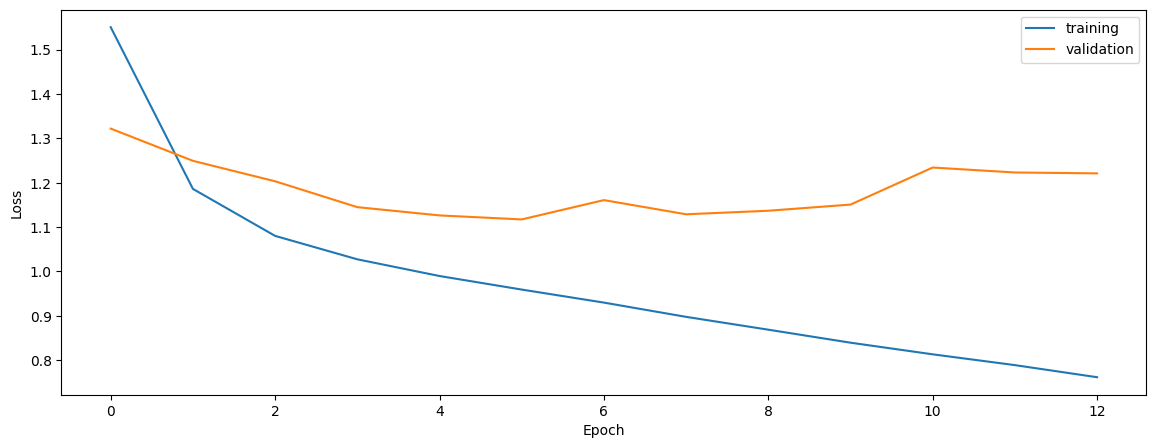

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6324531449243398
0.5700127491687197
0.6013778226227341


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5710578751235835
0.5483810240963856
0.5304633305702194


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5726983798868246
0.5418637913961932
0.5396058366496115


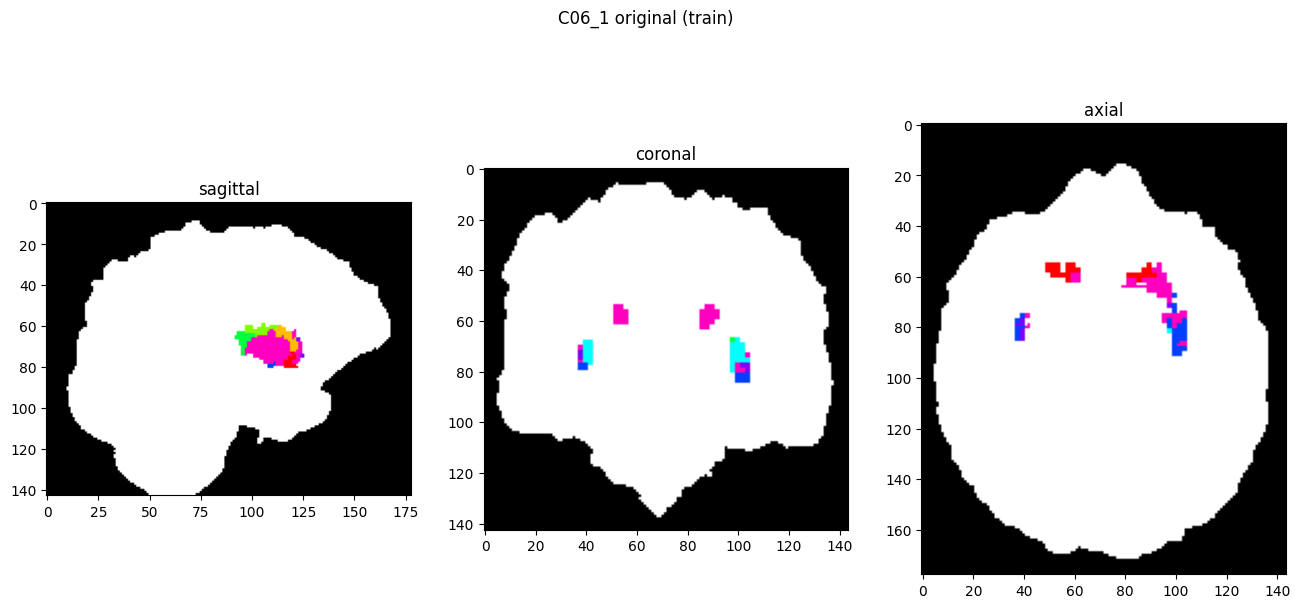

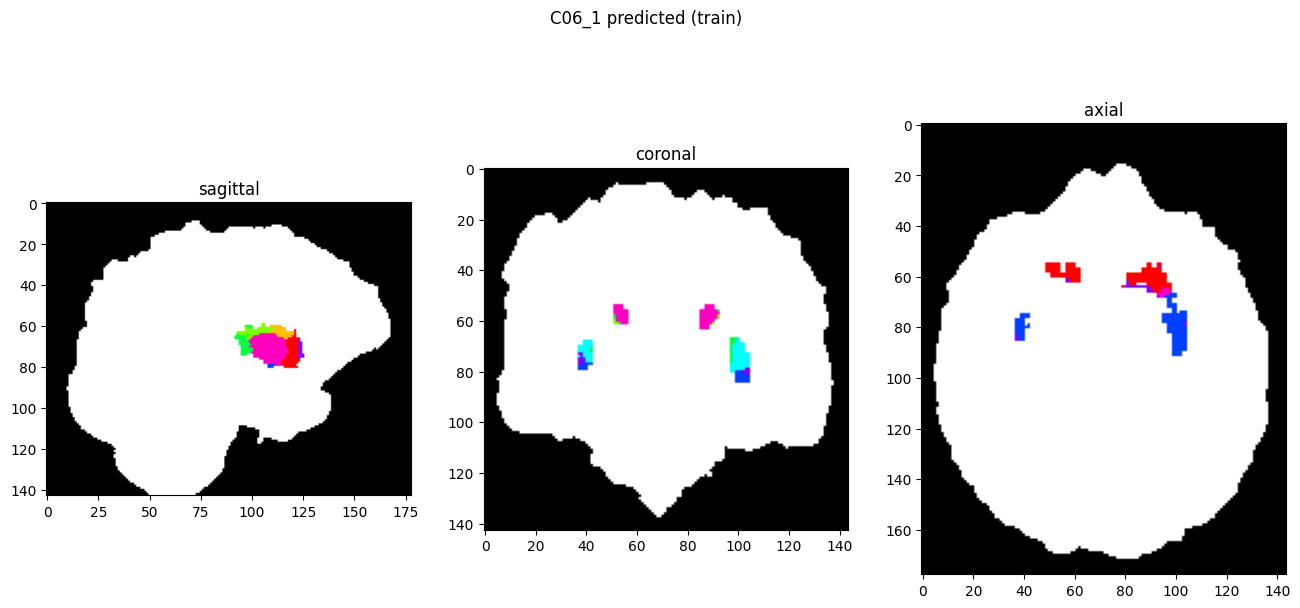

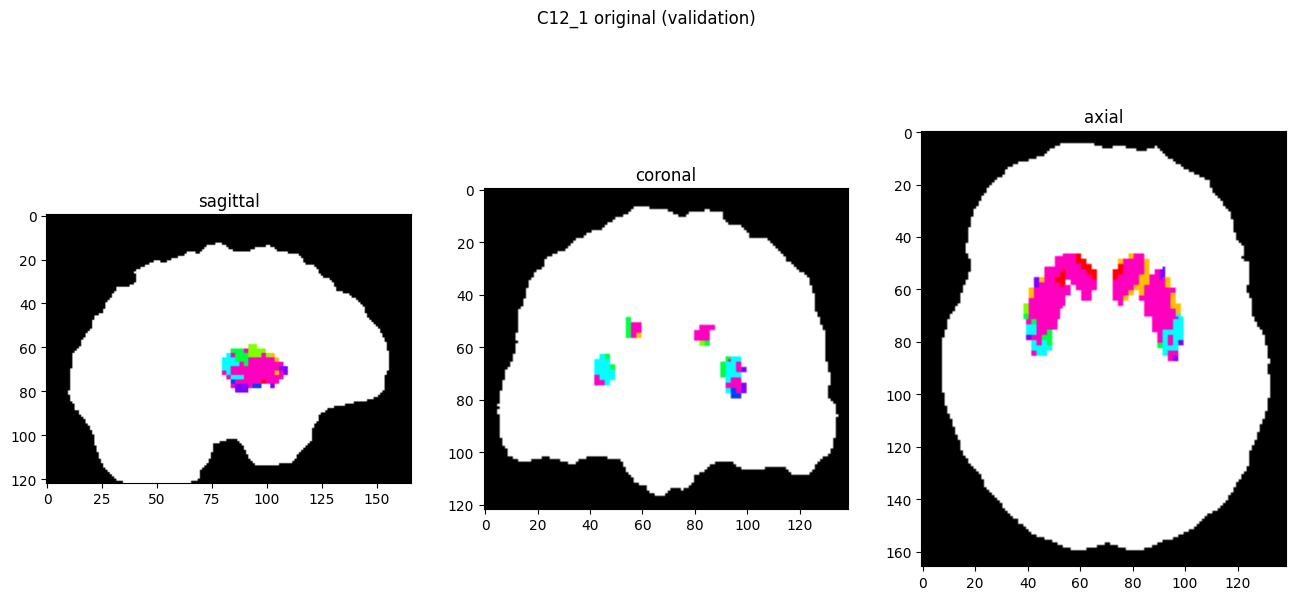

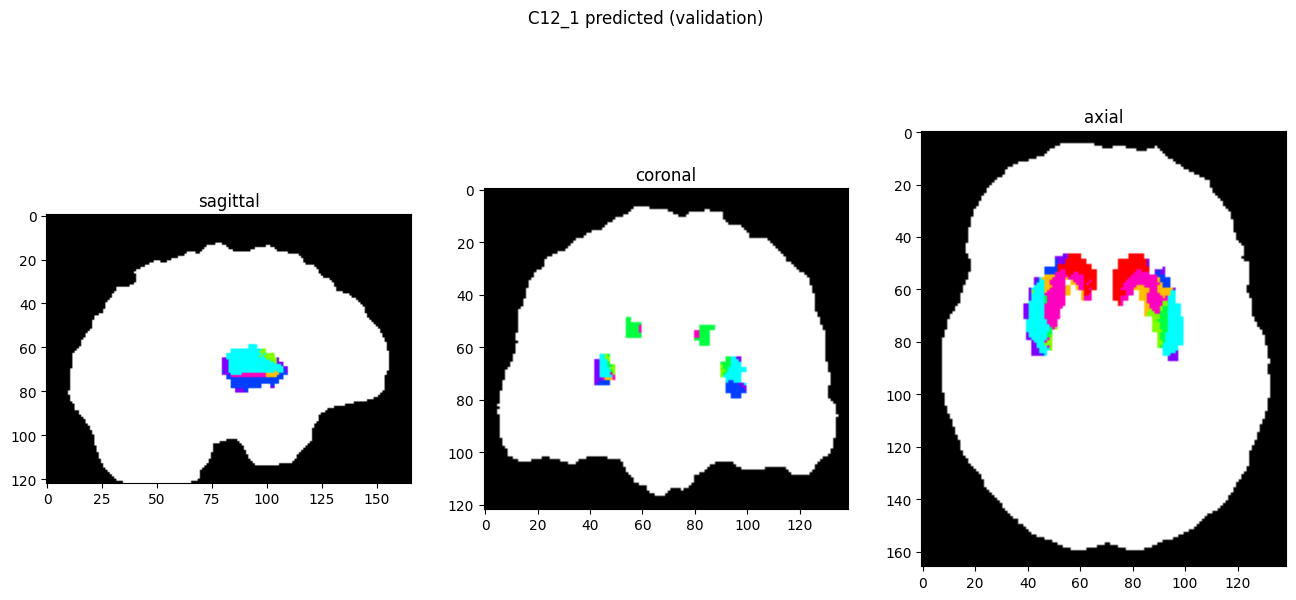

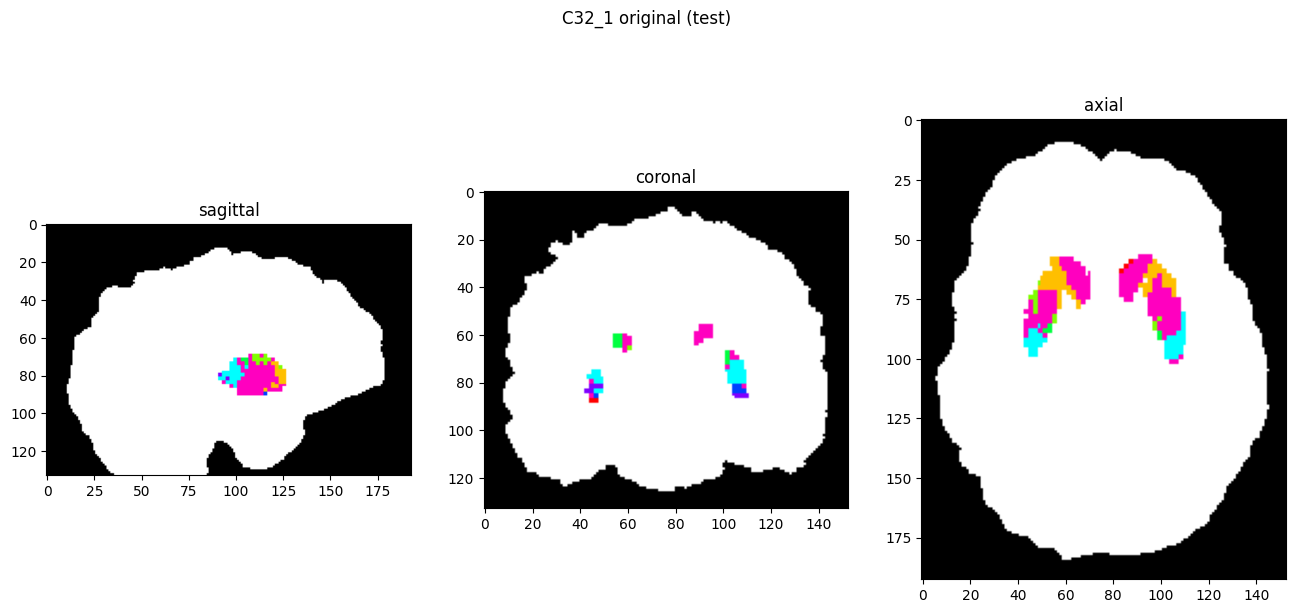

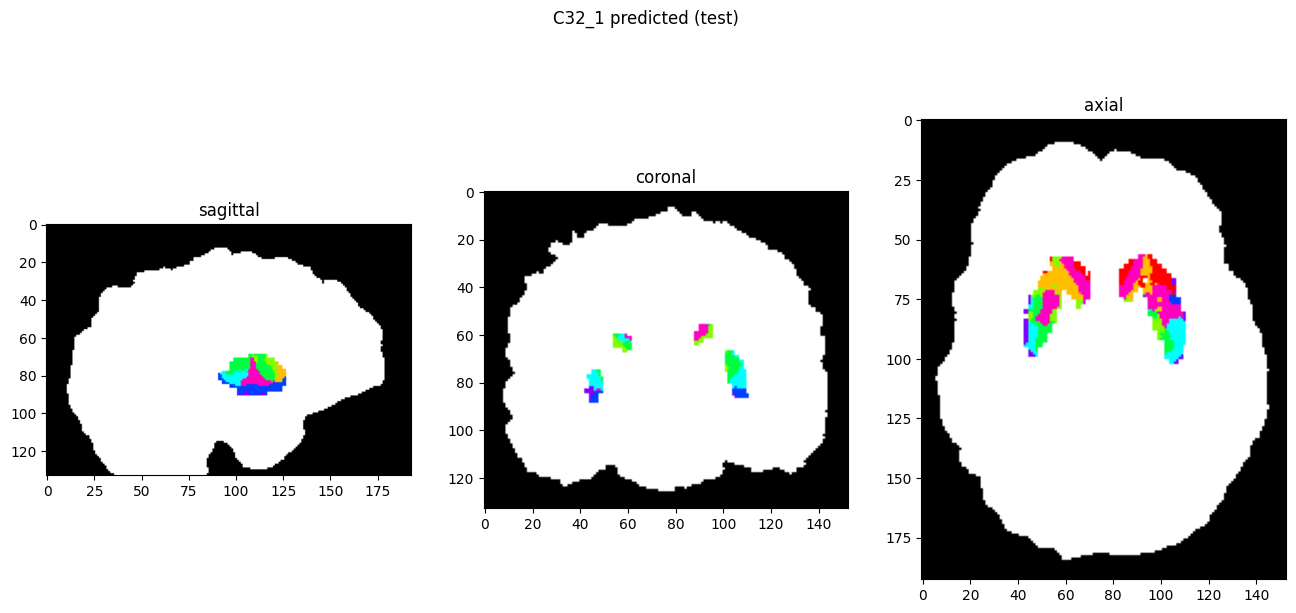

In [10]:
showResults(model, gen, threshold=0)